In [1]:
import os
import sys
module_path = os.path.abspath('RS/thinker/thinker')
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import time
import numpy as np
import argparse
import torch
import torch.nn.functional as F
from thinker.env import Environment
from thinker.net import ActorNet, ModelNet
import thinker.util as util
%matplotlib inline

def plot_gym_env_out(x, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(torch.swapaxes(torch.swapaxes(x[0].cpu(),0,2),0,1), interpolation='nearest', aspect="auto")
    if title is not None: ax.set_title(title)

def plot_multi_gym_env_out(xs):
    size_n = 6
    col_n = 5
    row_n = (len(xs) + (col_n-1))// col_n
    
    fig, axs = plt.subplots(row_n, col_n, figsize=(col_n * size_n, row_n * size_n))  
    if(len(axs.shape) == 1): axs = axs[np.newaxis, :]
    m = 0
    for y in range(row_n):
        for x in range(col_n):
            if m >= len(xs): 
                axs[y][x].set_axis_off()
            else:
                axs[y][x].imshow(np.transpose(xs[m], axes=(1, 2, 0))/255)
                axs[y][x].set_title("rollout %d" % (m+1))
            m += 1
    plt.tight_layout()
    plt.show()

def plot_policies(logits, labels, ax=None, title="Real policy prob"):
    if ax is None: fig, ax = plt.subplots()
    probs = [torch.softmax(logit, dim=-1).detach().cpu().numpy() for logit in logits]
    ax.set_title(title)
    xs = np.arange(len(probs[0]))    
    for n, (prob, label) in enumerate(zip(probs, labels)):
        ax.bar(xs + 0.1 * (n-len(logits) // 2), prob, width = 0.1, label=label)
    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(len(probs[0]))))
    ax.set_xticklabels(('noop', 'up', 'down', 'left', 'right'))
    ax.set_ylim(0, 1)        
    ax.legend()        

def plot_base_policies(logits, ax=None):
    if ax is None: fig, ax = plt.subplots()
    prob = torch.softmax(logits, dim=-1).detach().cpu().numpy()
    rec_t, num_actions = logits.shape
    xs = np.arange(rec_t)
    labels = ['noop', 'up', 'down', 'left', 'right']
    for i in range(num_actions):        
        c = ax.bar(xs + 0.8 * (i / num_actions), prob[:,i], width = 0.8 / (num_actions), label=labels[i])  
        color = c.patches[0].get_facecolor()
        color = color[:3] + (color[3] * 0.5,)
        ax.bar(xs + 0.8 * (i / num_actions), prob[:,i], width = 0.8 / (num_actions), color=color)
    ax.legend()
    ax.set_ylim(0, 1)   
    ax.set_title("Model policy prob")

def plot_im_policies(im_policy_logits, reset_policy_logits, term_policy_logits, 
                     im_action, reset_action, term_action,
                     one_hot=True, reset_ind=0, ax=None):
    if ax is None: fig, ax = plt.subplots()
        
    rec_t, num_actions = im_policy_logits.shape
    num_actions += 1
    rec_t -= 1
        
    im_prob = torch.softmax(im_policy_logits, dim=-1).detach().cpu().numpy()
    reset_prob = torch.softmax(reset_policy_logits, dim=-1)[:,[reset_ind]].detach().cpu().numpy()
    full_prob = np.concatenate([im_prob, reset_prob], axis=-1)
    if term_policy_logits is not None:
        term_prob = torch.softmax(term_policy_logits, dim=-1)[:,[reset_ind]].detach().cpu().numpy()
        full_prob = np.concatenate([full_prob, term_prob], axis=-1)
    
    if not one_hot: im_action = F.one_hot(im_action, num_actions - 1)
    im_action = im_action.detach().cpu().numpy()
    reset_action = reset_action.unsqueeze(-1).detach().cpu().numpy()    
    full_action = np.concatenate([im_action, reset_action], axis=-1)
    if term_action is not None:
        term_action = term_action.unsqueeze(-1).detach().cpu().numpy() 
        full_action = np.concatenate([full_action, term_action], axis=-1)
    
    xs = np.arange(rec_t+1)
    labels = ['noop', 'up', 'down', 'left', 'right', 'reset']   
    
    if term_action is not None:
        labels.append('term')
        num_actions += 1
        
    for i in range(num_actions):        
        c = ax.bar(xs + 0.8 * (i / num_actions), full_prob[:,i], width = 0.8 / (num_actions), label=labels[i])  
        color = c.patches[0].get_facecolor()
        color = color[:3] + (color[3] * 0.5,)
        ax.bar(xs + 0.8 * (i / num_actions), full_action[:,i], width = 0.8 / (num_actions), color=color)
        
    ax.legend()
    ax.set_ylim(0, 1)   
    ax.set_title("Imagainary policy prob")    

def plot_qn_sa(q_s_a, n_s_a, max_q_s_a=None, ax=None):
    if ax is None: fig, ax = plt.subplots()
    xs = np.arange(len(q_s_a))

    ax.bar(xs - 0.3, q_s_a.cpu(), color = 'g', width = 0.3, label="q_s_a")    
    ax_n = ax.twinx()
    if max_q_s_a is not None:
        ax.bar(xs, max_q_s_a.cpu(), color = 'r', width = 0.3, label="max_q_s_a")        
    ax_n.bar(xs + (0.3 if max_q_s_a is not None else 0.), 
             n_s_a.cpu(), bottom=0, color = 'b', width = 0.3, label="n_s_a")
    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(len(q_s_a))))
    ax.set_xticklabels(('noop', 'up', 'down', 'left', 'right'))    
    ax.legend(loc="upper left")   
    ax_n.legend(loc="upper right") 
    ax.set_title("q_s_a and n_s_a")    

def print_im_actions(im_dict, print_stat=False):

    lookup_dict = {0:"Noop",
                   1:"Up",
                   2:"Down",
                   3:"Left",
                   4:"Right"}

    print_strs = []
    n, s = 1, ""
    reset = False
    for im, reset in zip(im_dict["im_action"][:-1], im_dict["reset_action"][:-1]):
        s += lookup_dict[im.item()] + ", "
        if reset:        
            s += "Reset"
            print_strs.append("%d: %s" %(n, s))
            s = ""
            n += 1
    if not reset: print_strs.append("%d: %s" %(n, s[:-2]))
    if print_stat: 
        for s in print_strs: print(s) 
    return print_strs    

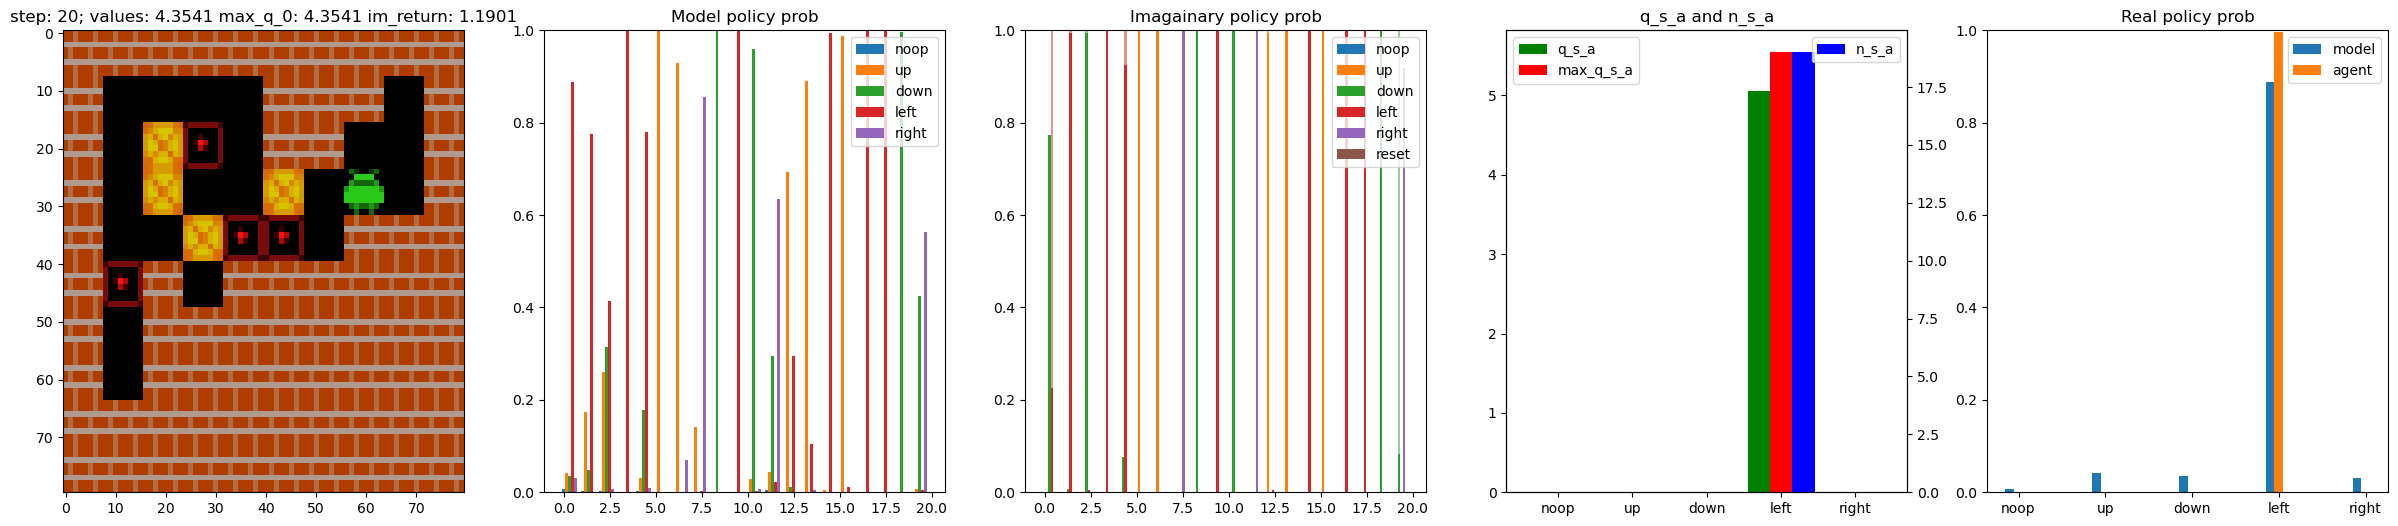

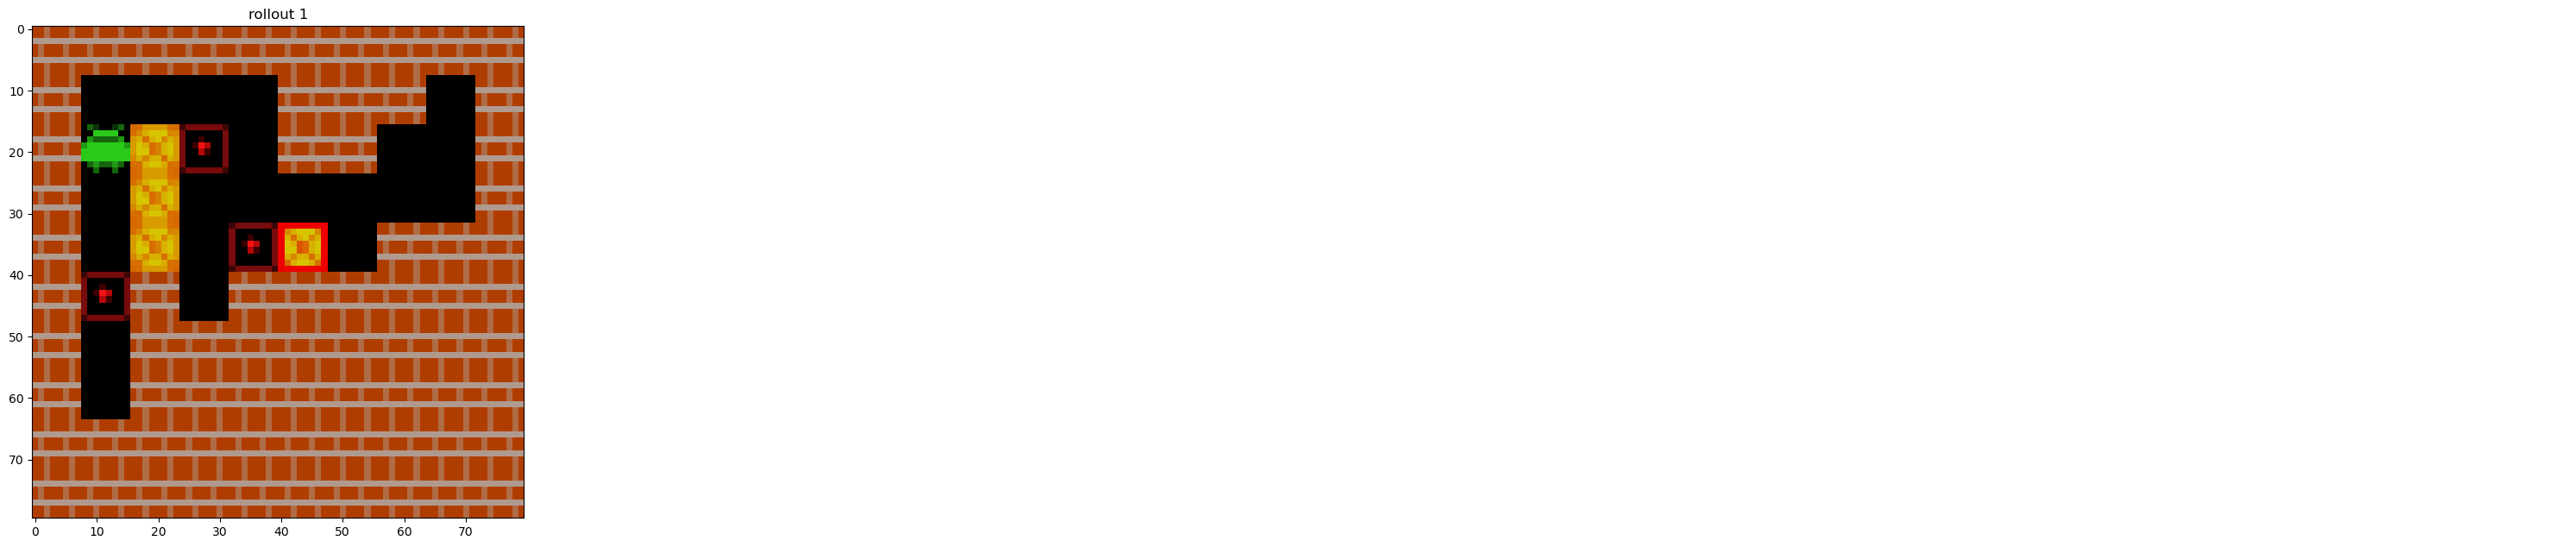

1: Left, Left, Down, Left, Left, Up, Up, Right, Down, Left, Down, Right, Up, Up, Left, Up, Left, Left, Down


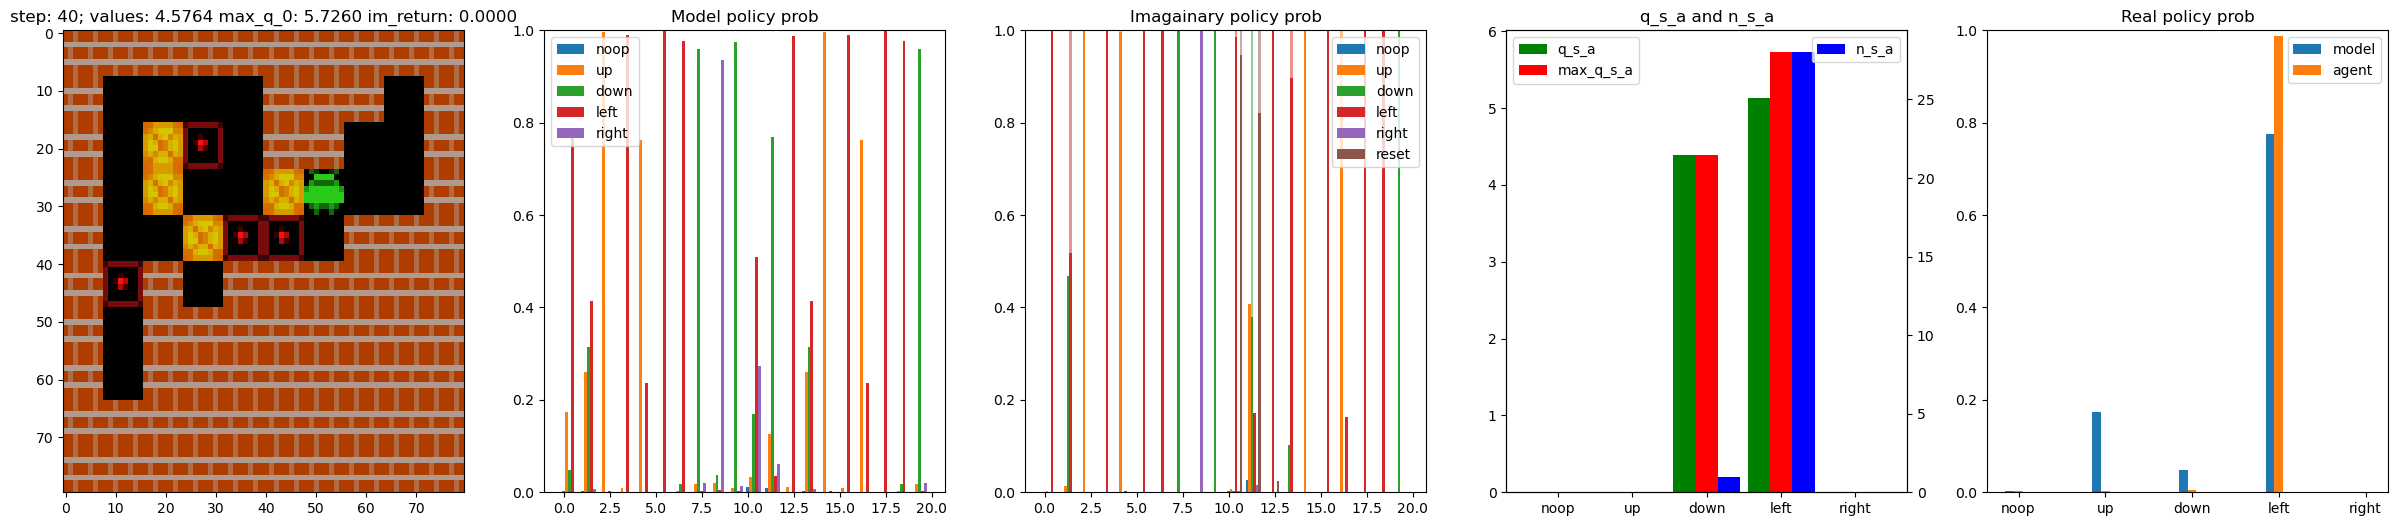

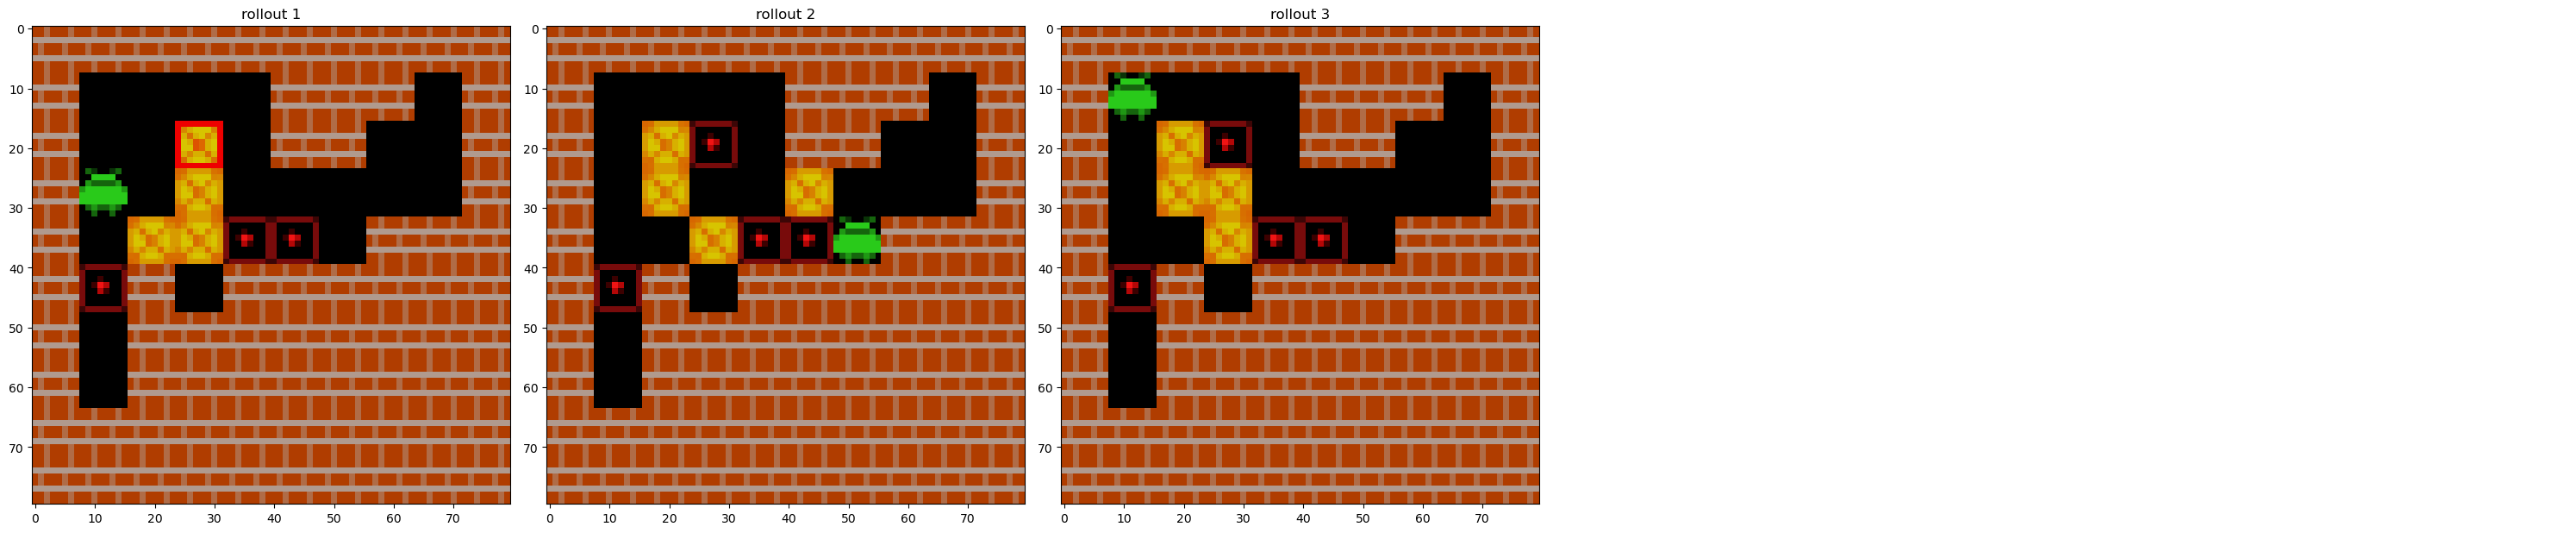

1: Left, Left, Up, Left, Up, Left, Left, Down, Right, Down, Left, Reset
2: Down, Reset
3: Left, Left, Up, Left, Up, Left, Left


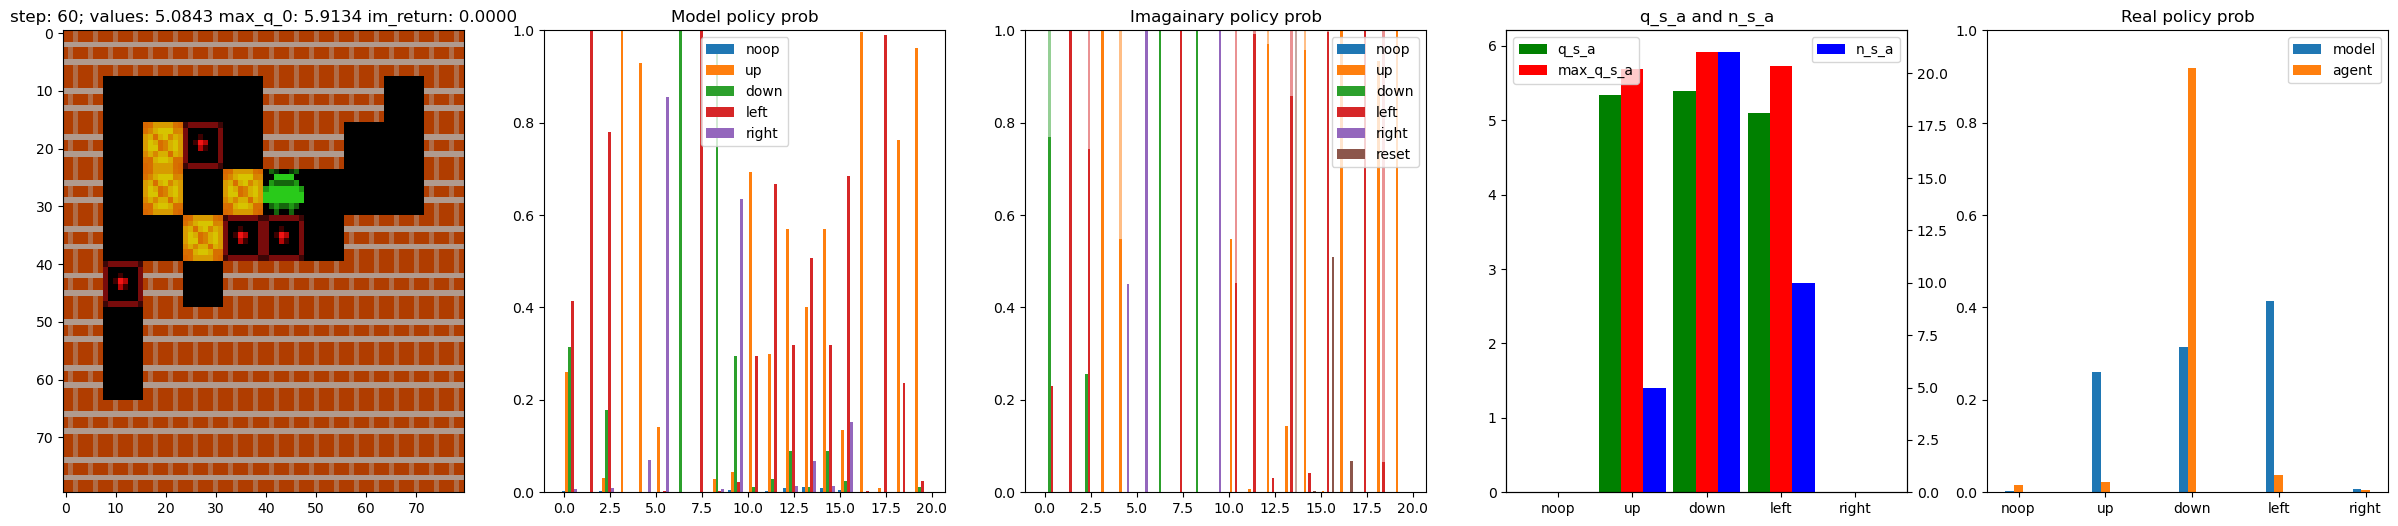

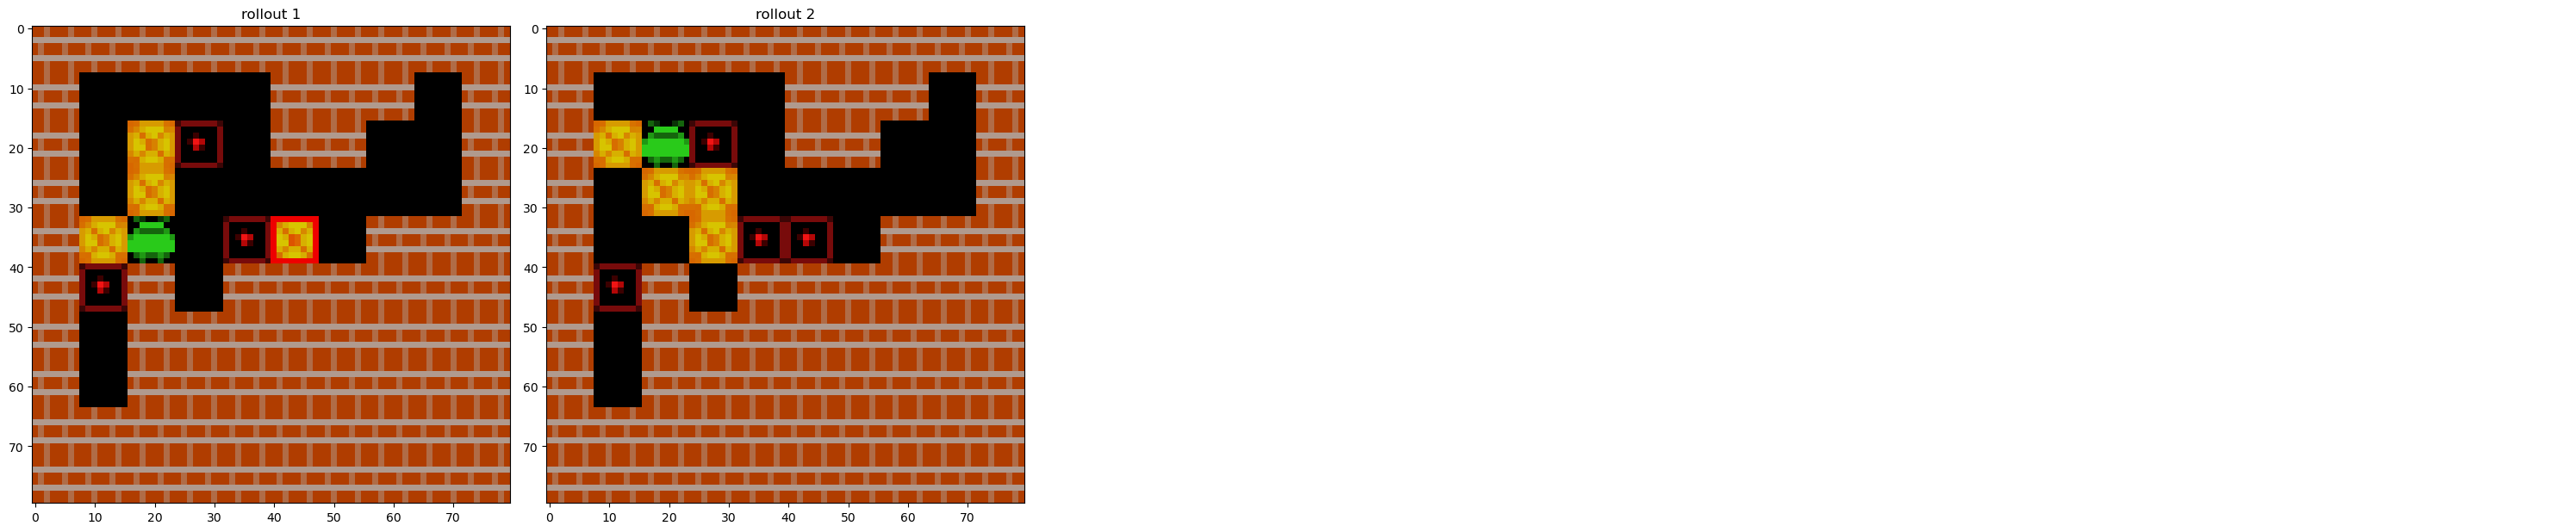

1: Down, Left, Left, Up, Up, Right, Down, Left, Down, Right, Left, Left, Up, Left, Reset
2: Up, Left, Up, Left, Left


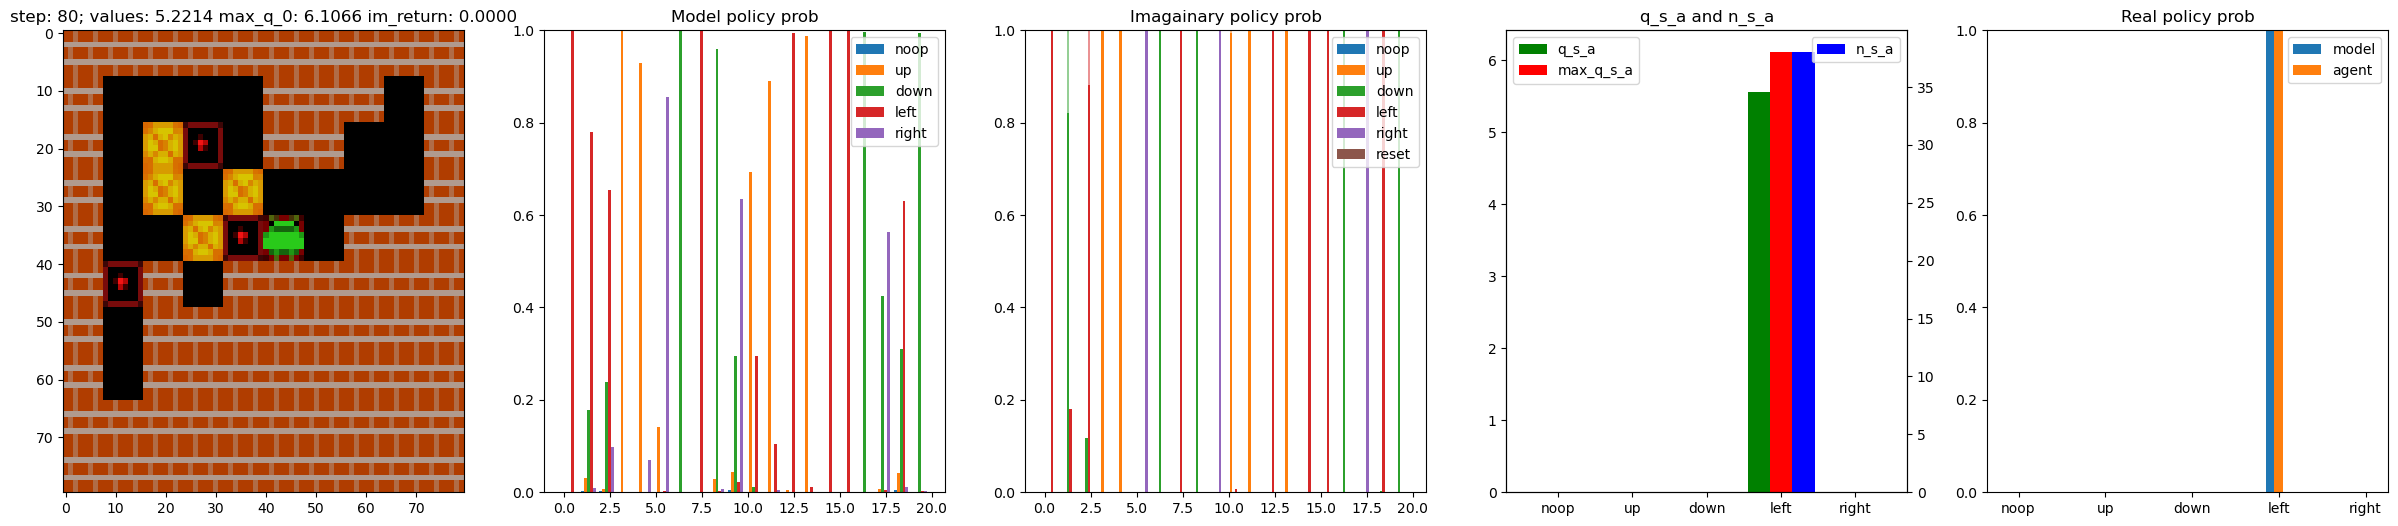

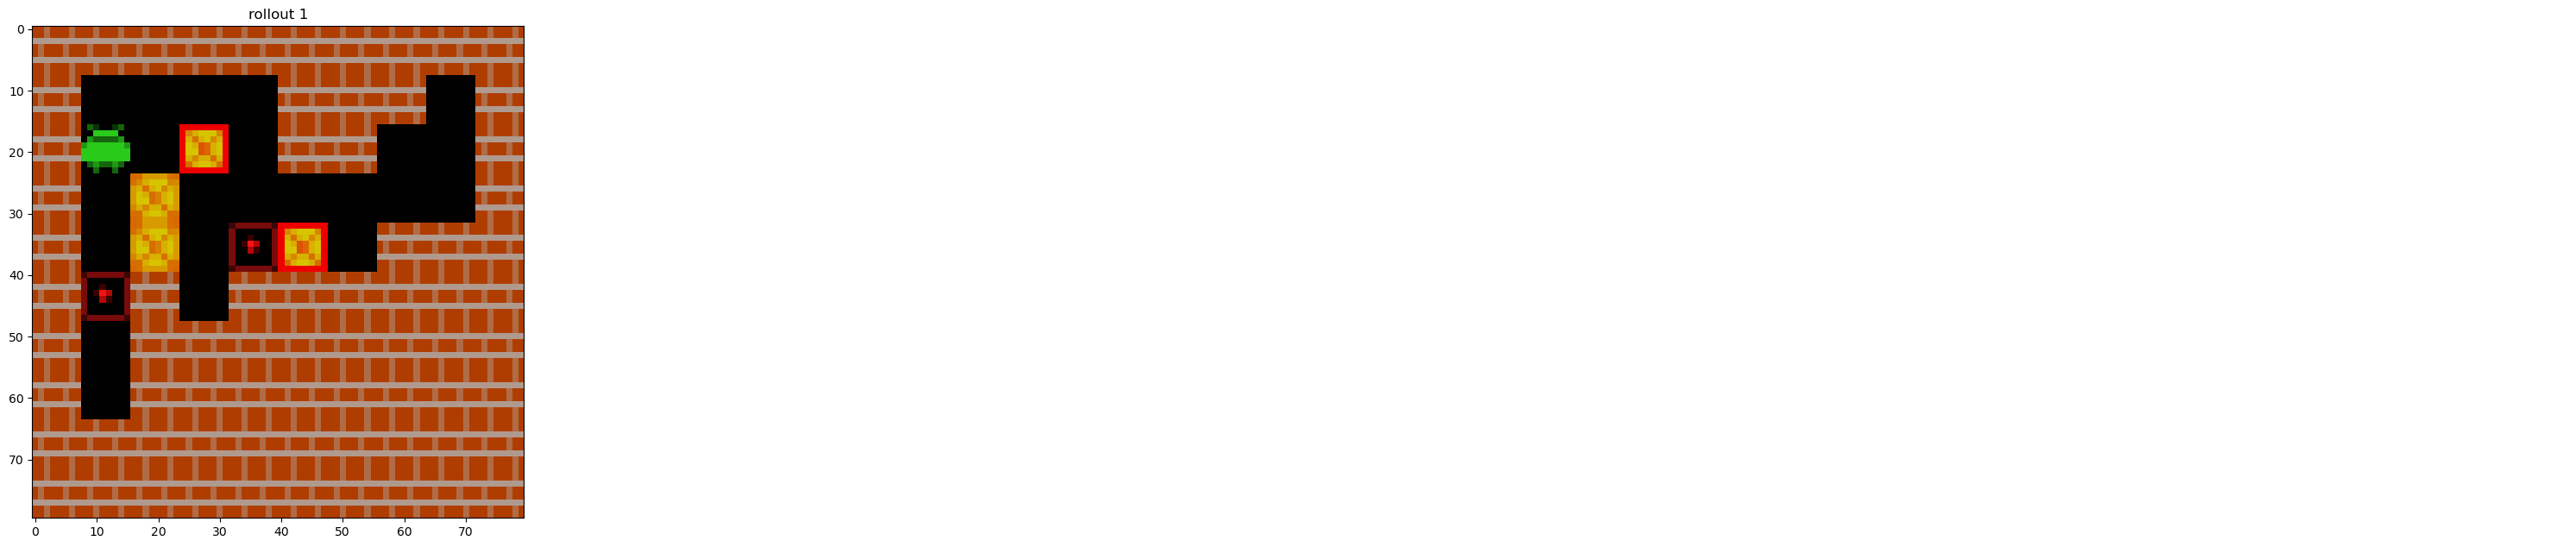

1: Left, Down, Left, Up, Up, Right, Down, Left, Down, Right, Up, Up, Left, Up, Left, Left, Down, Right, Left


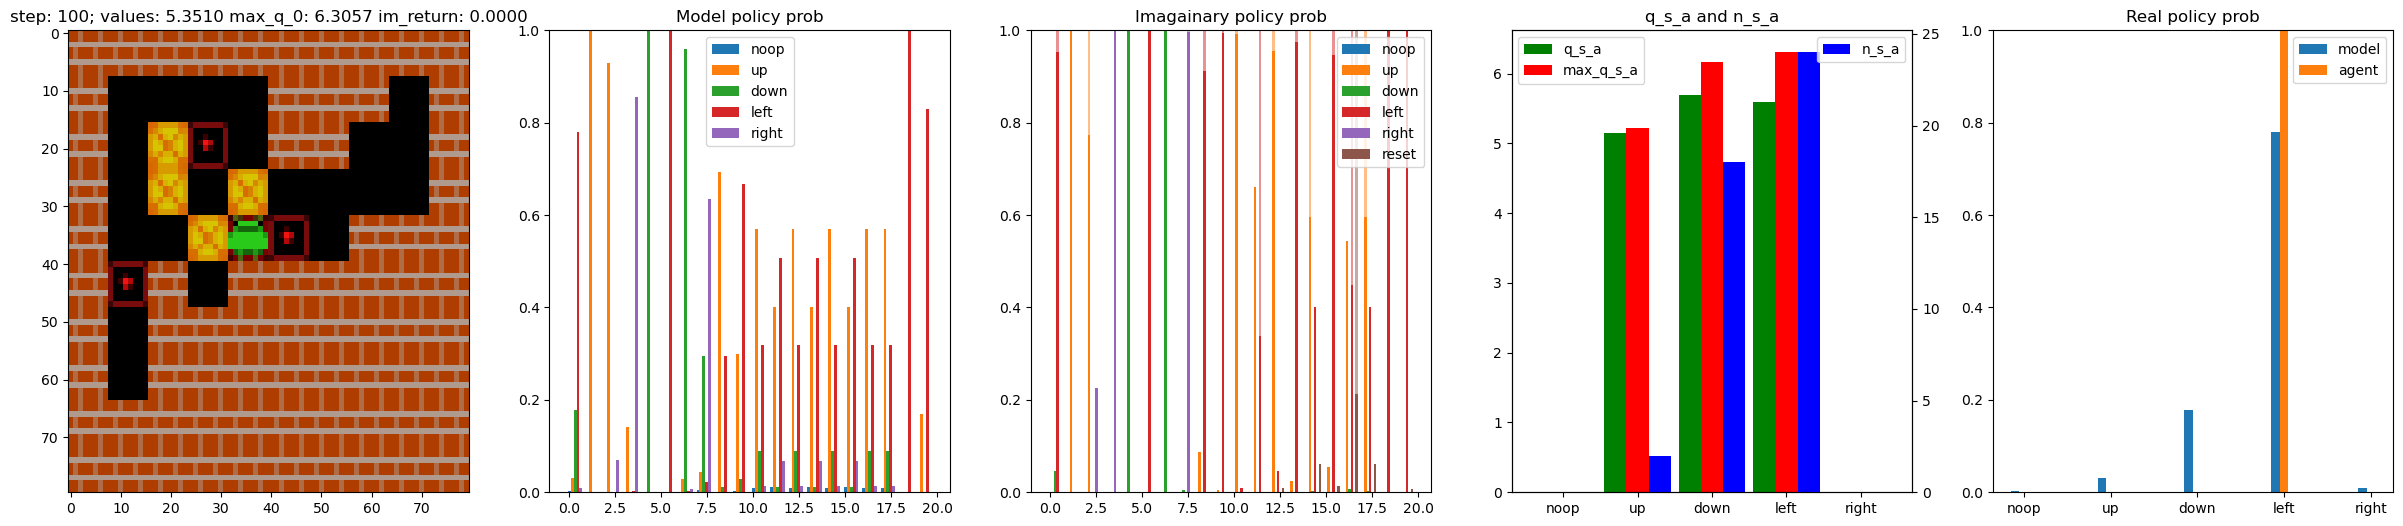

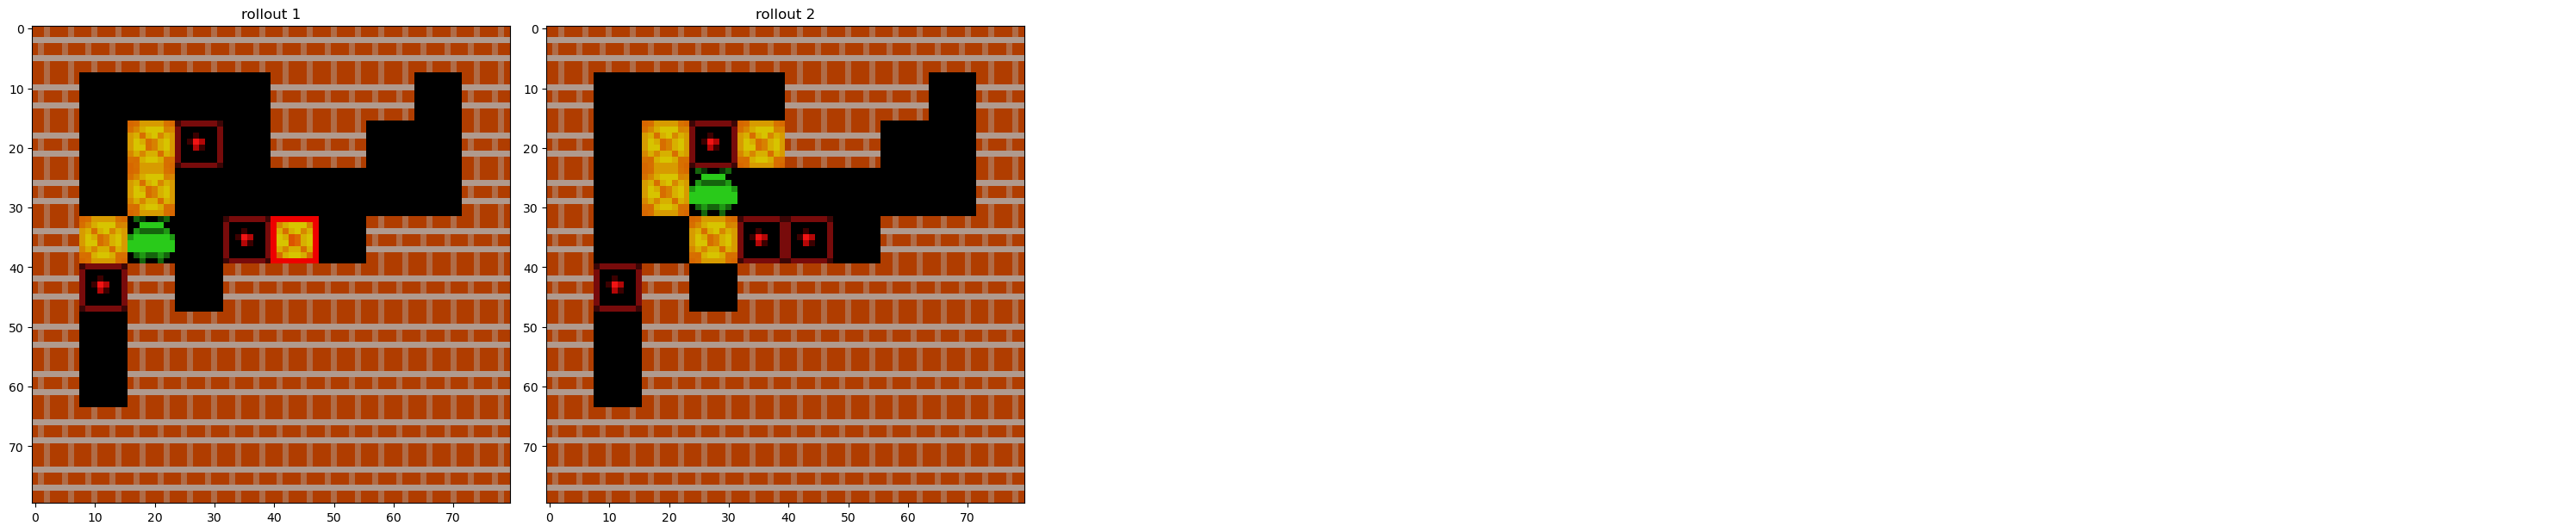

1: Left, Up, Up, Right, Down, Left, Down, Right, Left, Left, Up, Left, Up, Left, Up, Left, Left, Reset
2: Up, Left


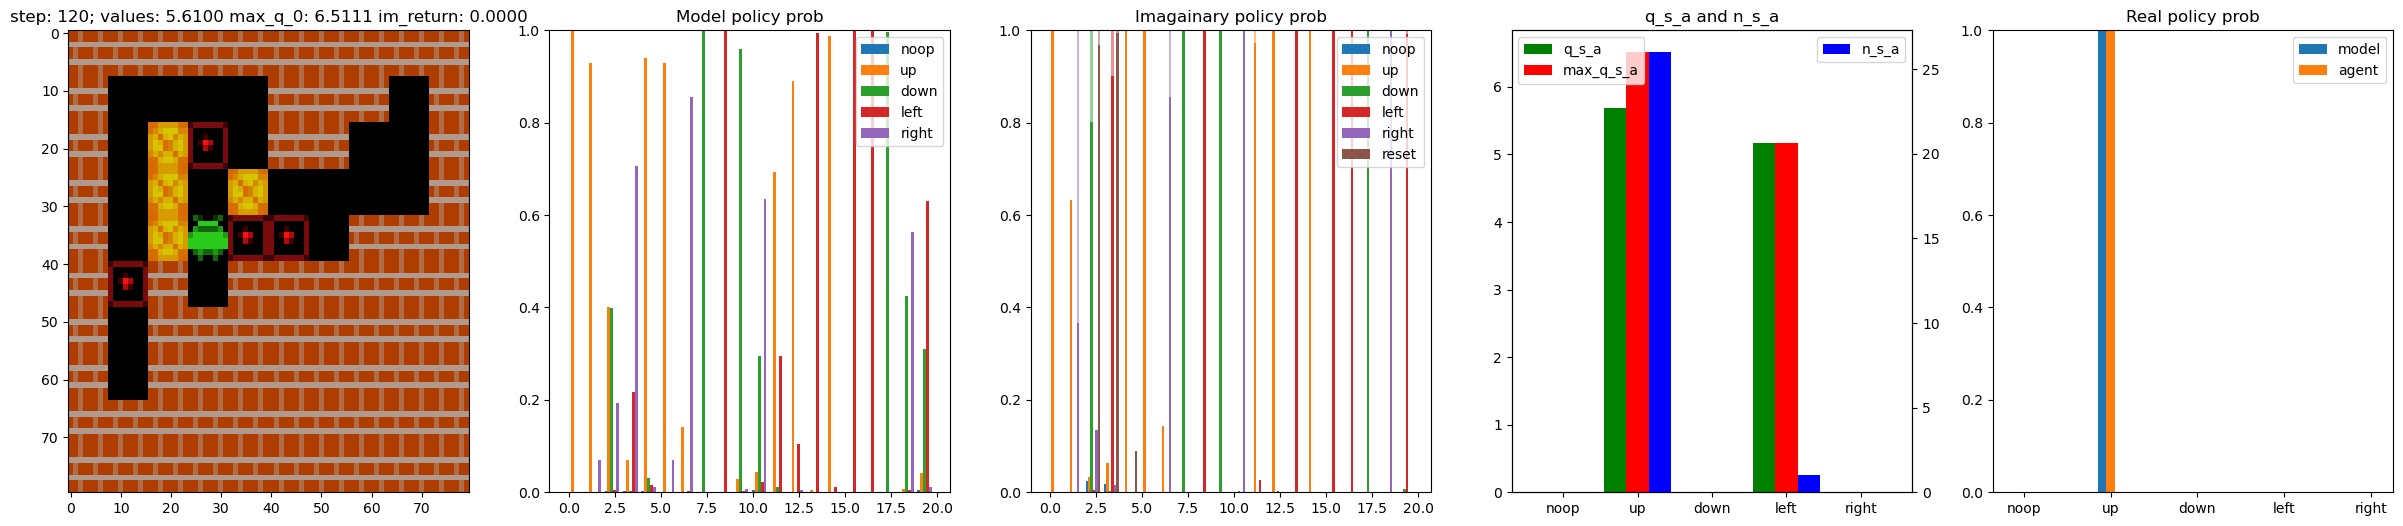

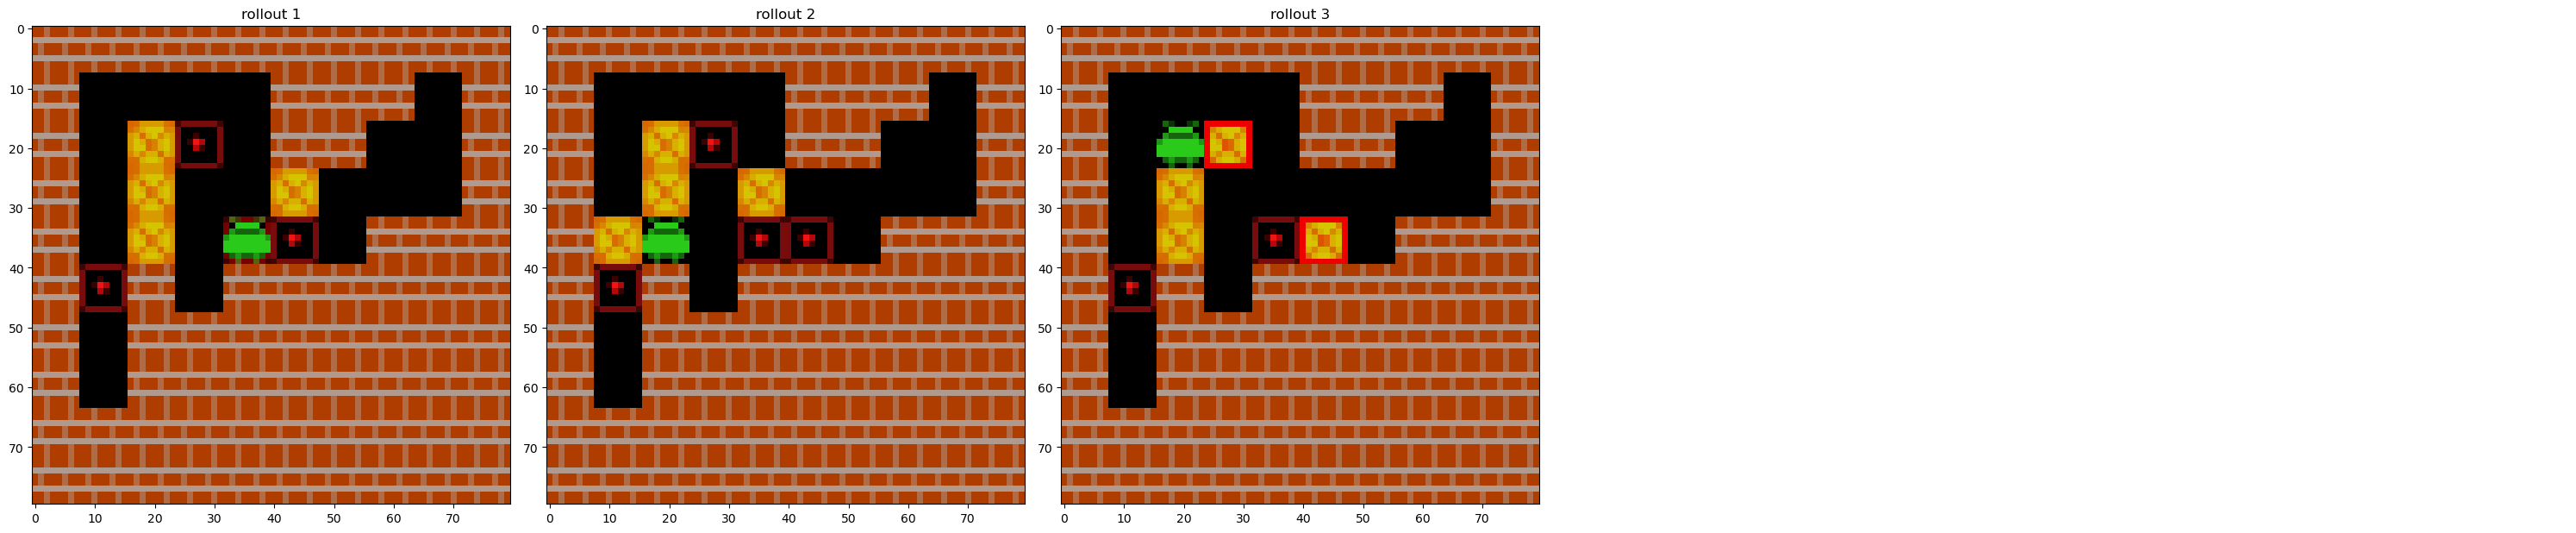

1: Up, Right, Down, Reset
2: Left, Reset
3: Up, Up, Right, Down, Left, Down, Right, Up, Up, Left, Up, Left, Left, Down, Right


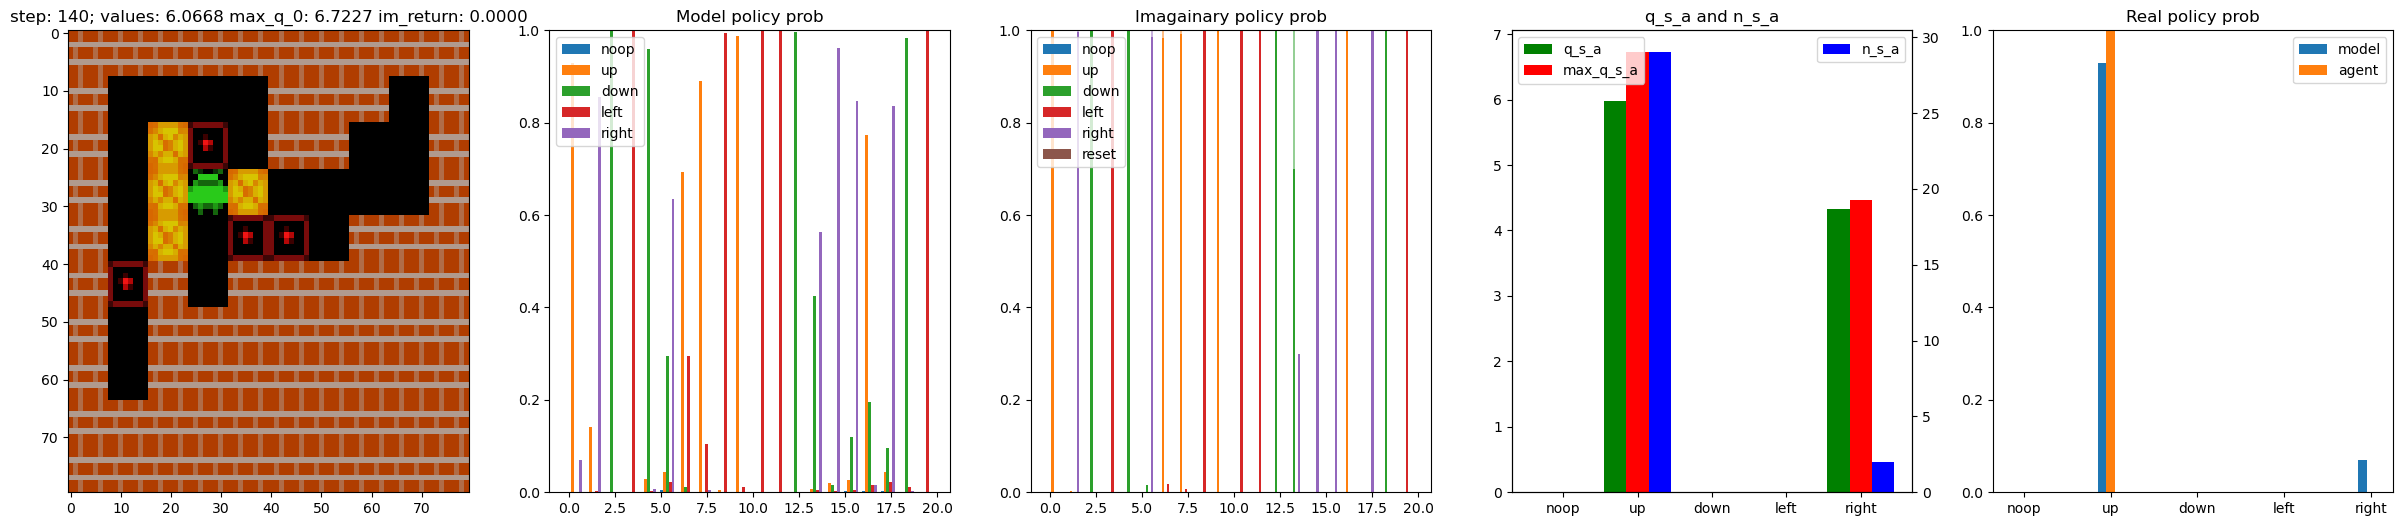

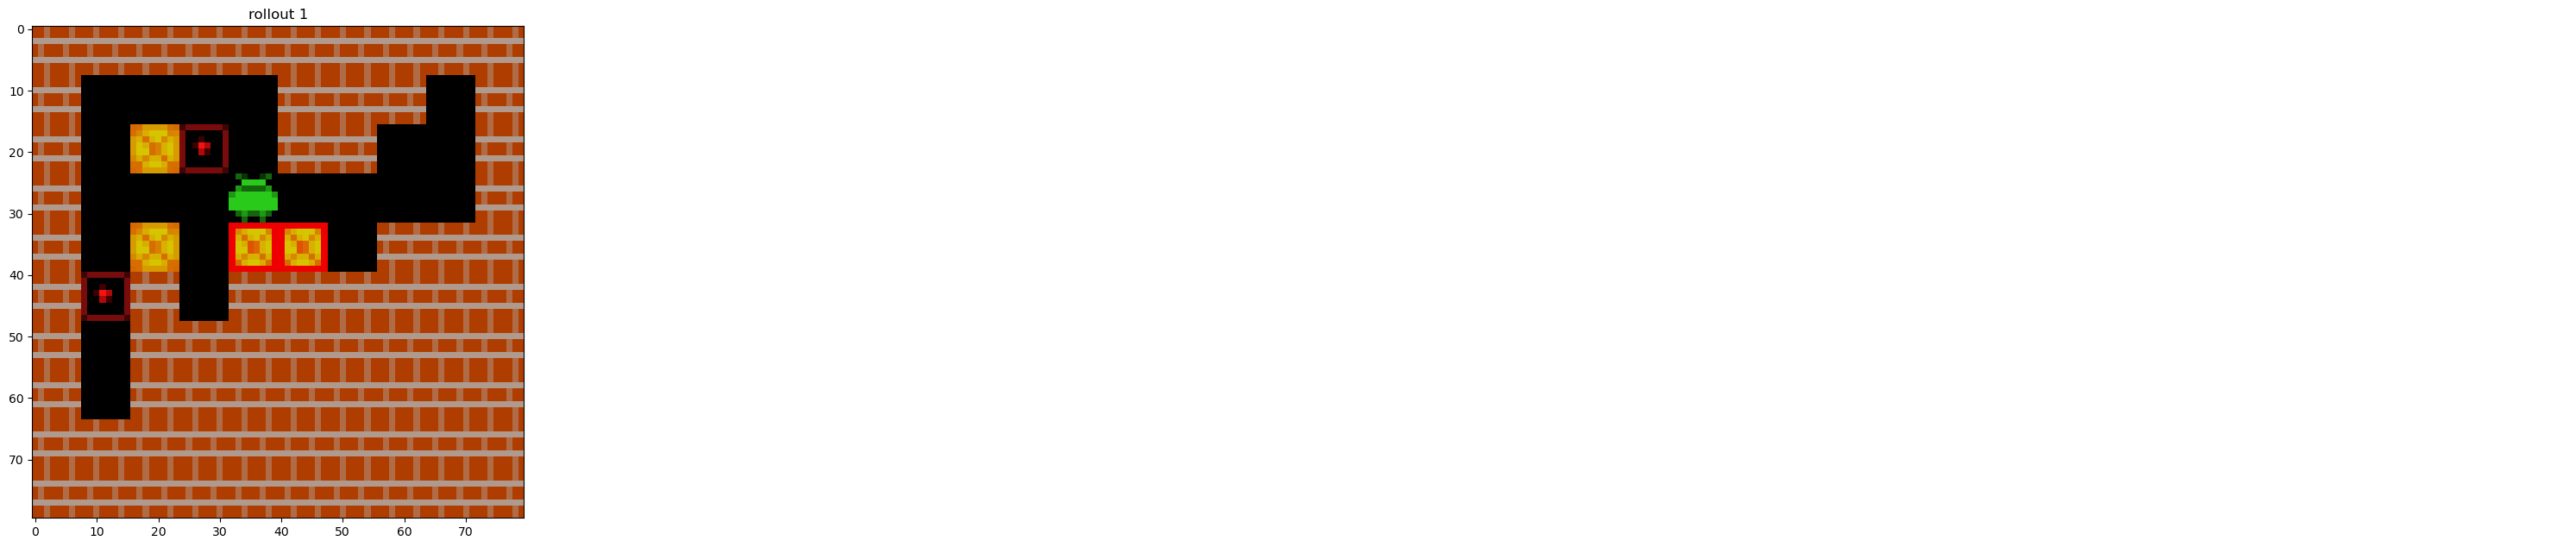

1: Up, Right, Down, Left, Down, Right, Up, Up, Left, Up, Left, Left, Down, Down, Right, Right, Up, Right, Down


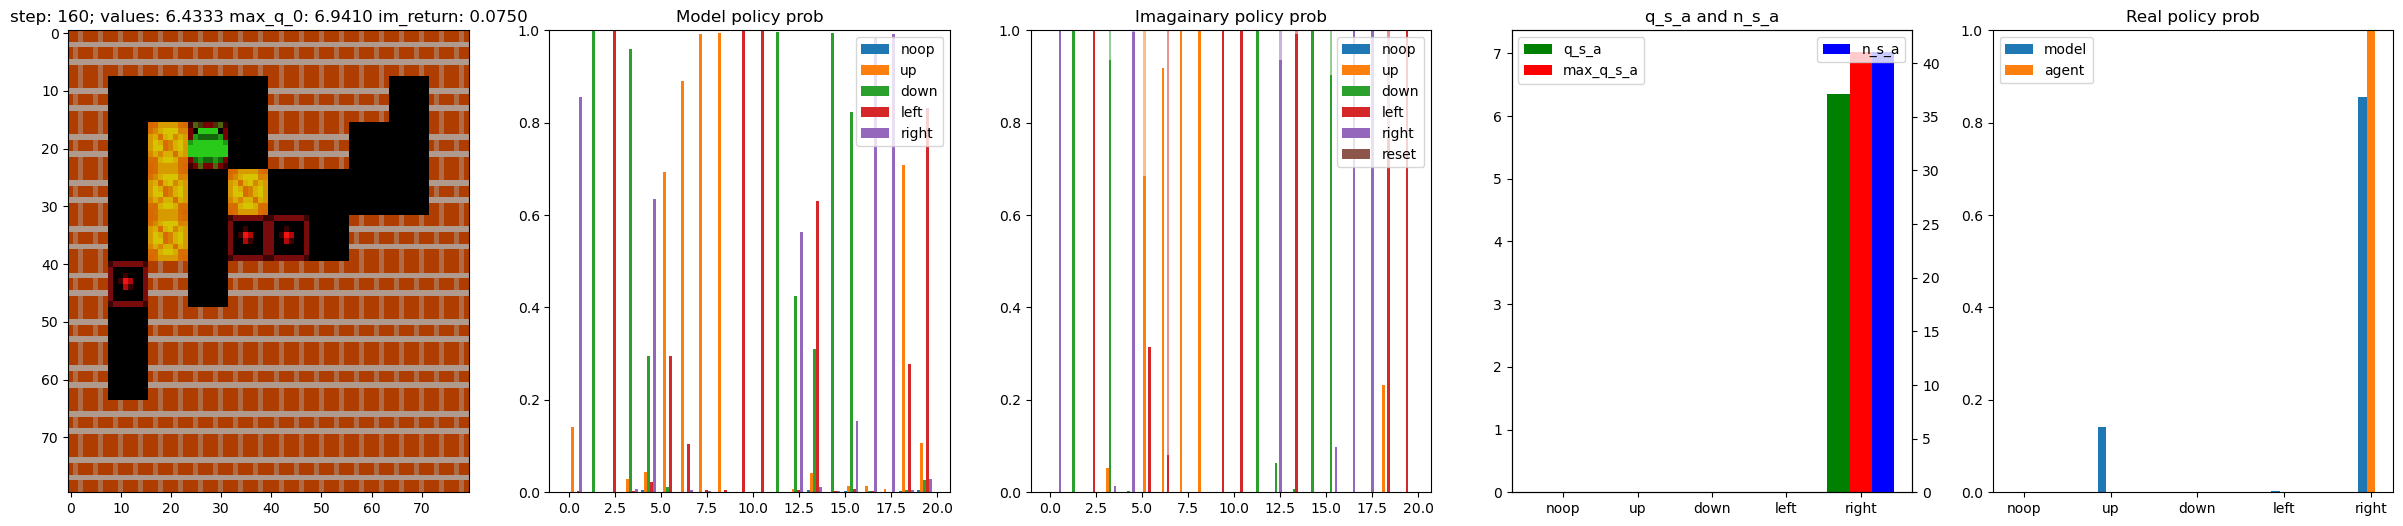

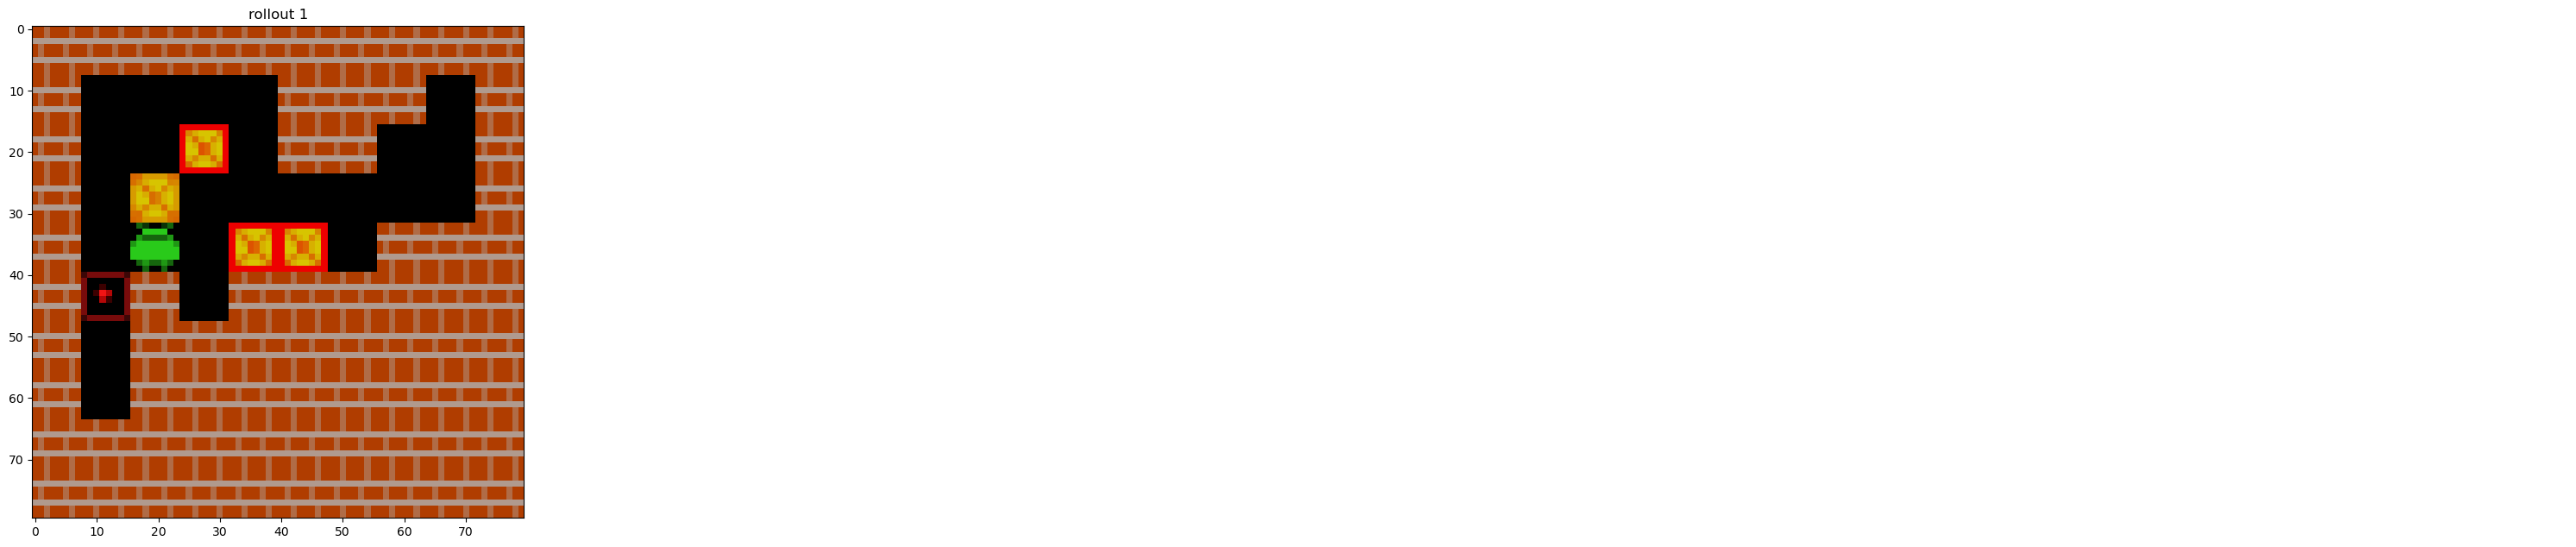

1: Right, Down, Left, Down, Right, Up, Left, Up, Up, Left, Left, Down, Right, Left, Down, Down, Right, Right, Left


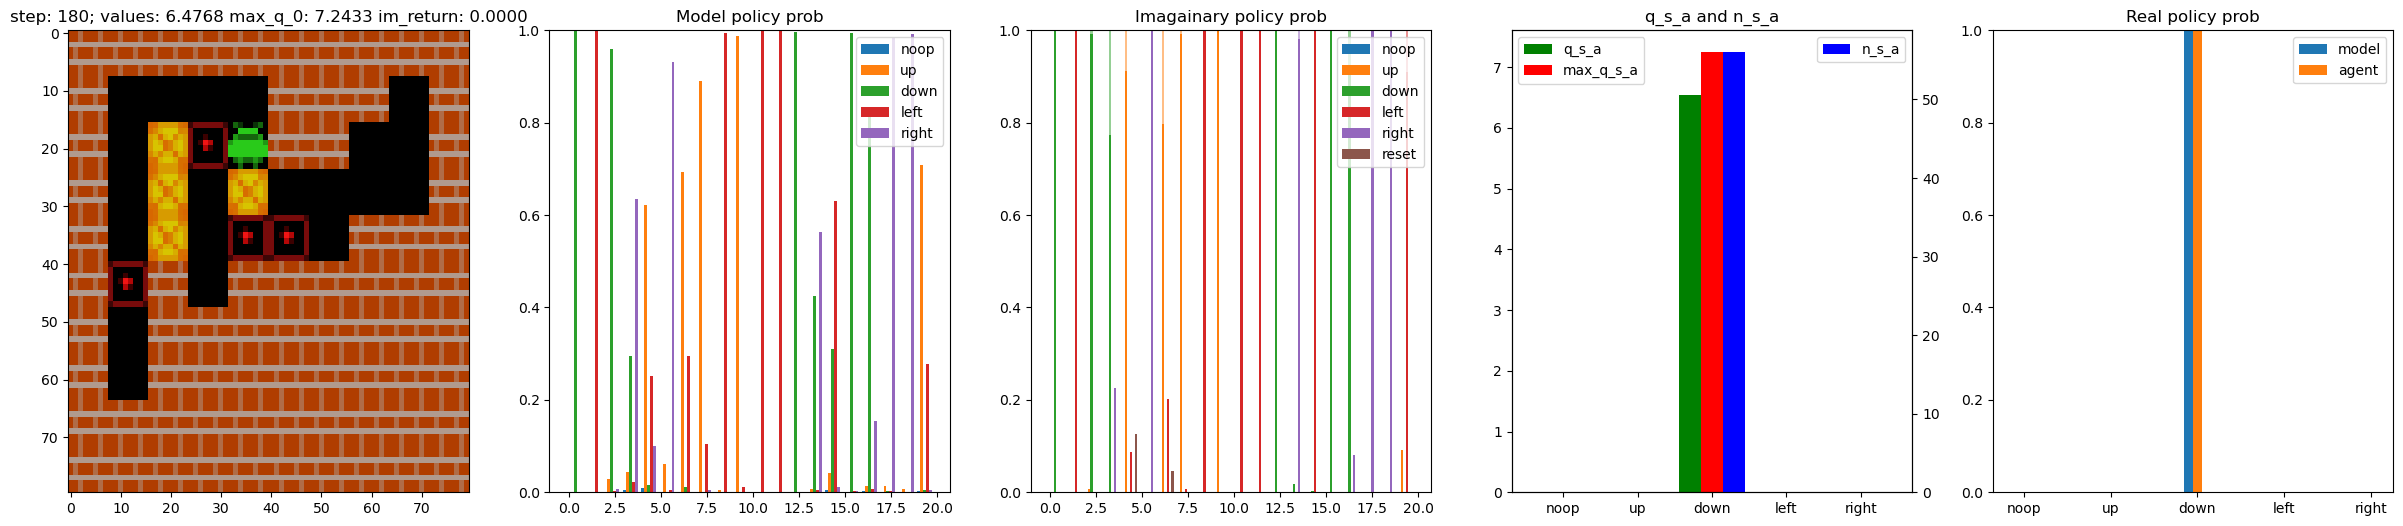

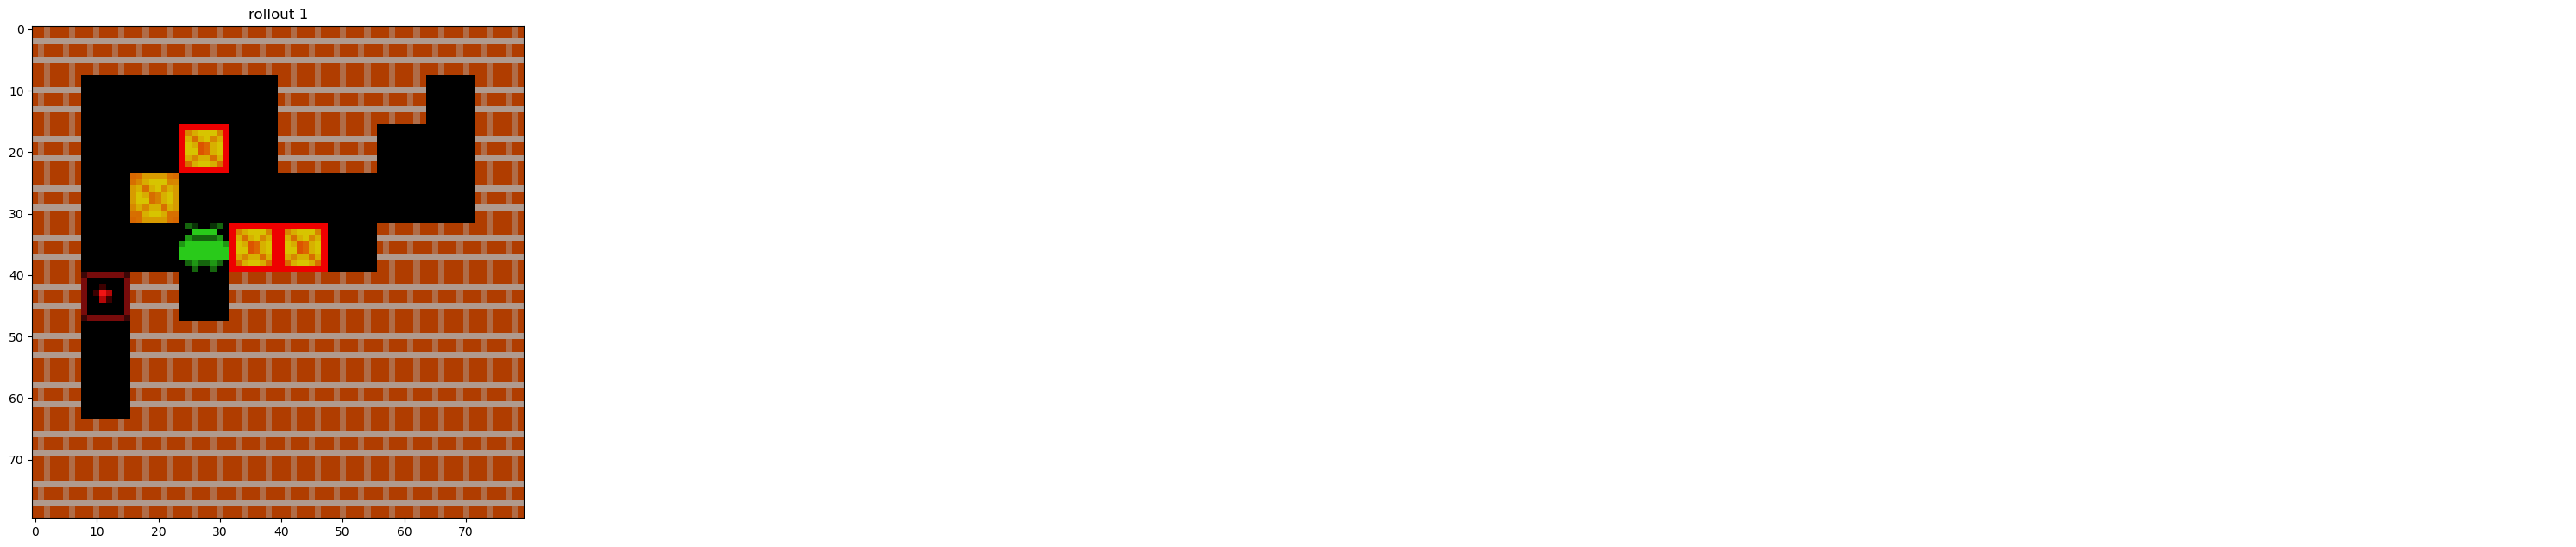

1: Down, Left, Down, Down, Up, Right, Up, Up, Left, Up, Left, Left, Down, Right, Left, Down, Down, Right, Right


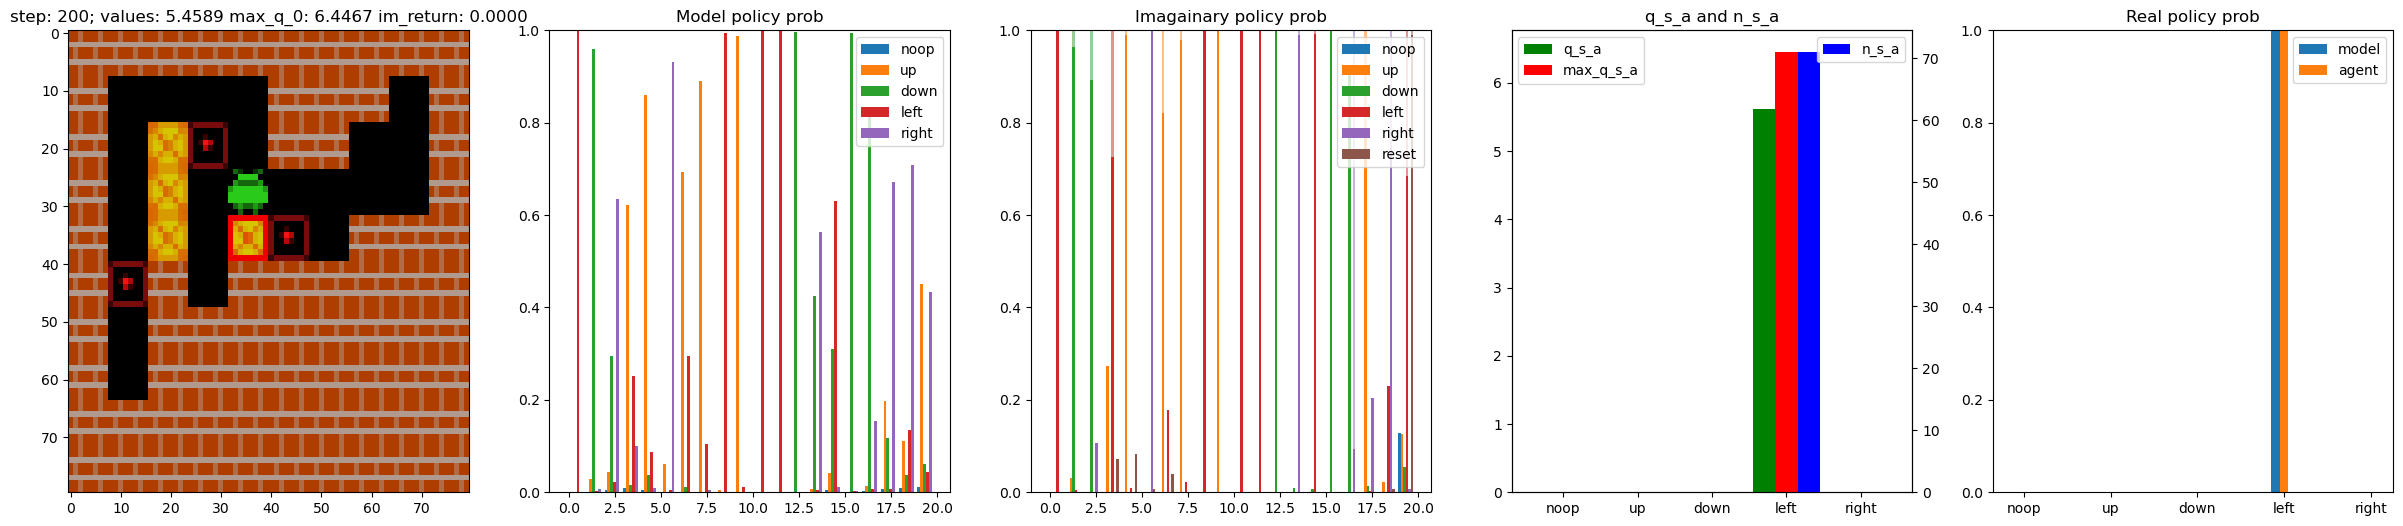

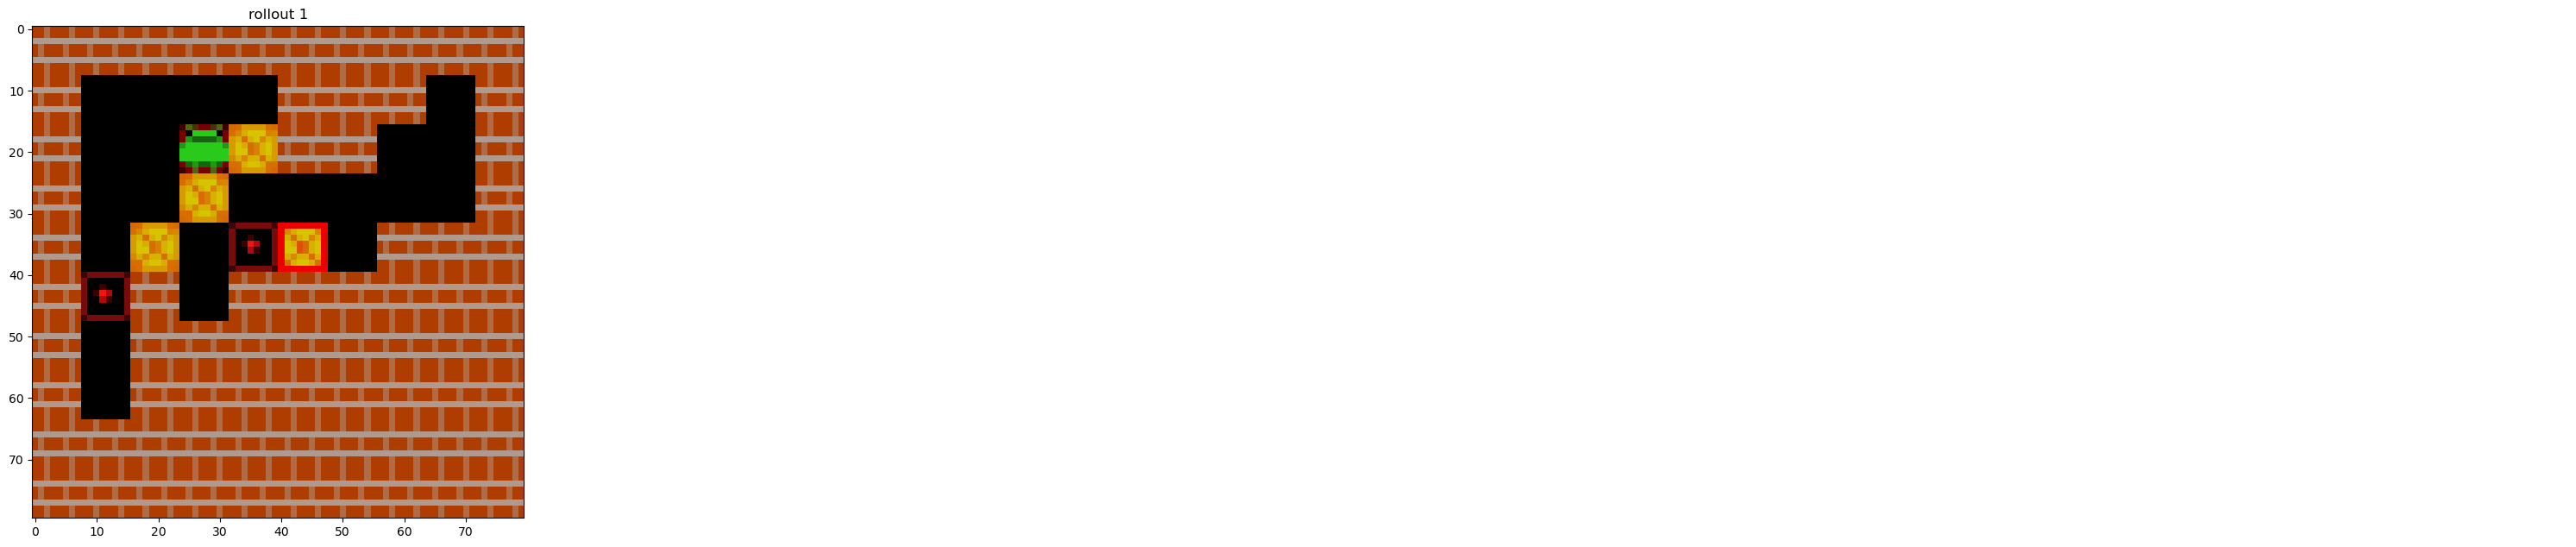

1: Left, Down, Down, Left, Up, Right, Up, Up, Left, Up, Left, Left, Down, Right, Left, Down, Right, Up, Right


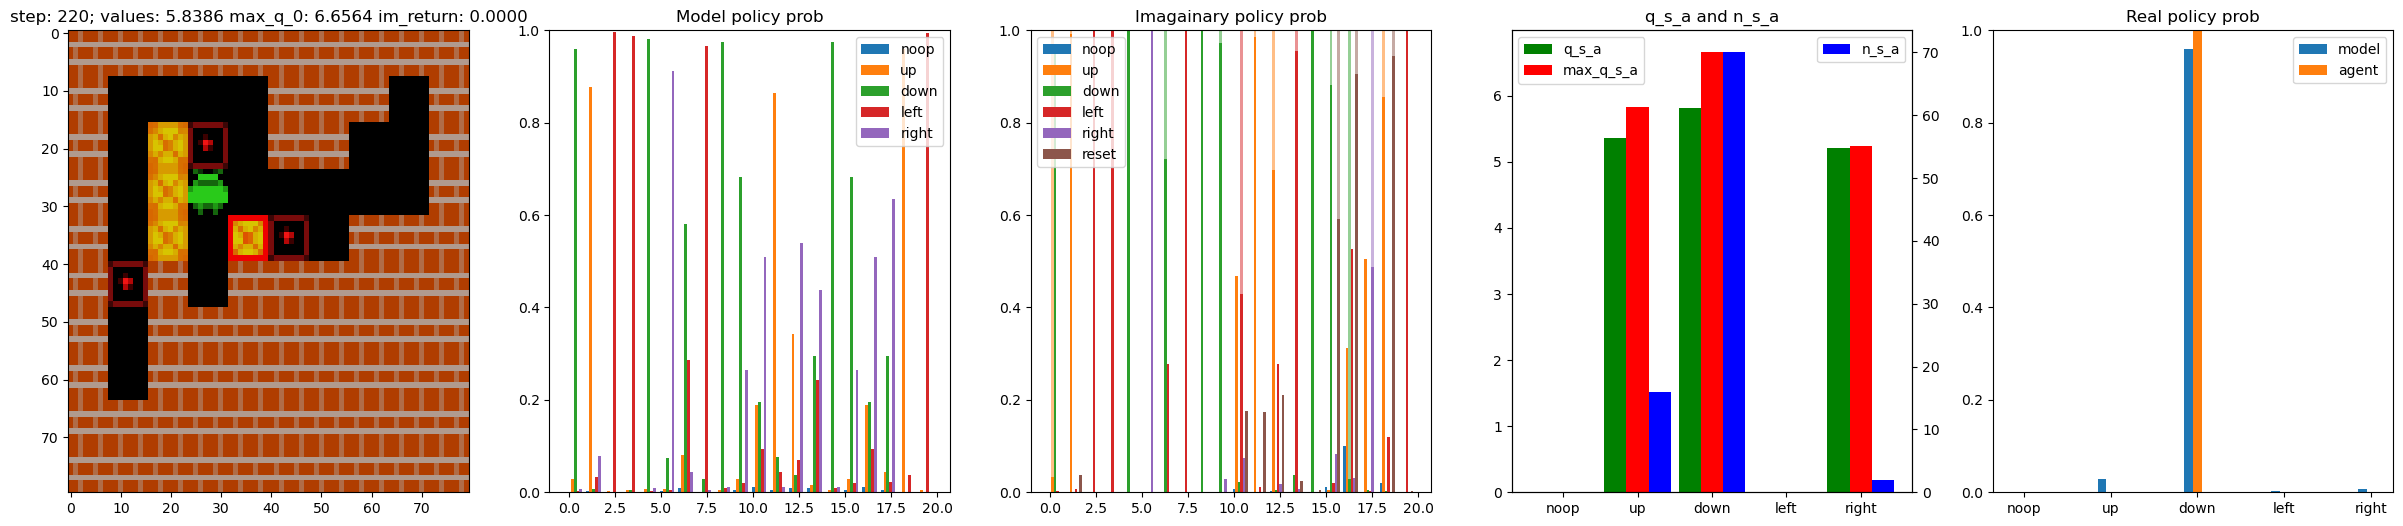

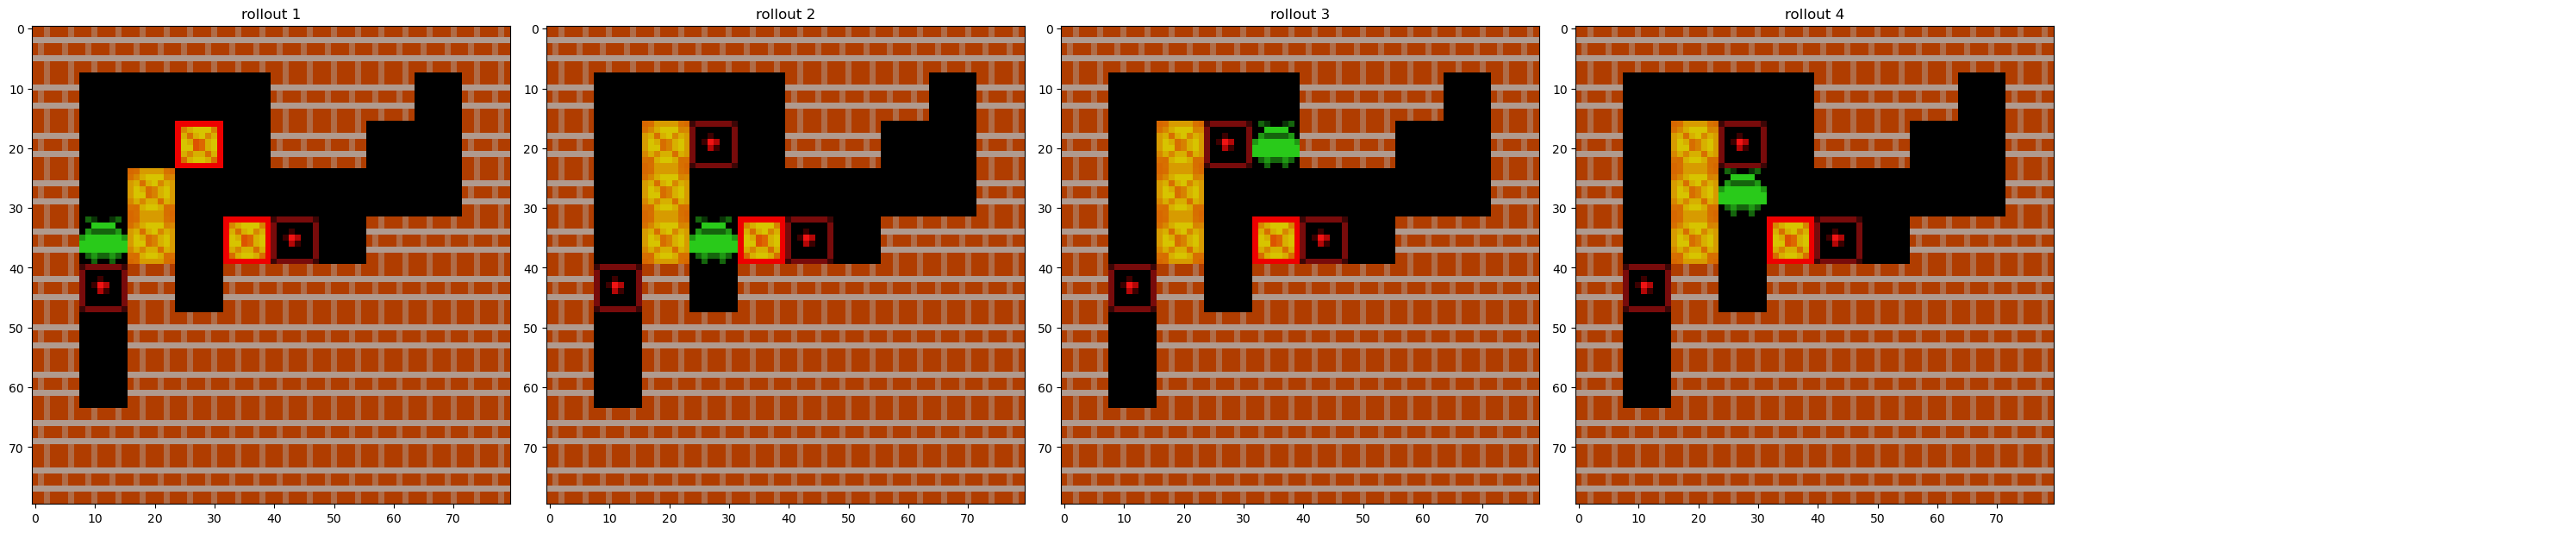

1: Up, Up, Left, Left, Down, Right, Down, Left, Down, Down, Left, Up, Up, Left, Down, Down, Reset
2: Down, Reset
3: Right, Up, Reset


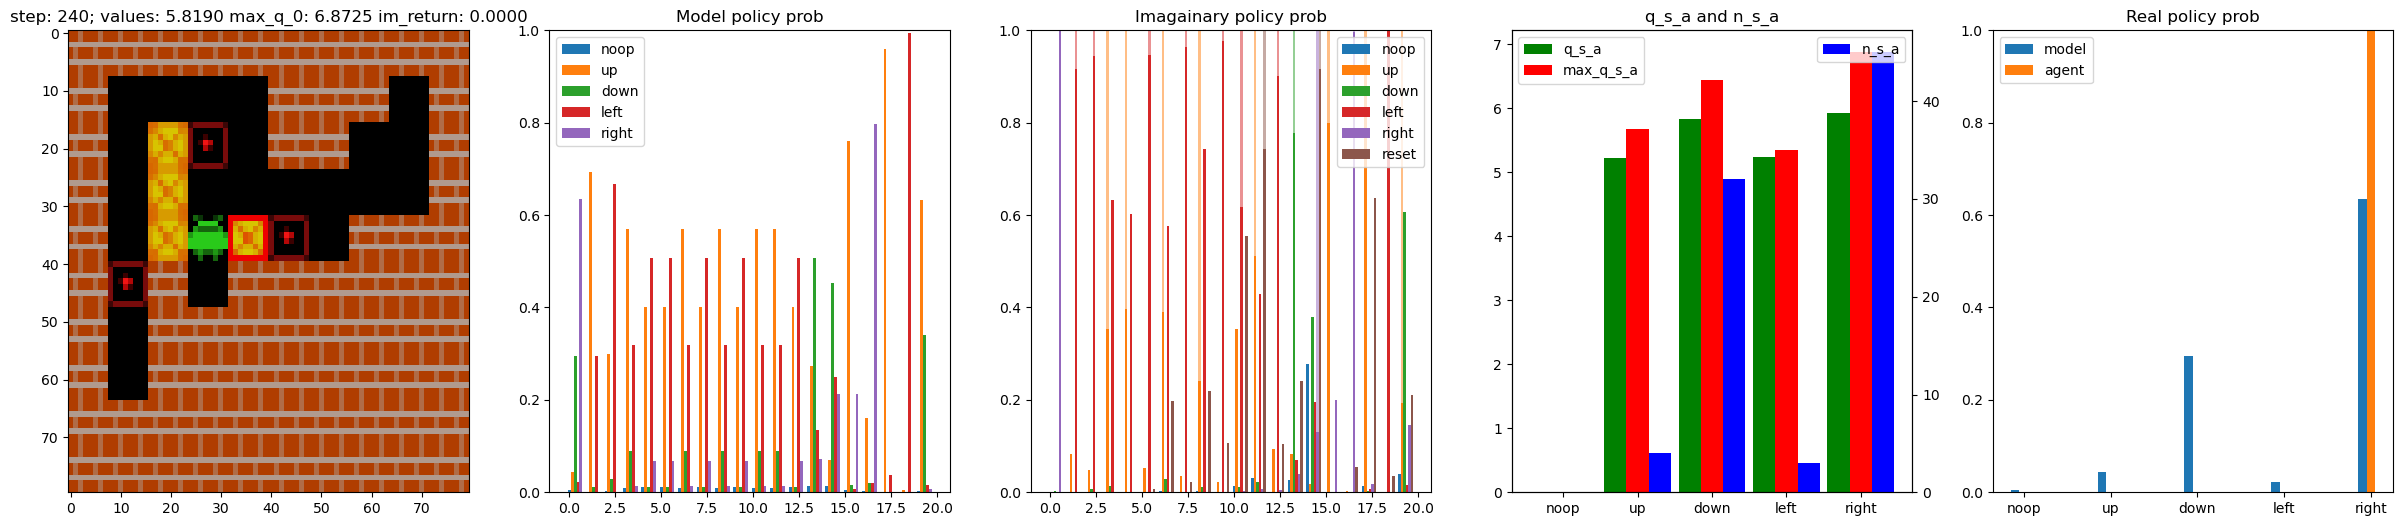

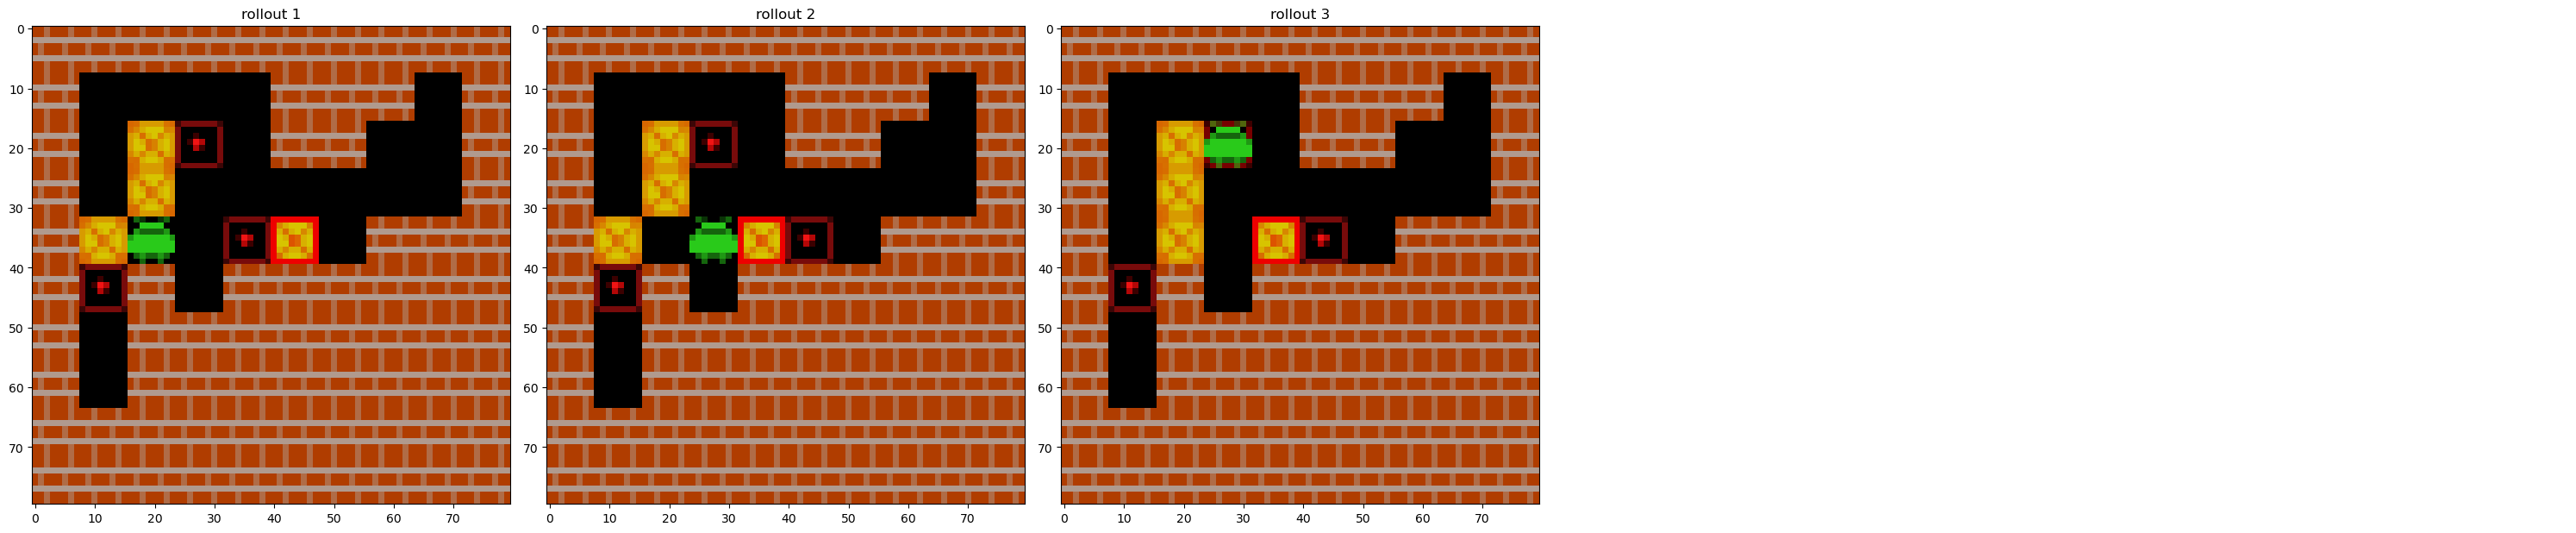

1: Right, Left, Left, Up, Up, Left, Up, Left, Up, Left, Left, Up, Reset
2: Left, Down, Right, Reset
3: Up, Right, Up, Left


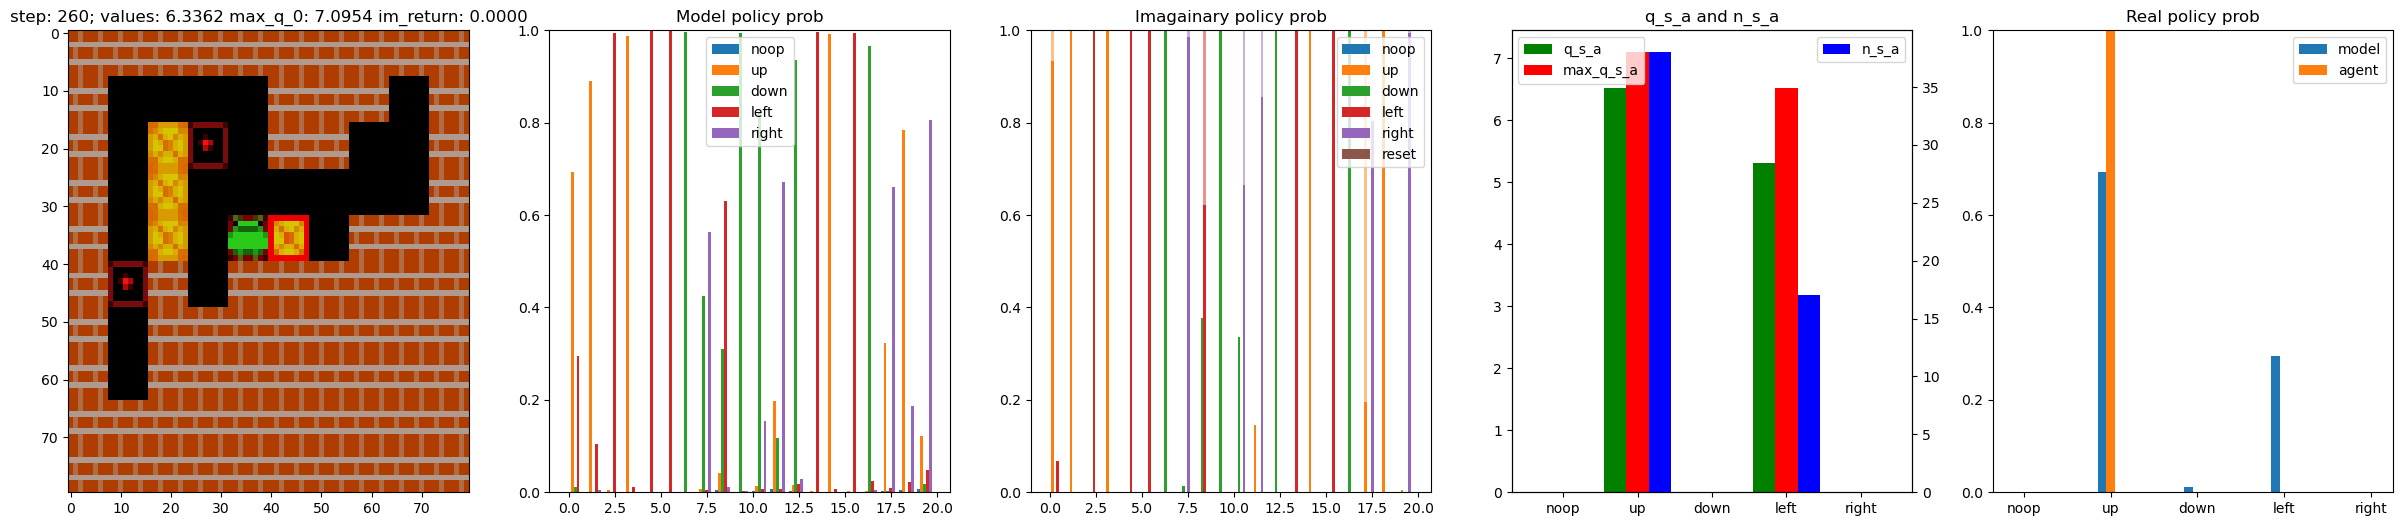

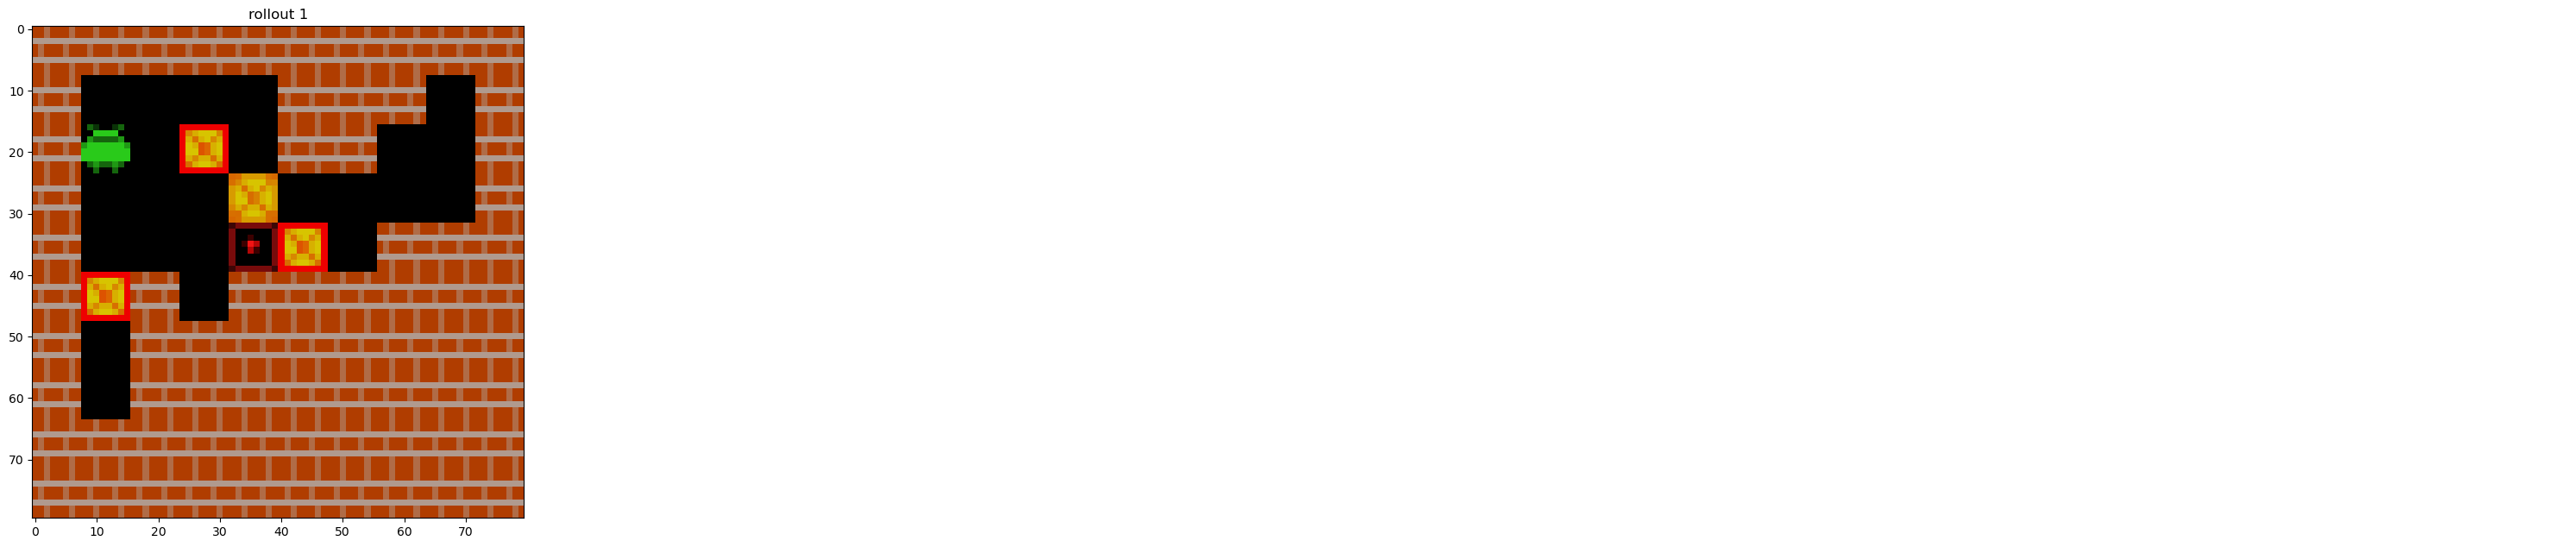

1: Up, Up, Left, Up, Left, Left, Down, Right, Left, Down, Right, Right, Down, Left, Up, Left, Down, Up, Up


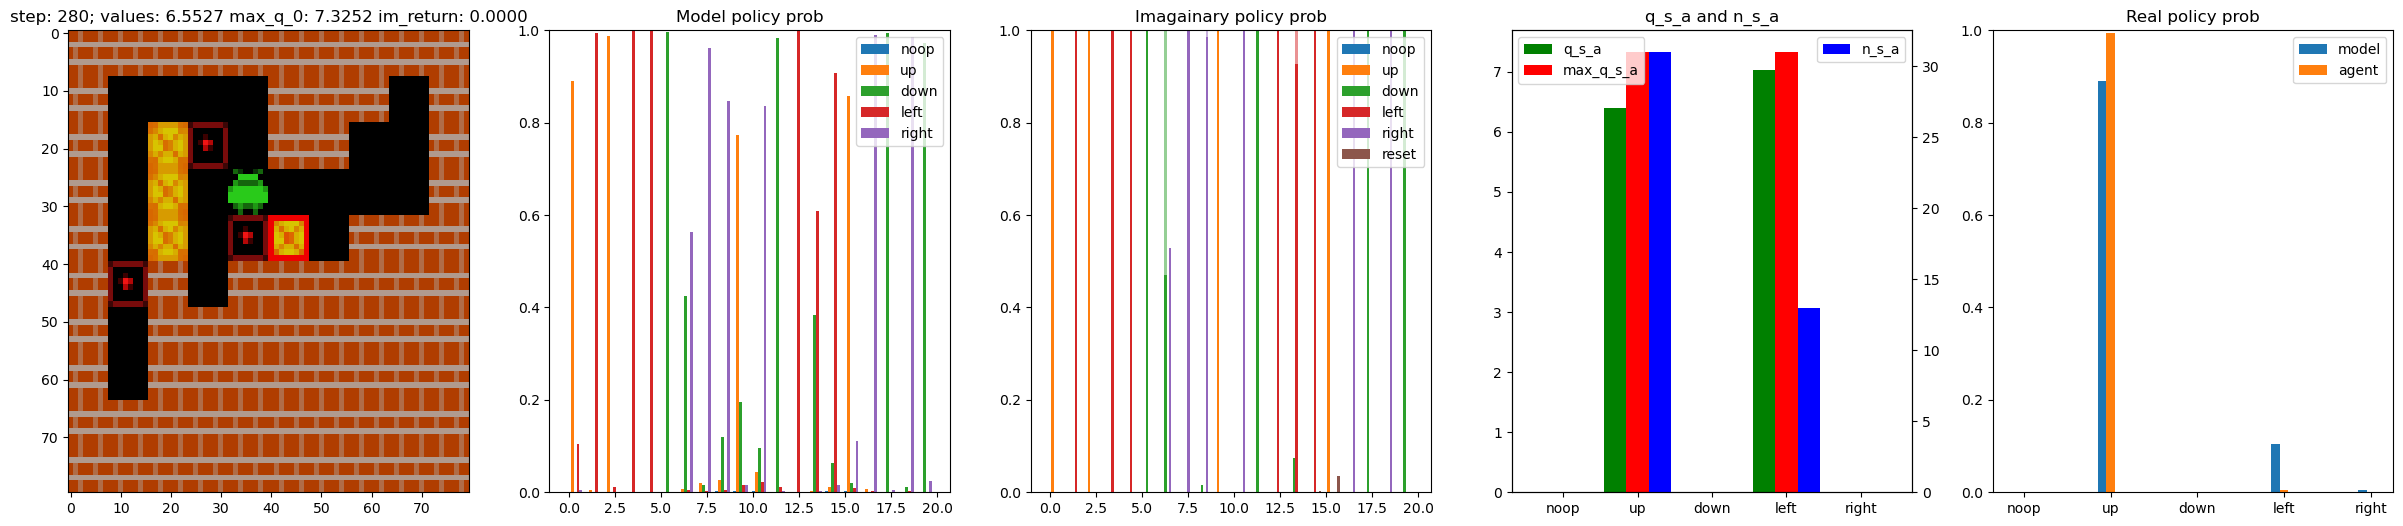

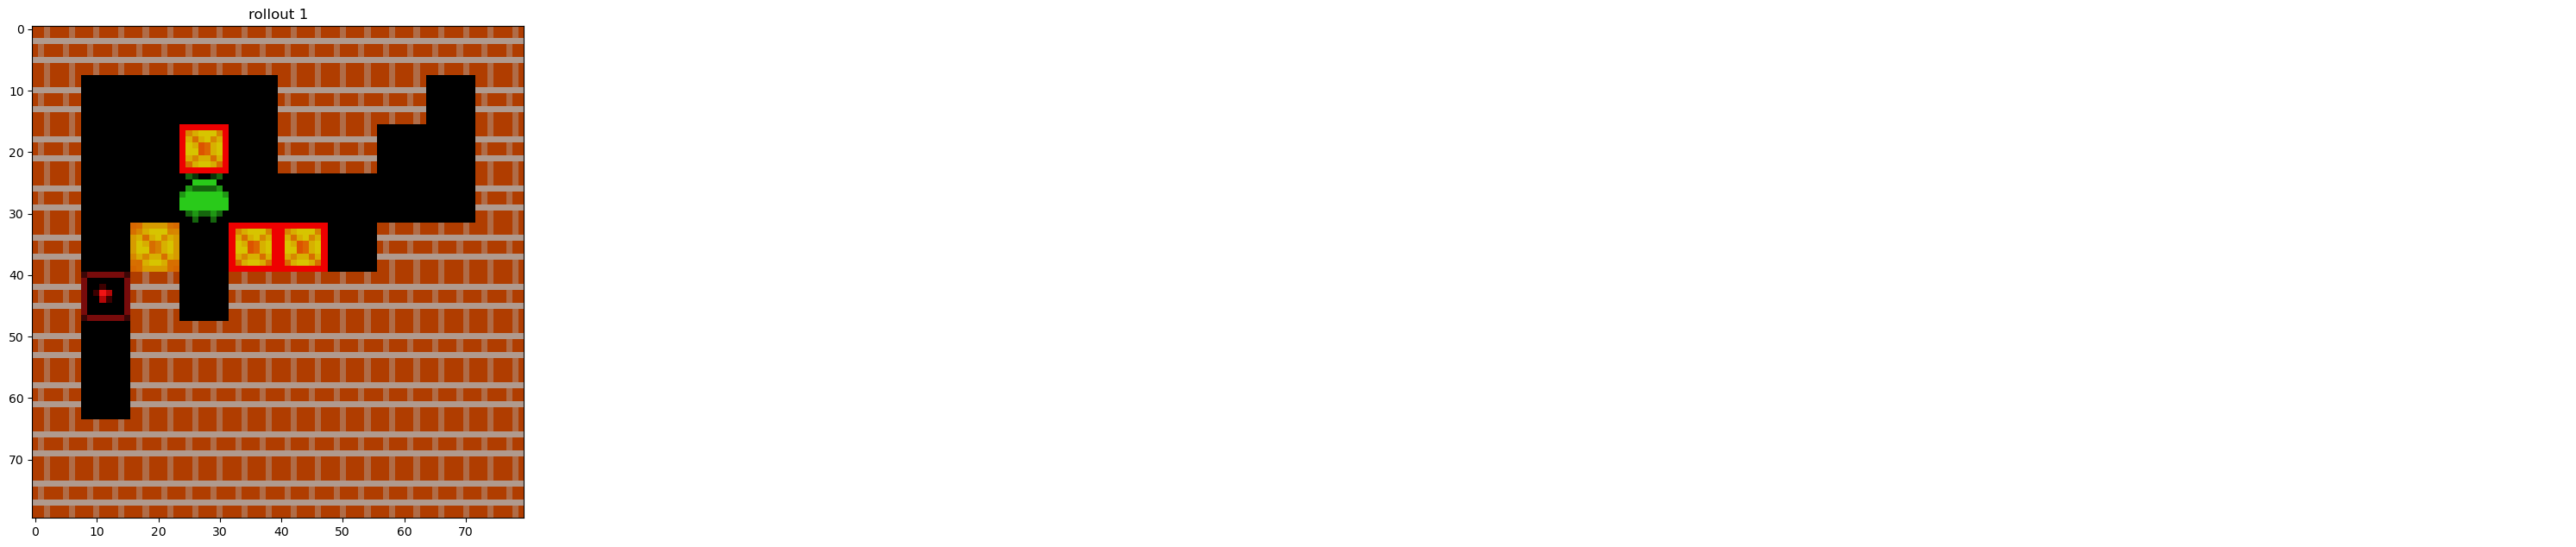

1: Up, Left, Up, Left, Left, Down, Down, Right, Right, Up, Right, Down, Left, Left, Left, Up, Right, Down, Right


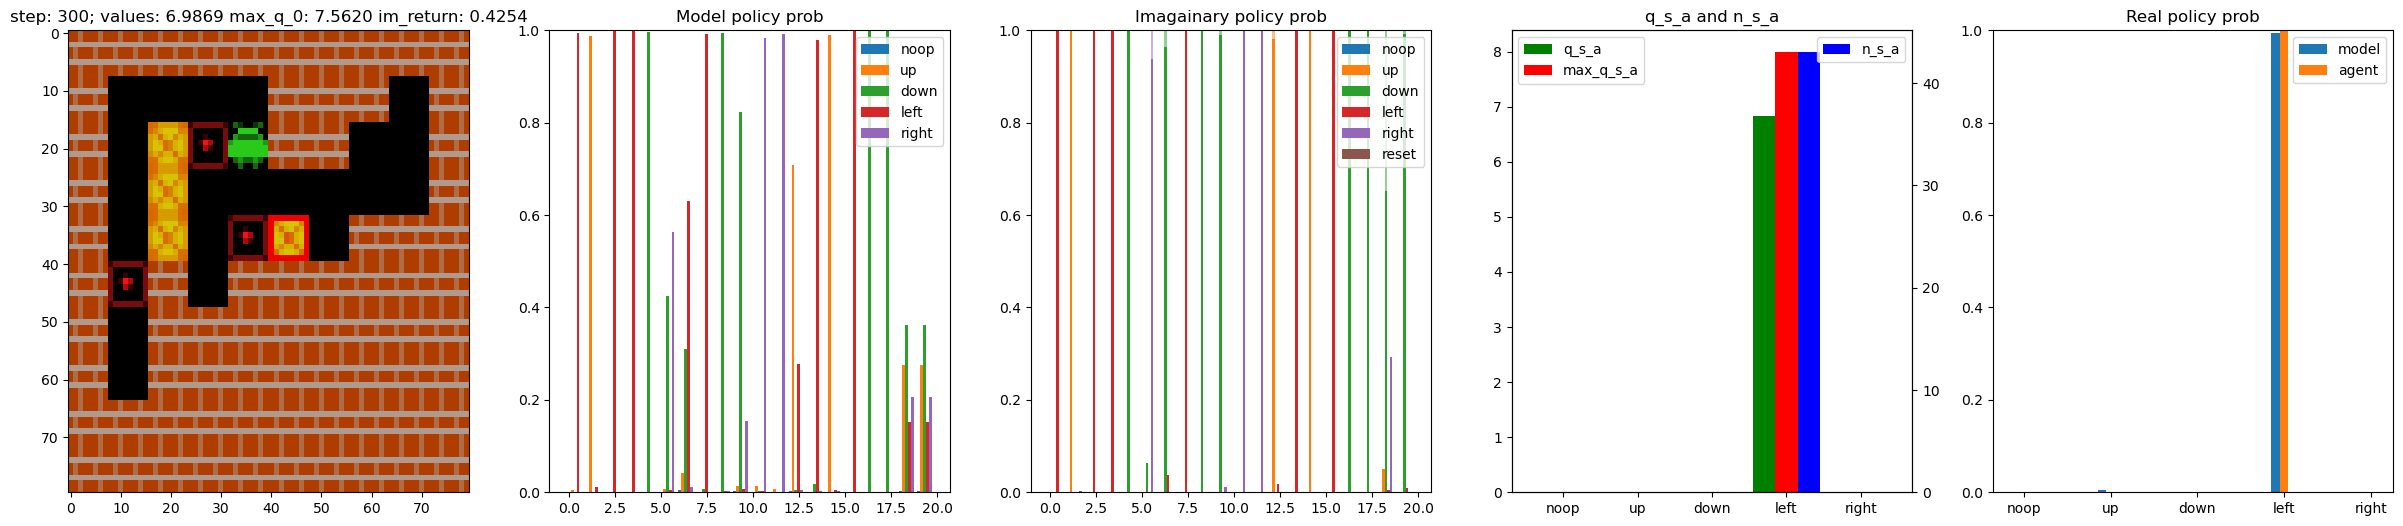

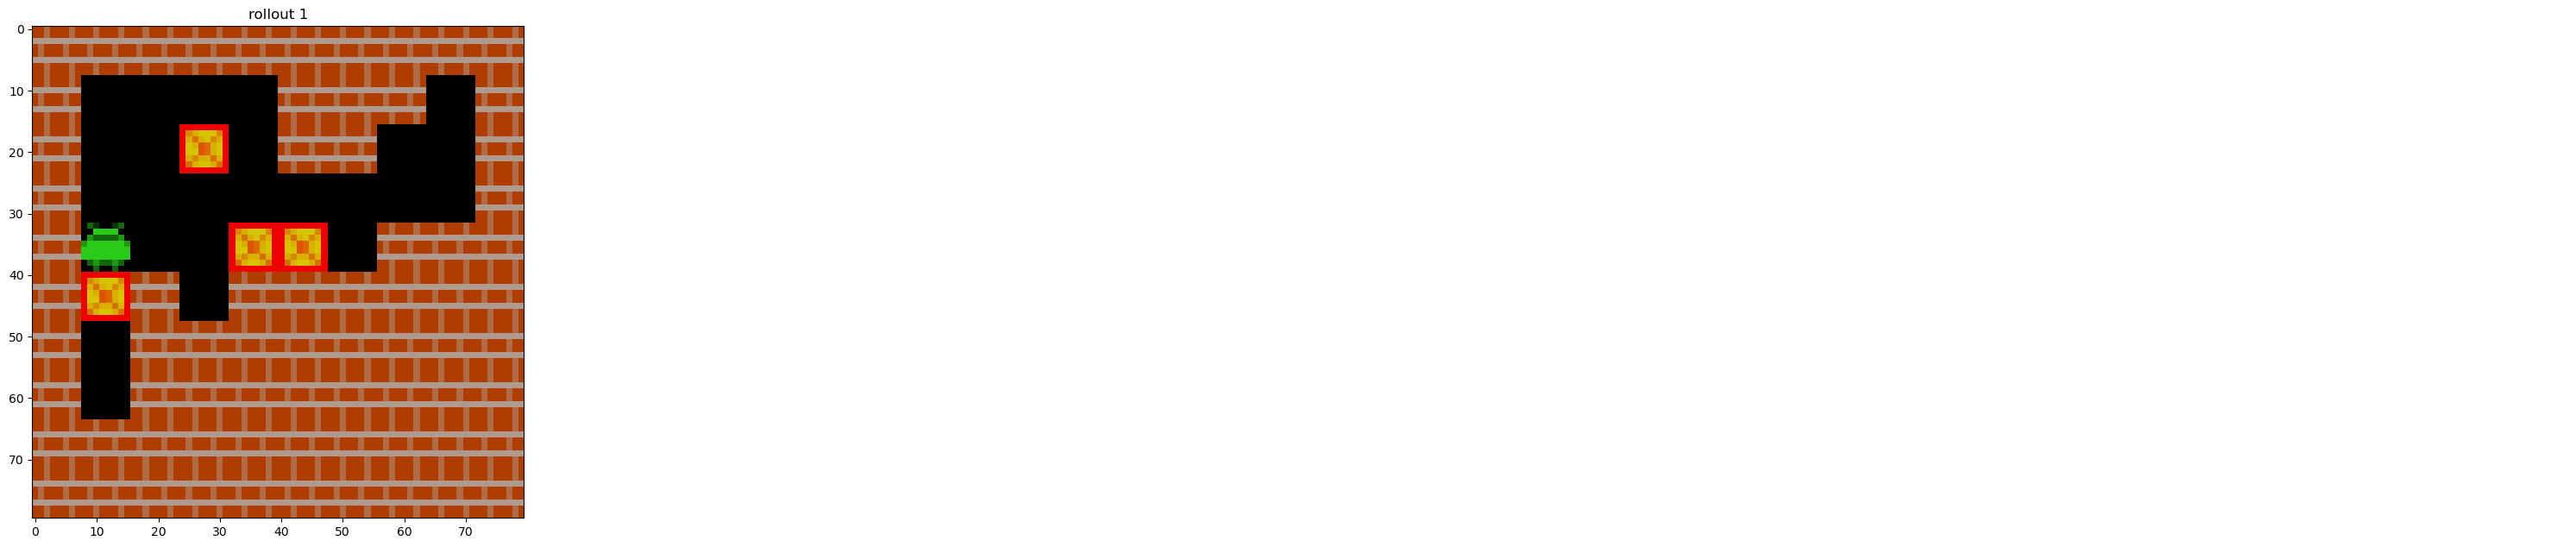

1: Left, Up, Left, Left, Down, Right, Down, Left, Down, Down, Right, Right, Up, Left, Up, Left, Down, Down, Down


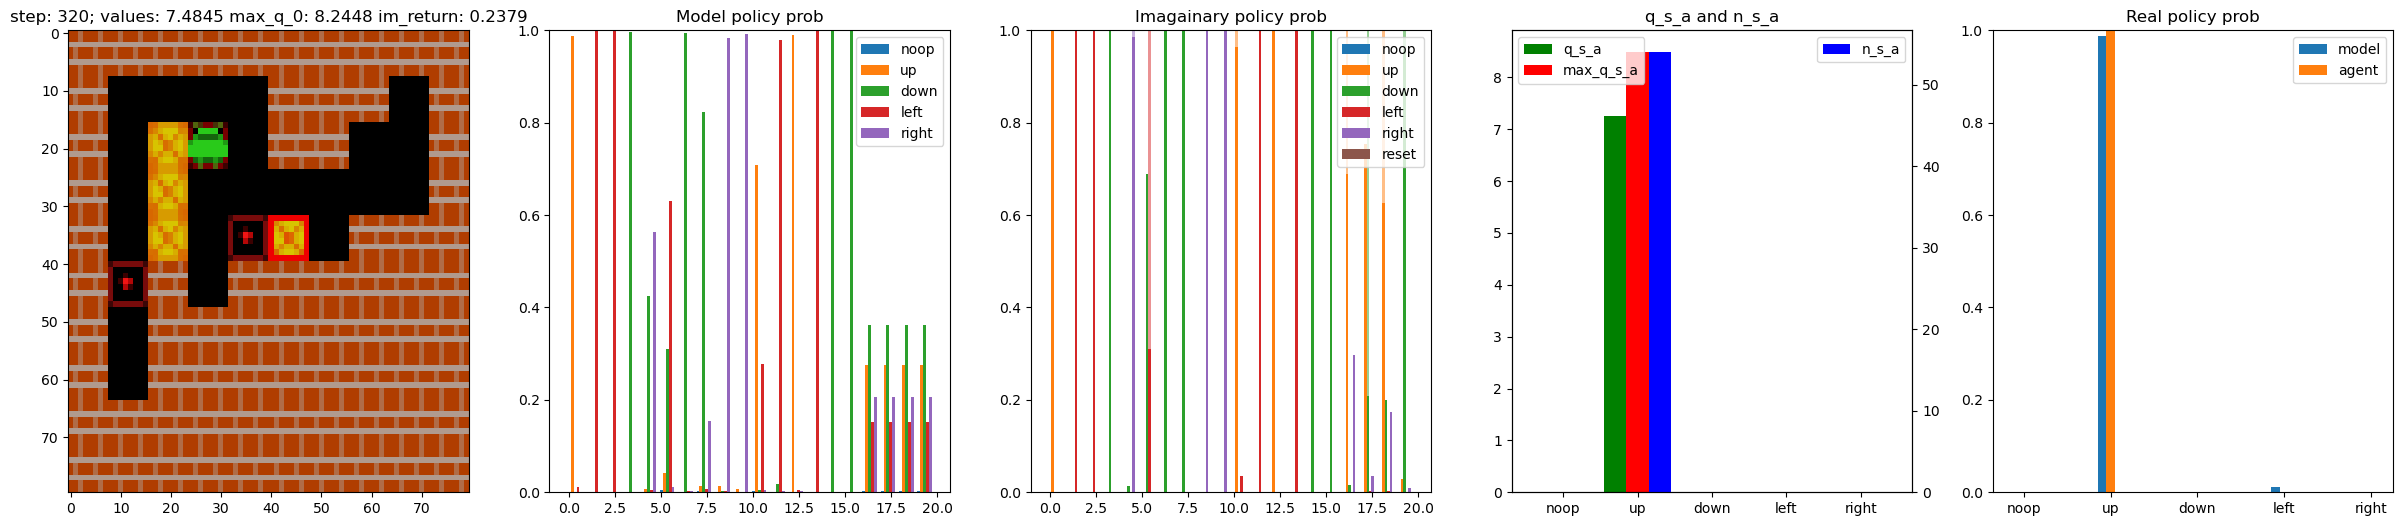

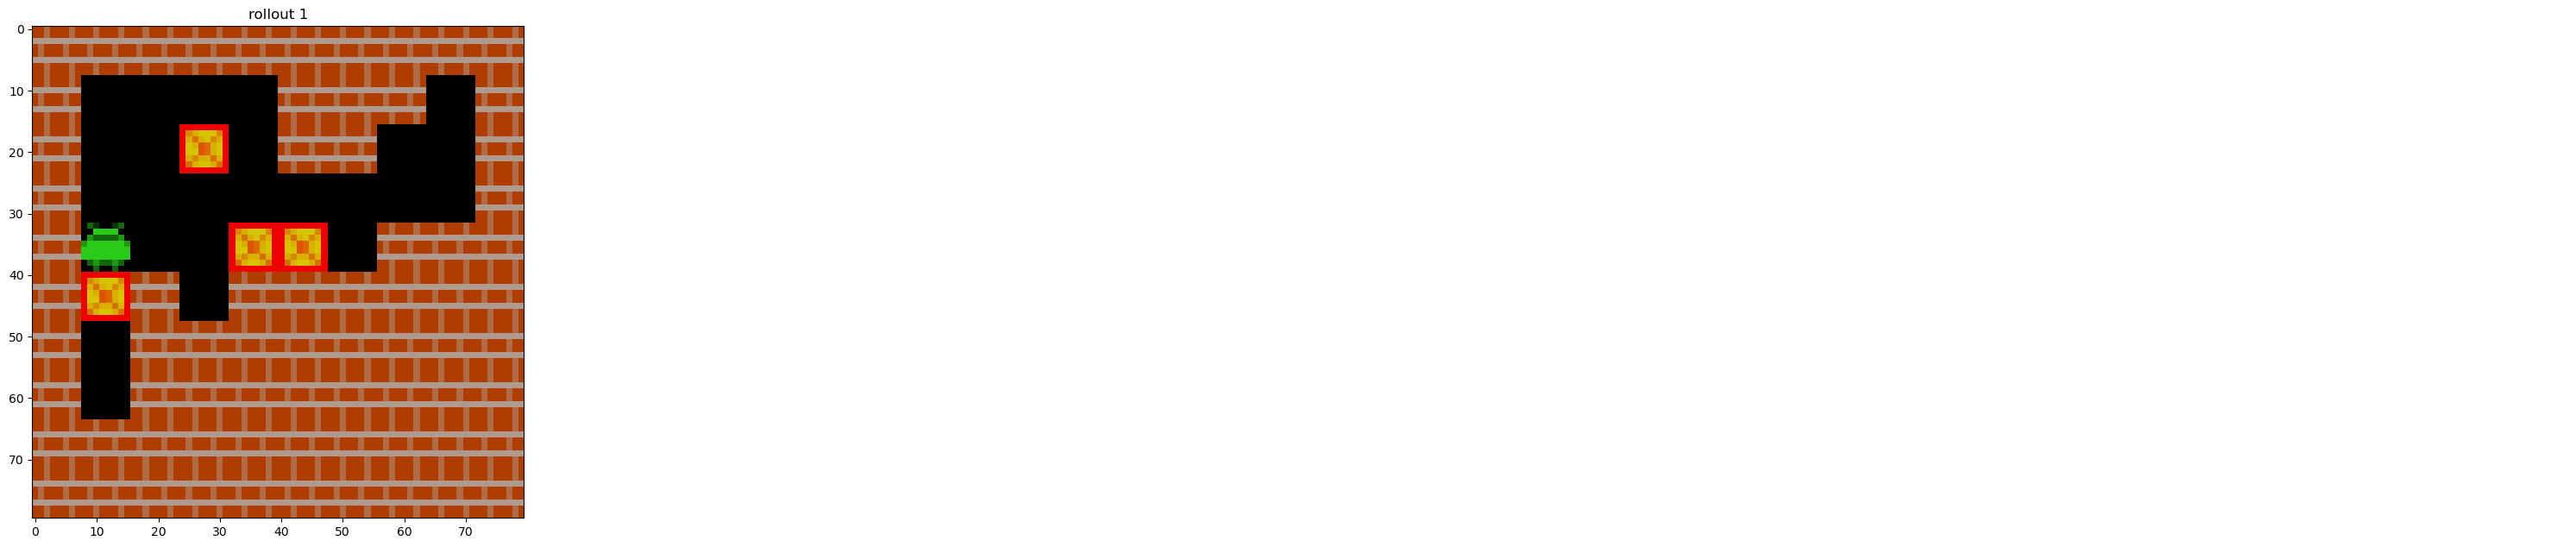

1: Up, Left, Left, Down, Right, Left, Down, Down, Right, Right, Up, Left, Up, Left, Down, Down, Up, Down, Up


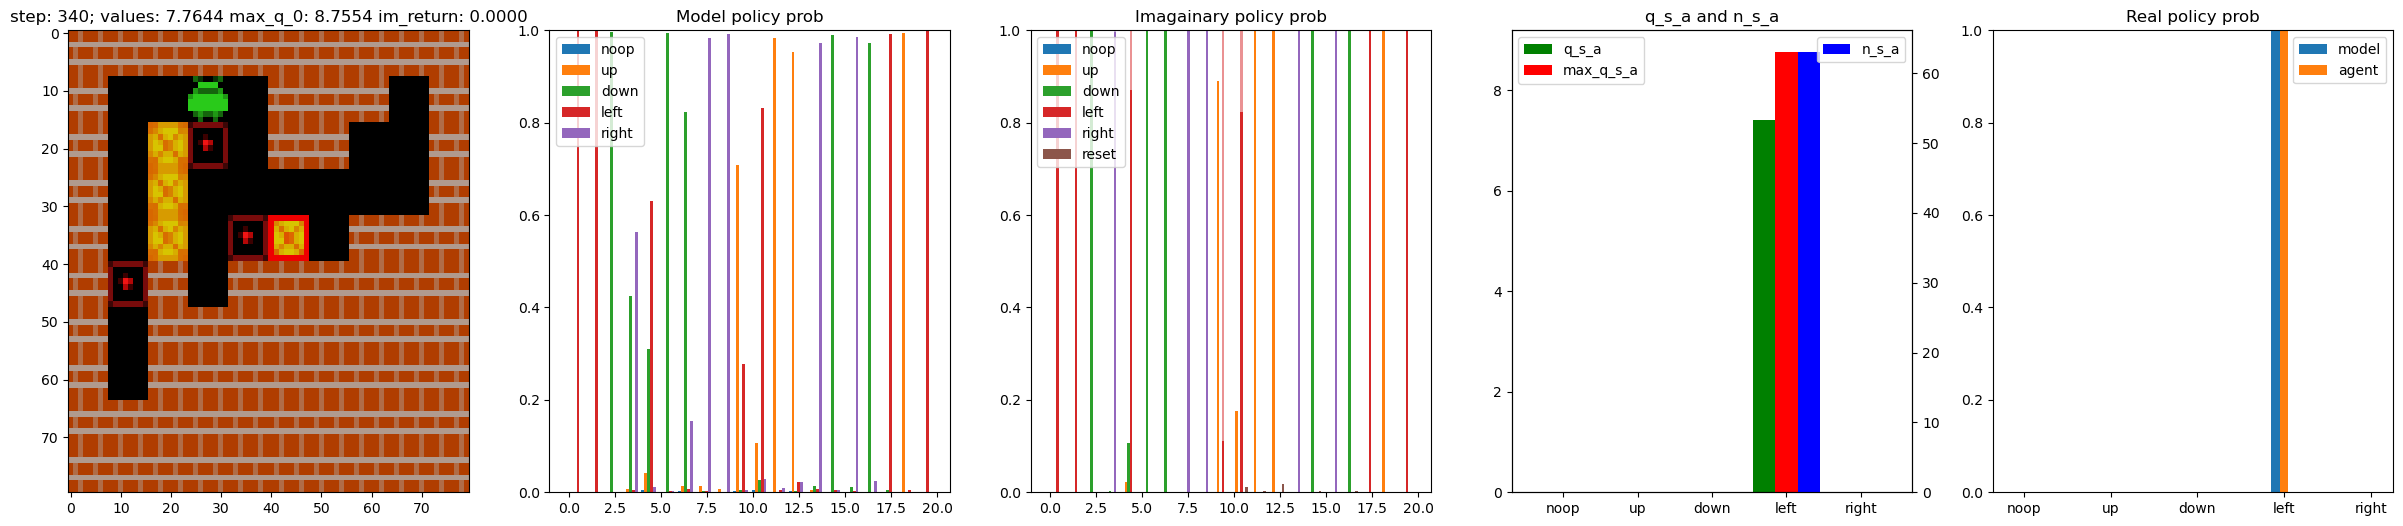

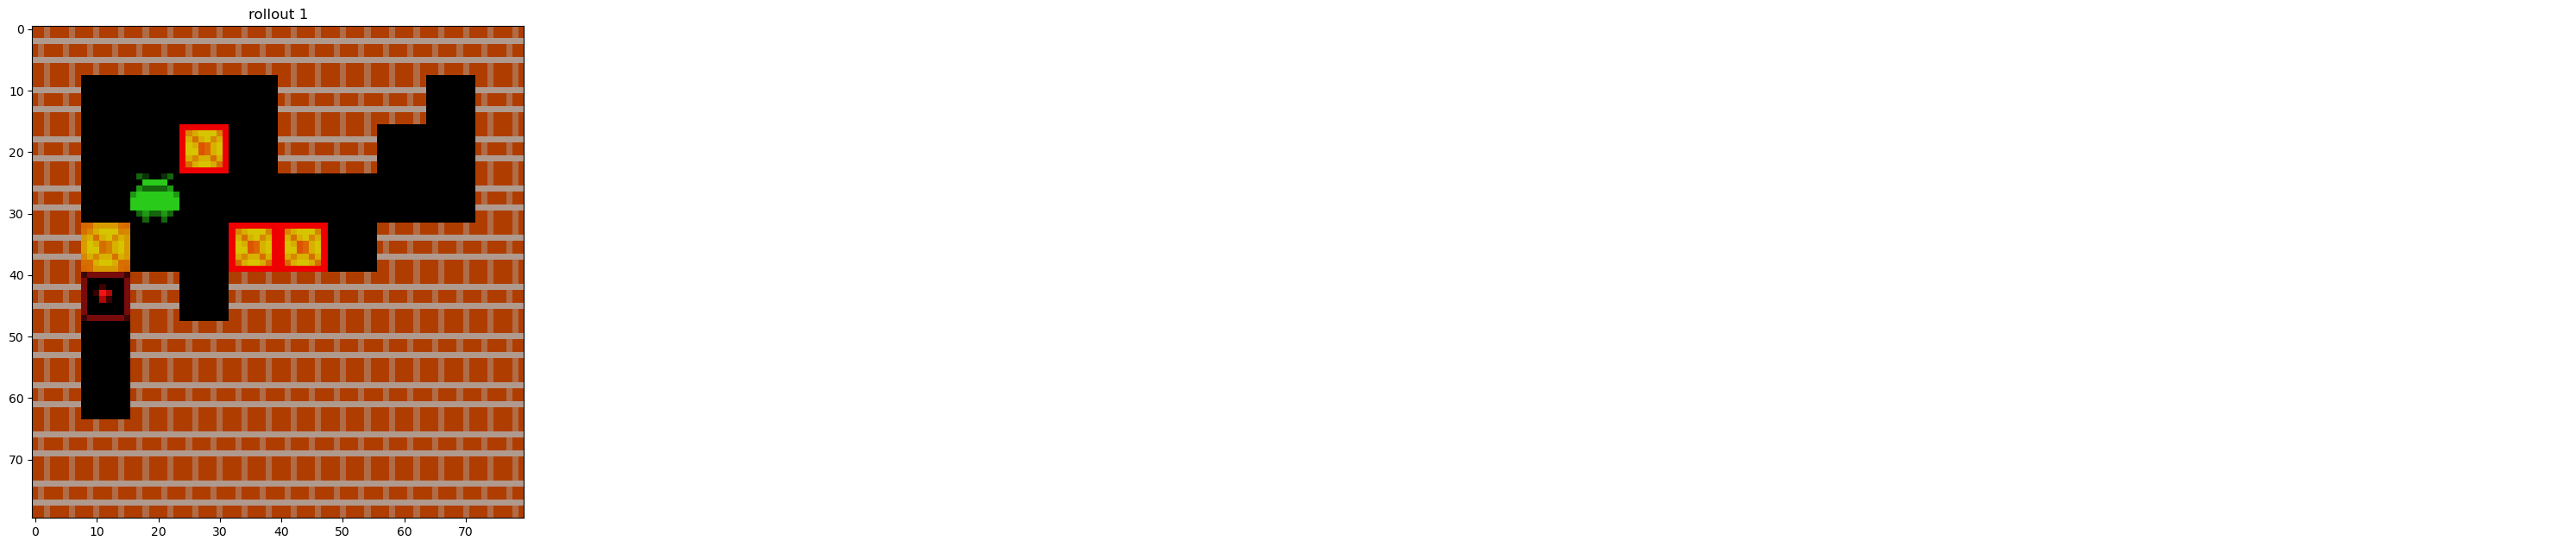

1: Left, Left, Down, Right, Left, Down, Down, Right, Right, Left, Left, Up, Up, Right, Down, Right, Down, Left, Up


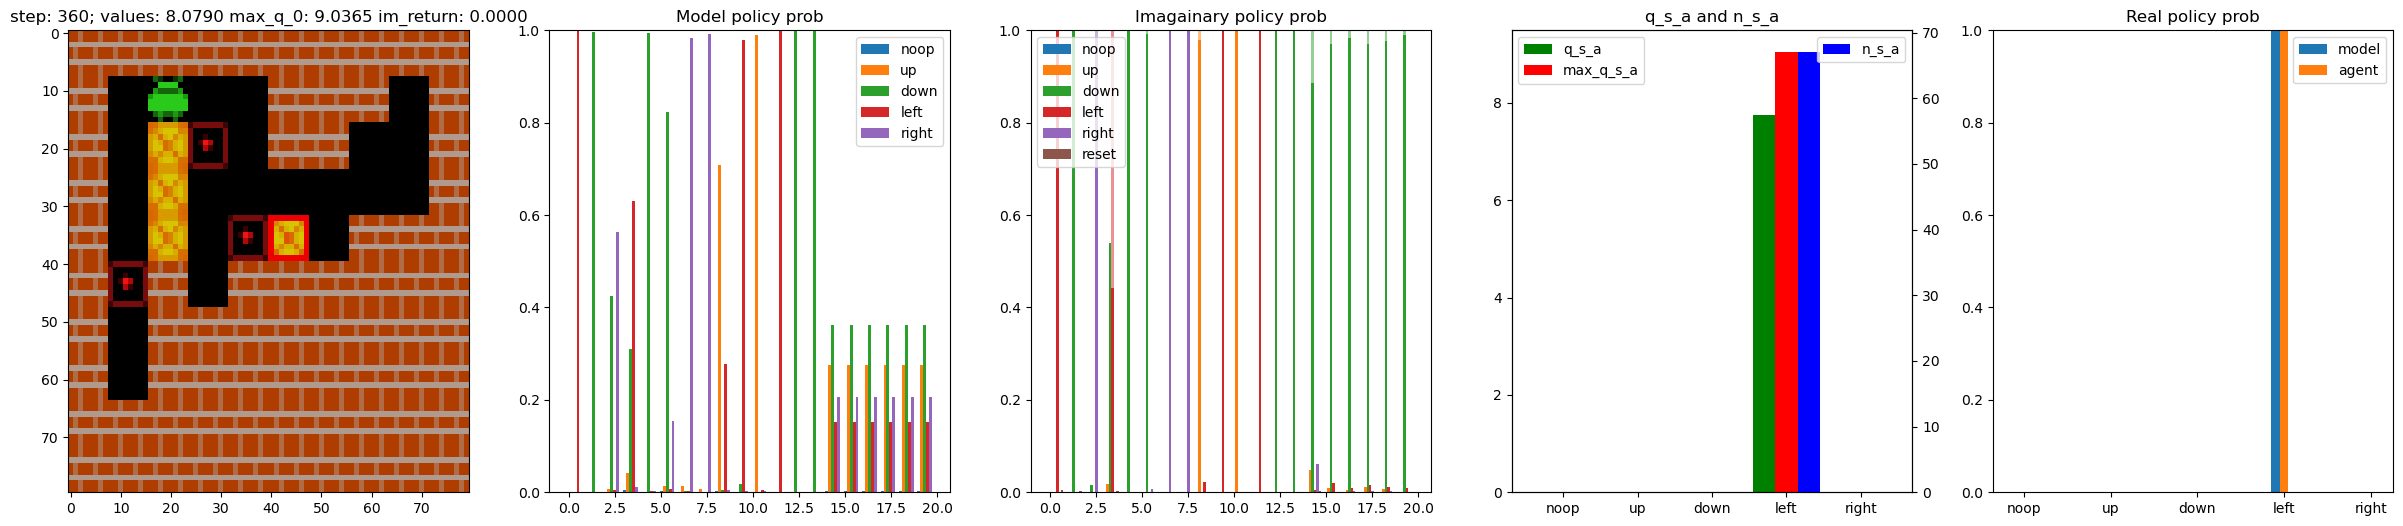

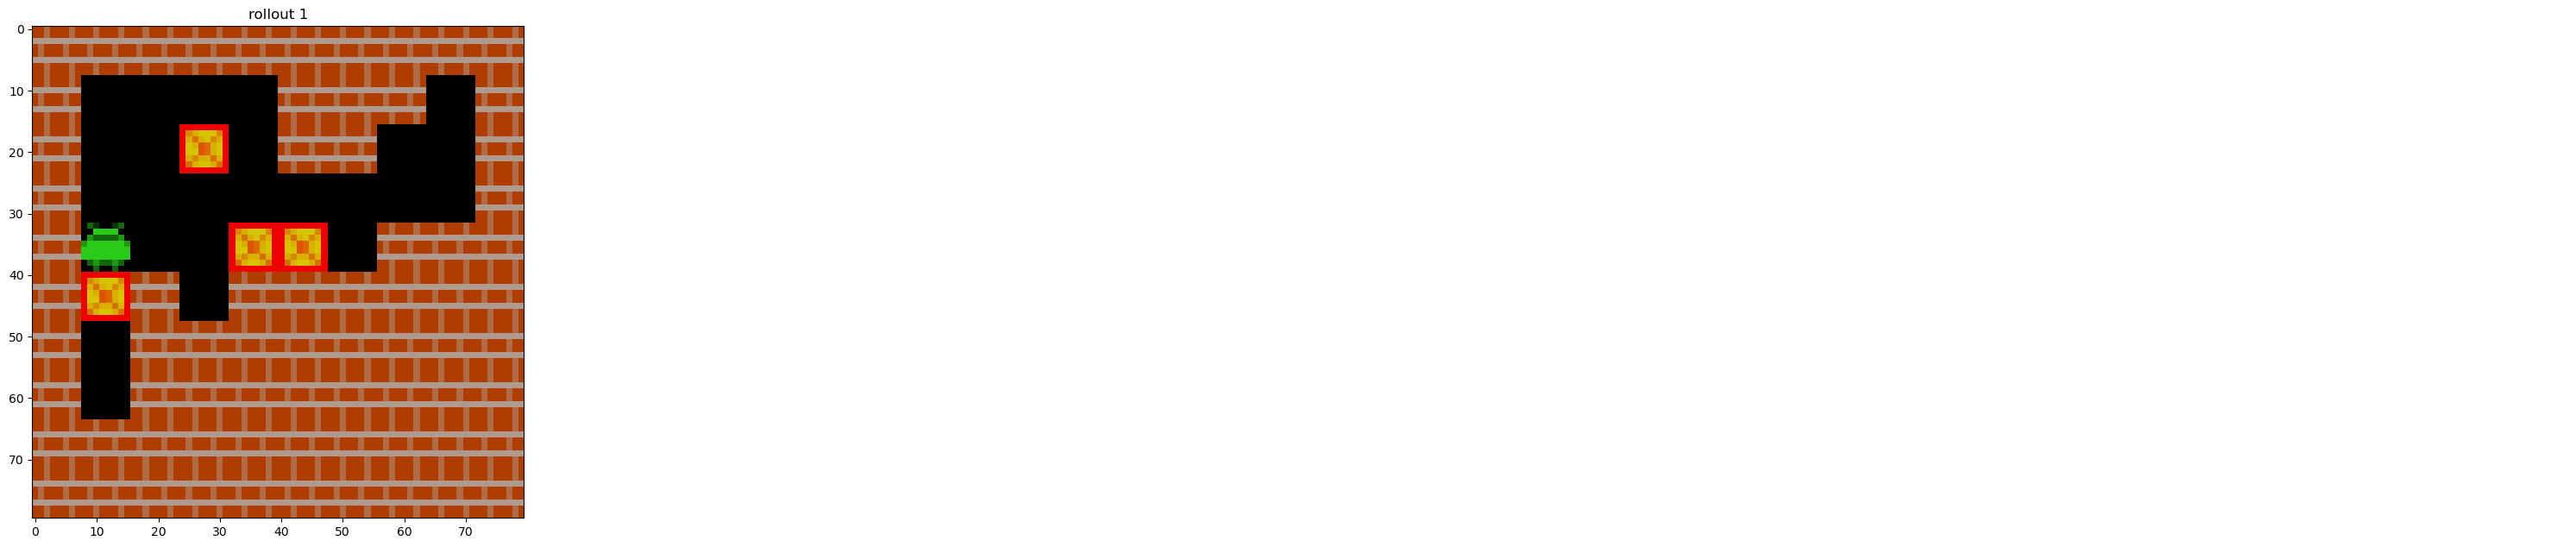

1: Left, Down, Right, Left, Down, Down, Right, Right, Up, Left, Up, Left, Down, Down, Down, Down, Down, Down, Down


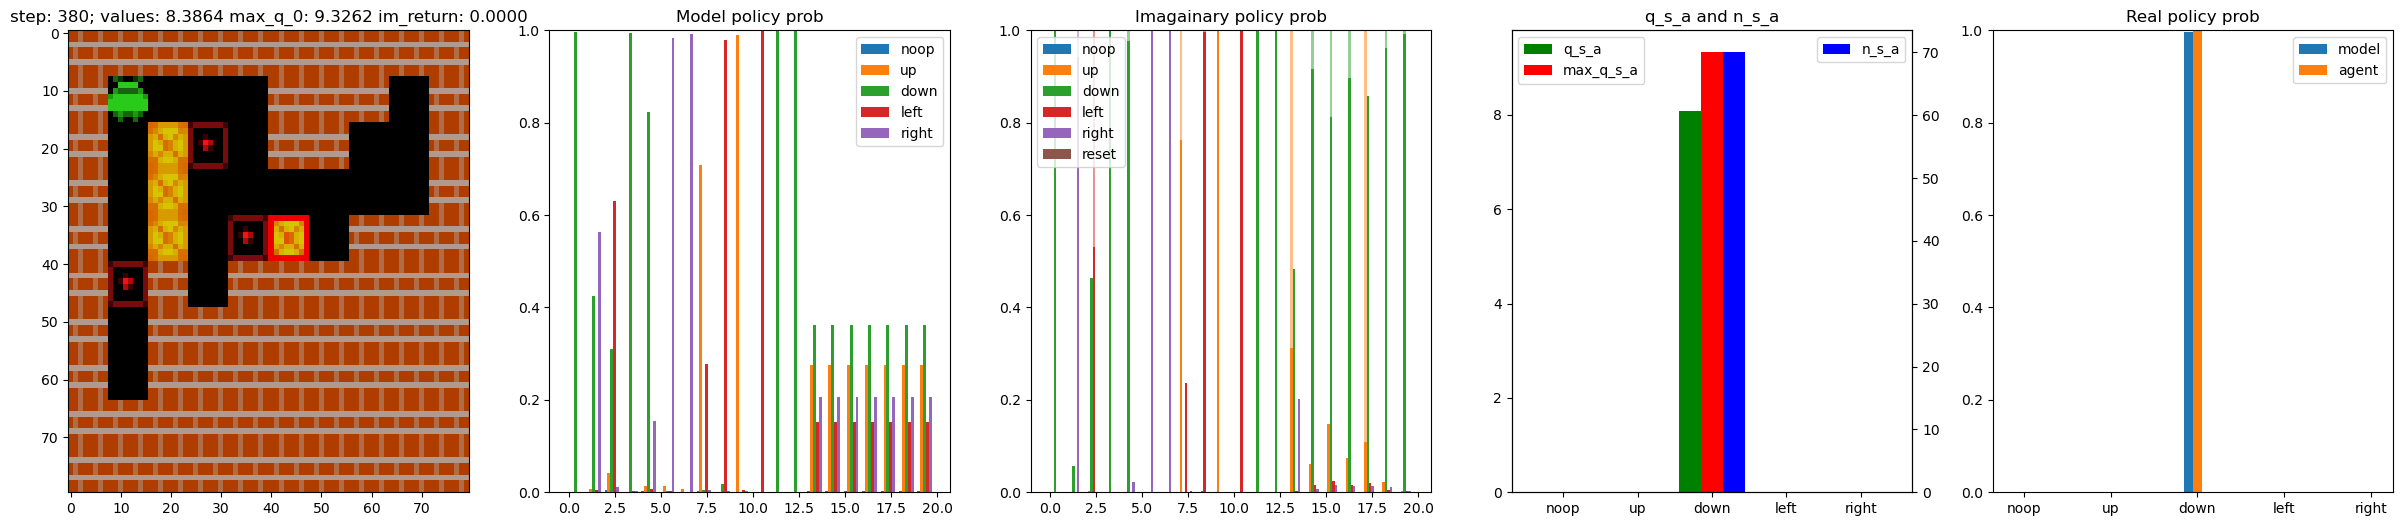

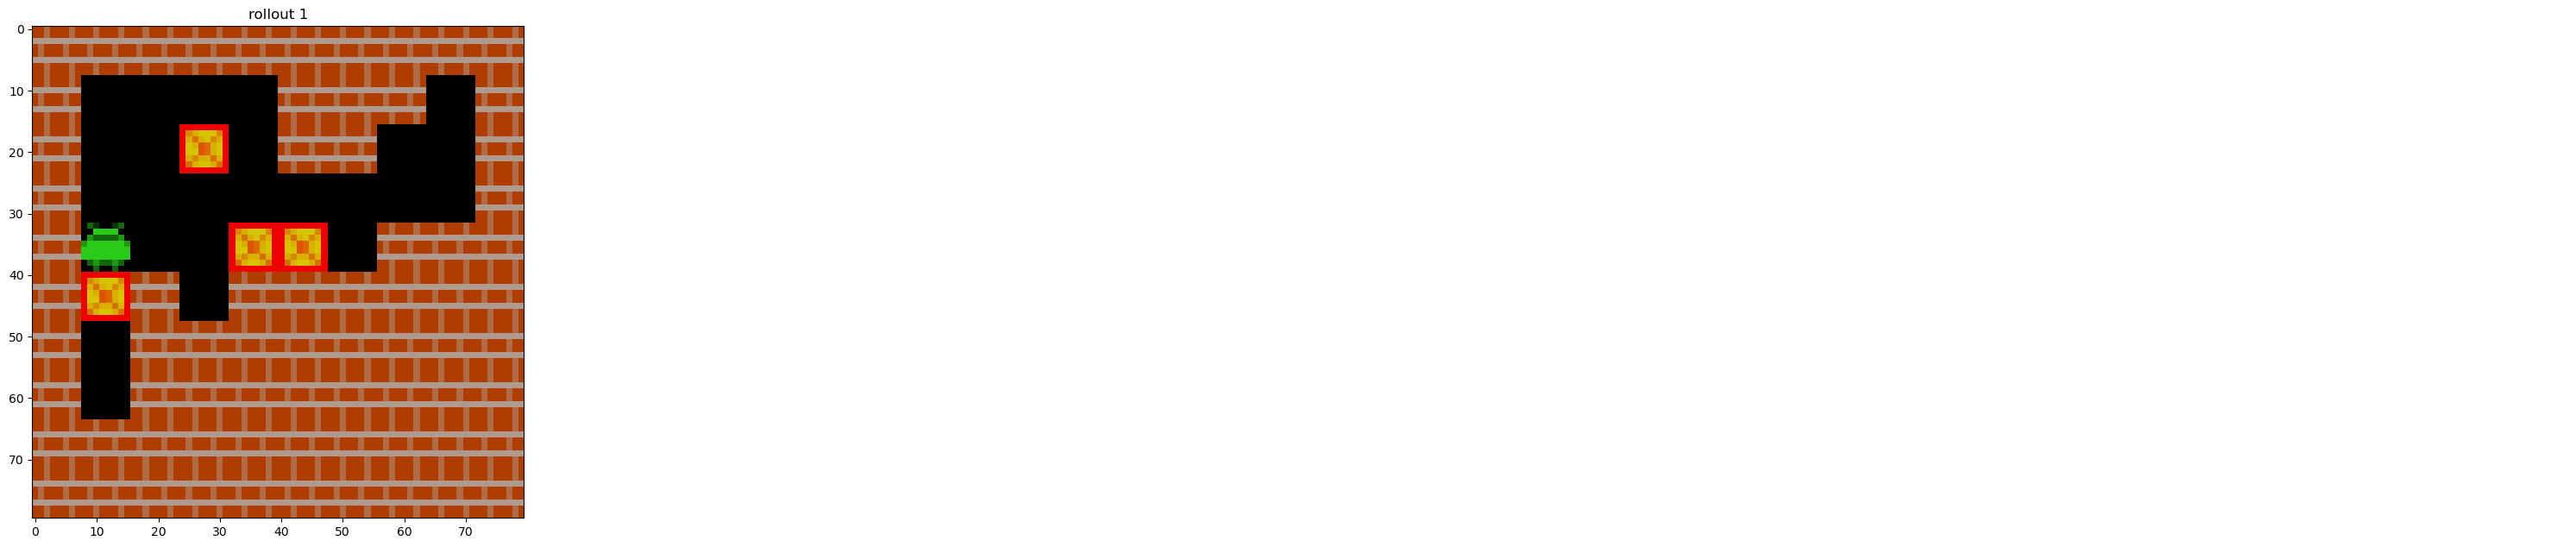

1: Down, Right, Left, Down, Down, Right, Right, Up, Left, Up, Left, Down, Down, Up, Down, Down, Down, Up, Down


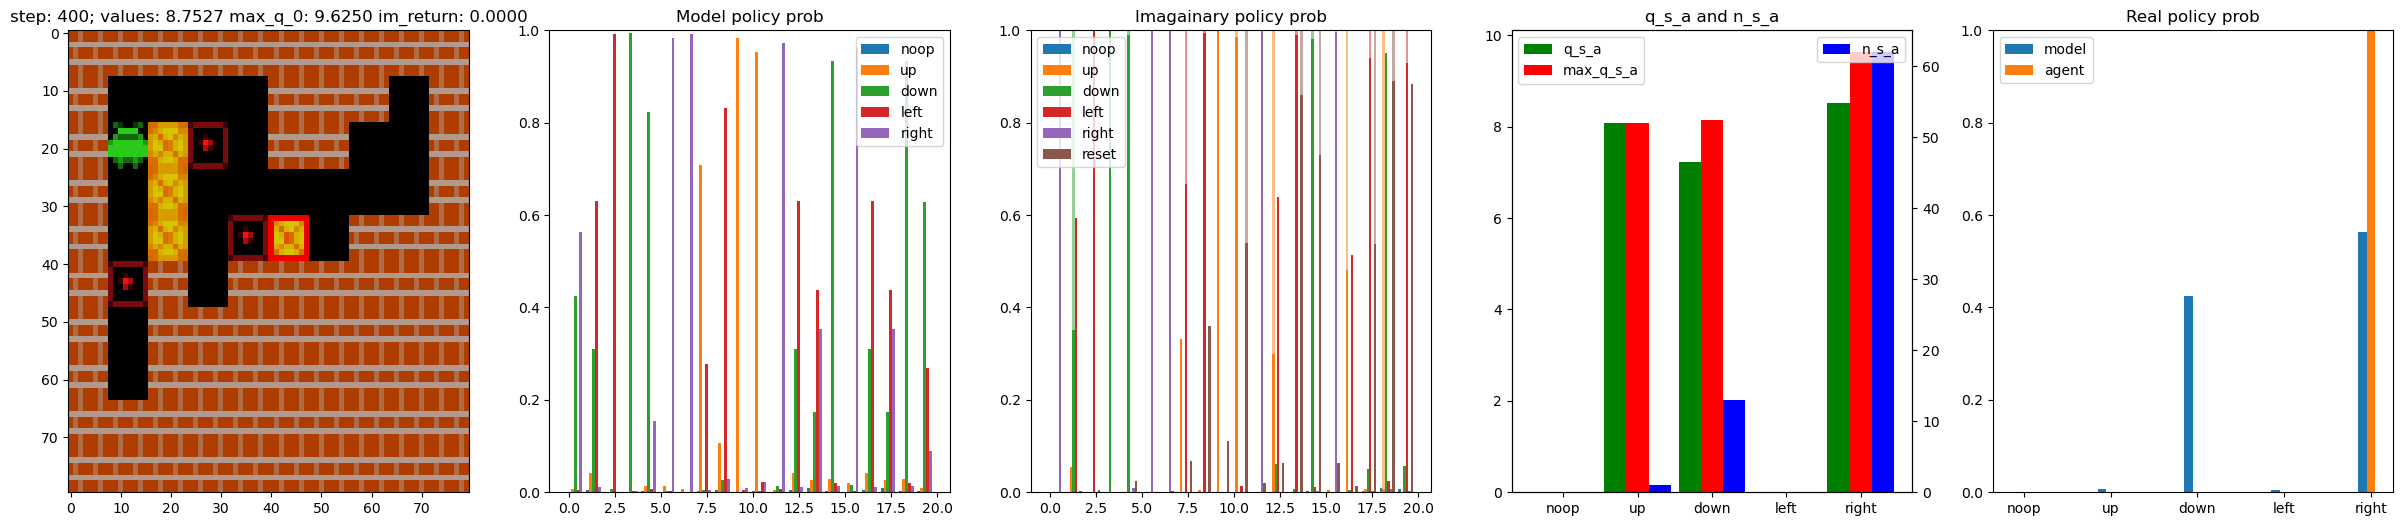

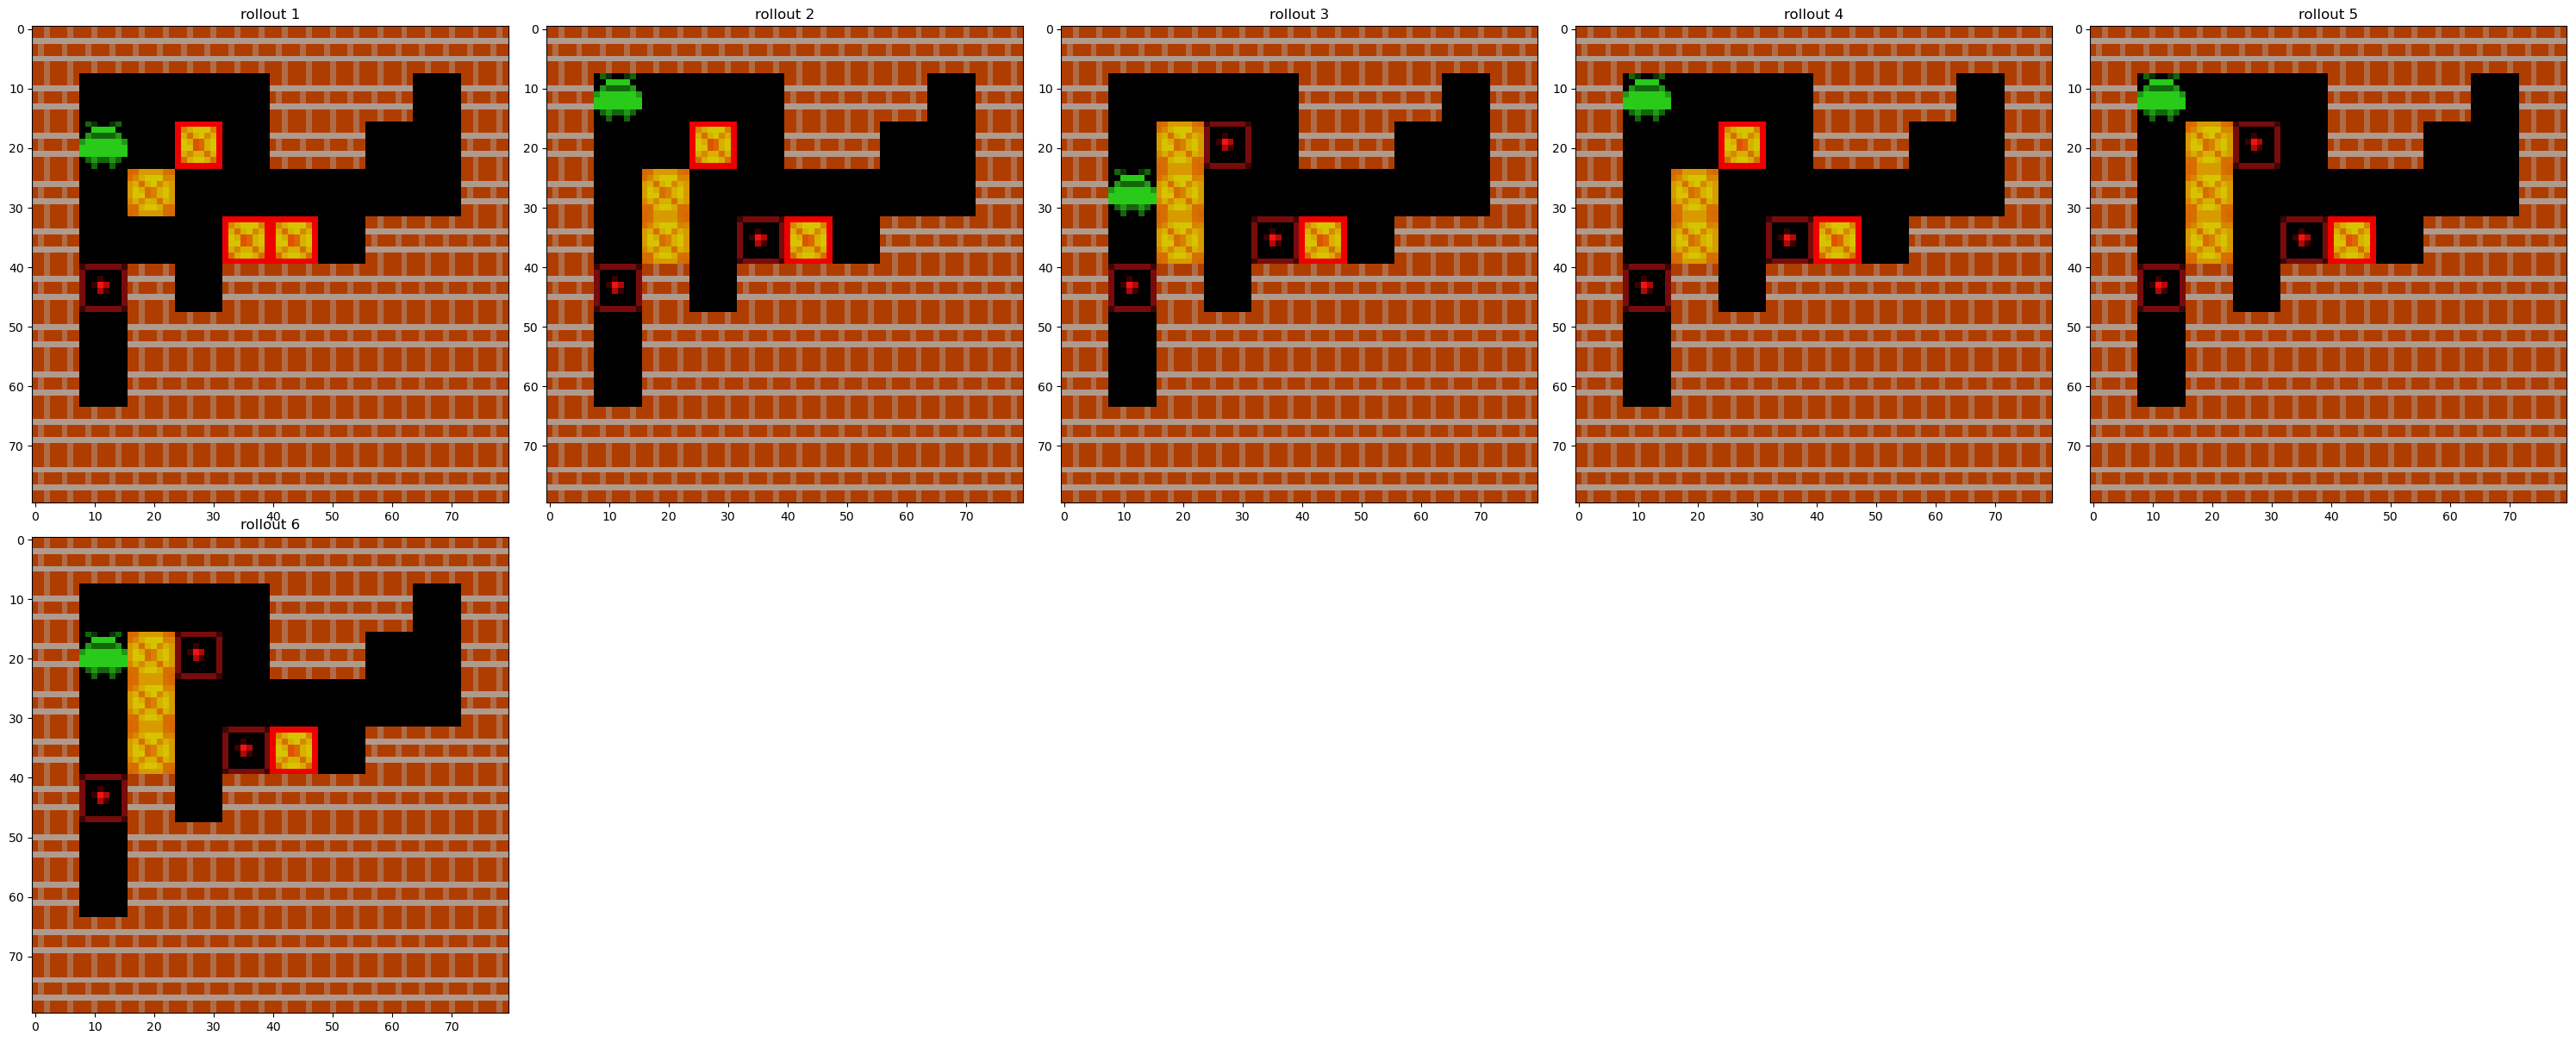

1: Right, Down, Left, Down, Down, Right, Right, Left, Left, Up, Up, Reset
2: Right, Up, Left, Reset
3: Down, Reset
4: Right, Up, Left, Reset
5: Up, Reset


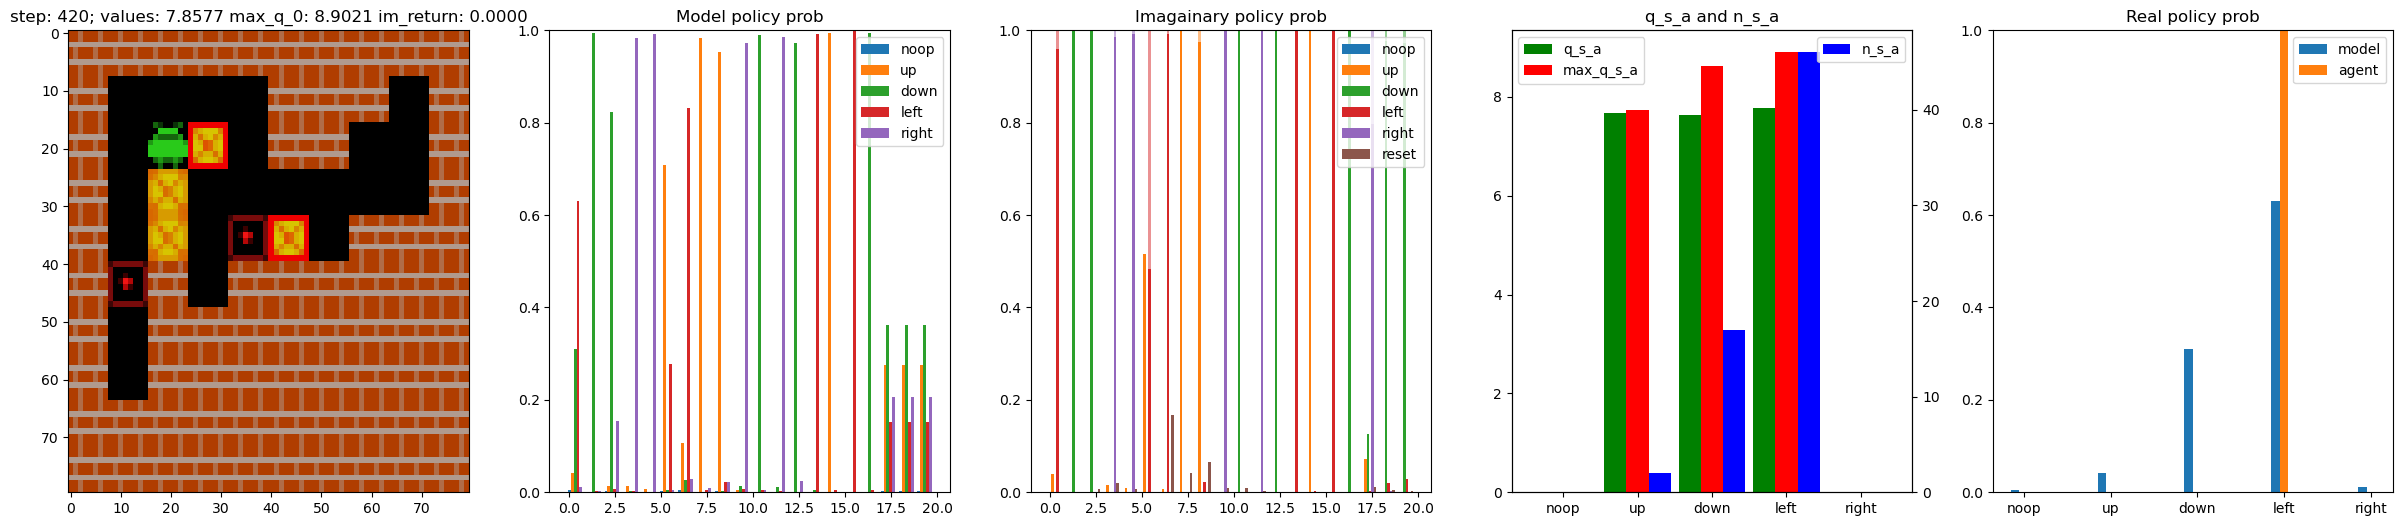

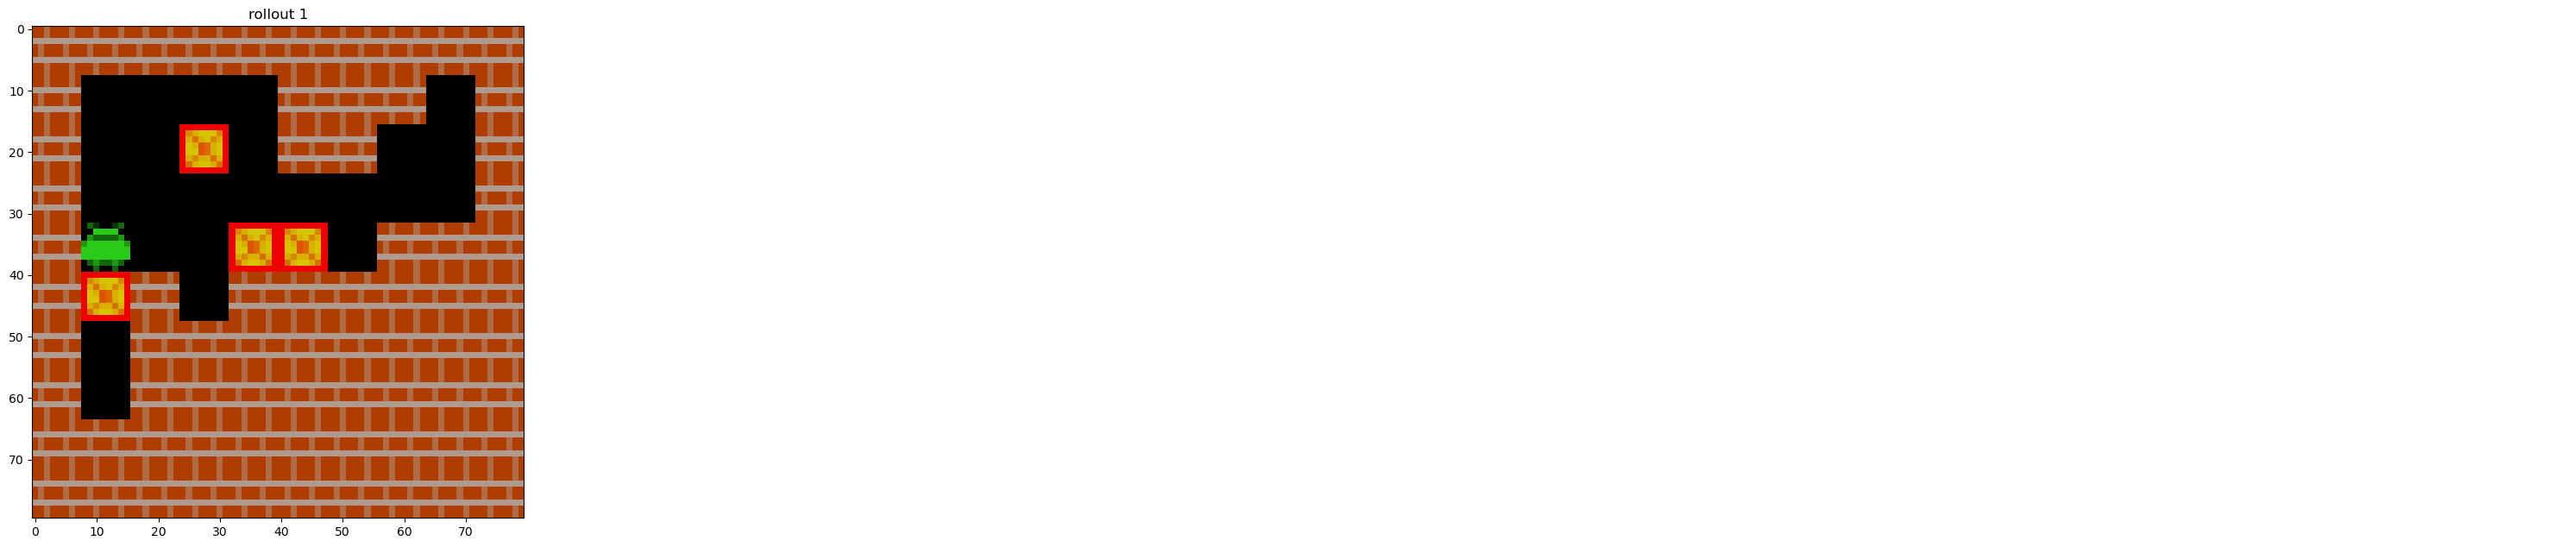

1: Left, Down, Down, Right, Right, Left, Left, Up, Up, Right, Down, Right, Down, Left, Up, Left, Down, Right, Down


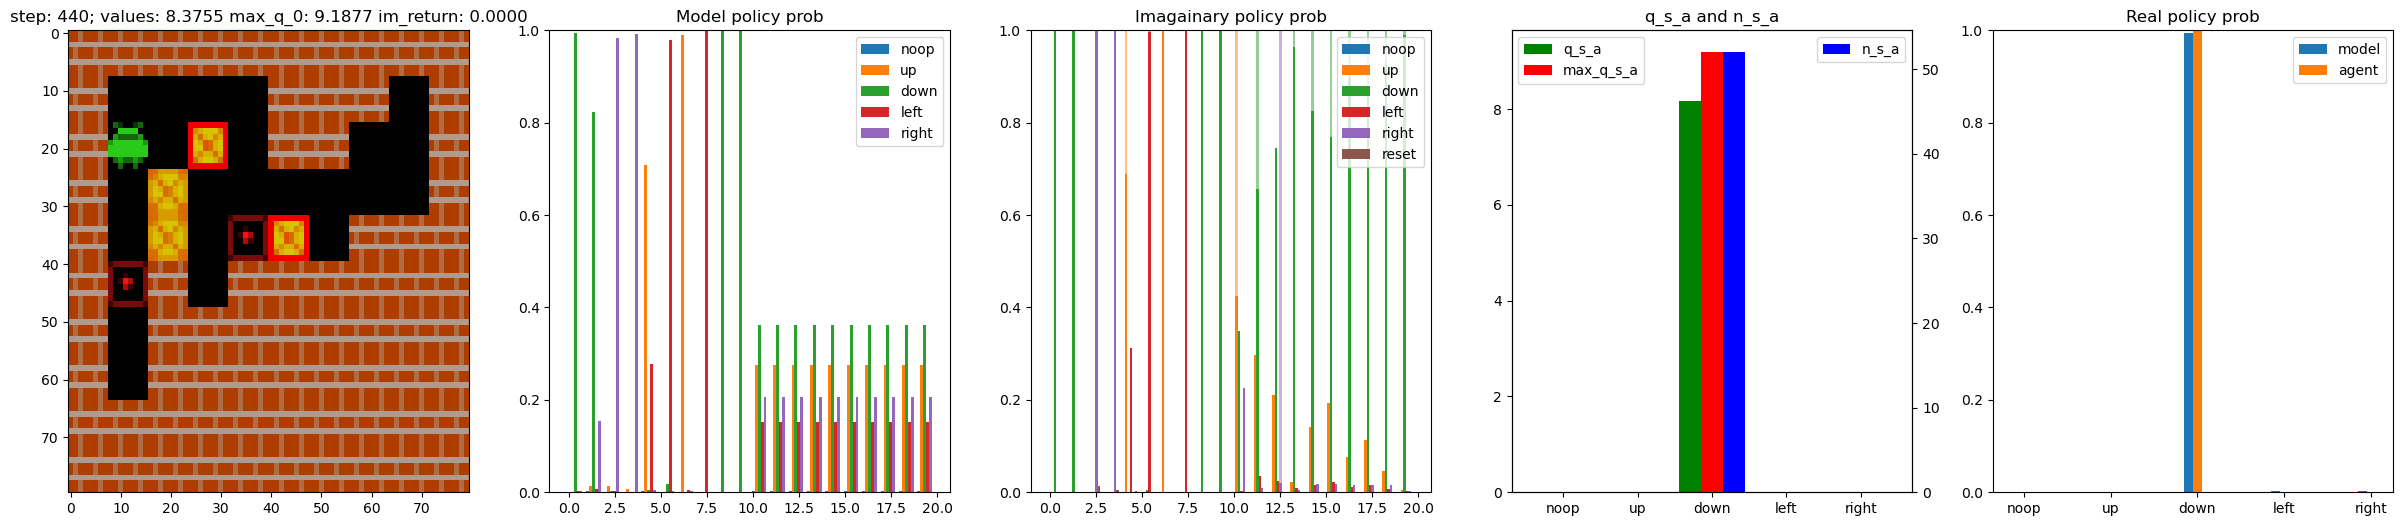

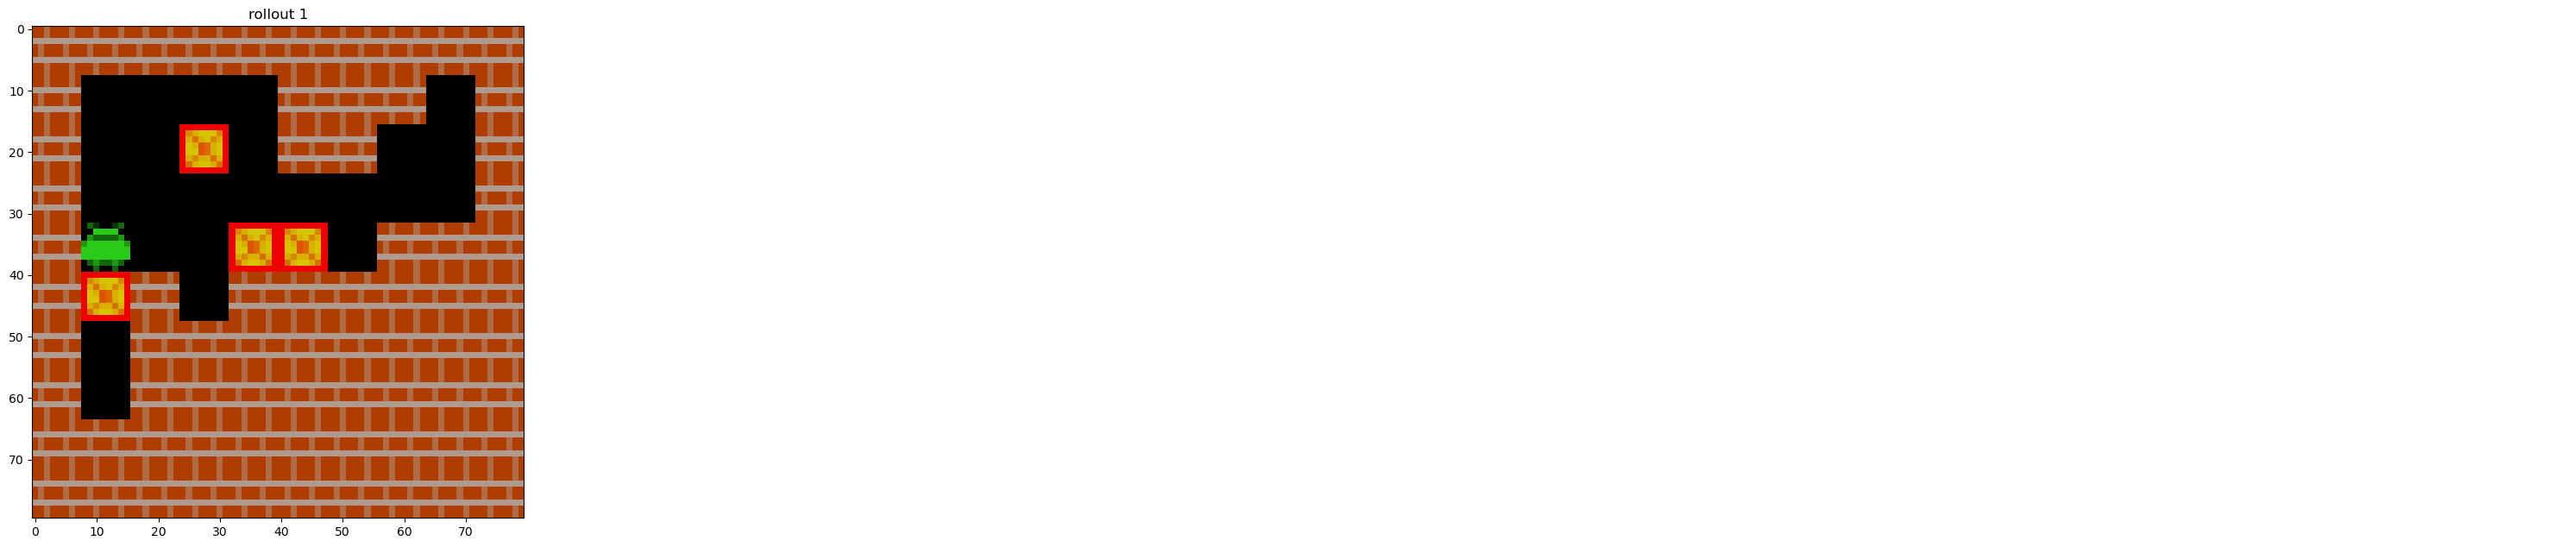

1: Down, Down, Right, Right, Up, Left, Up, Left, Down, Down, Up, Down, Right, Down, Down, Down, Down, Down, Down


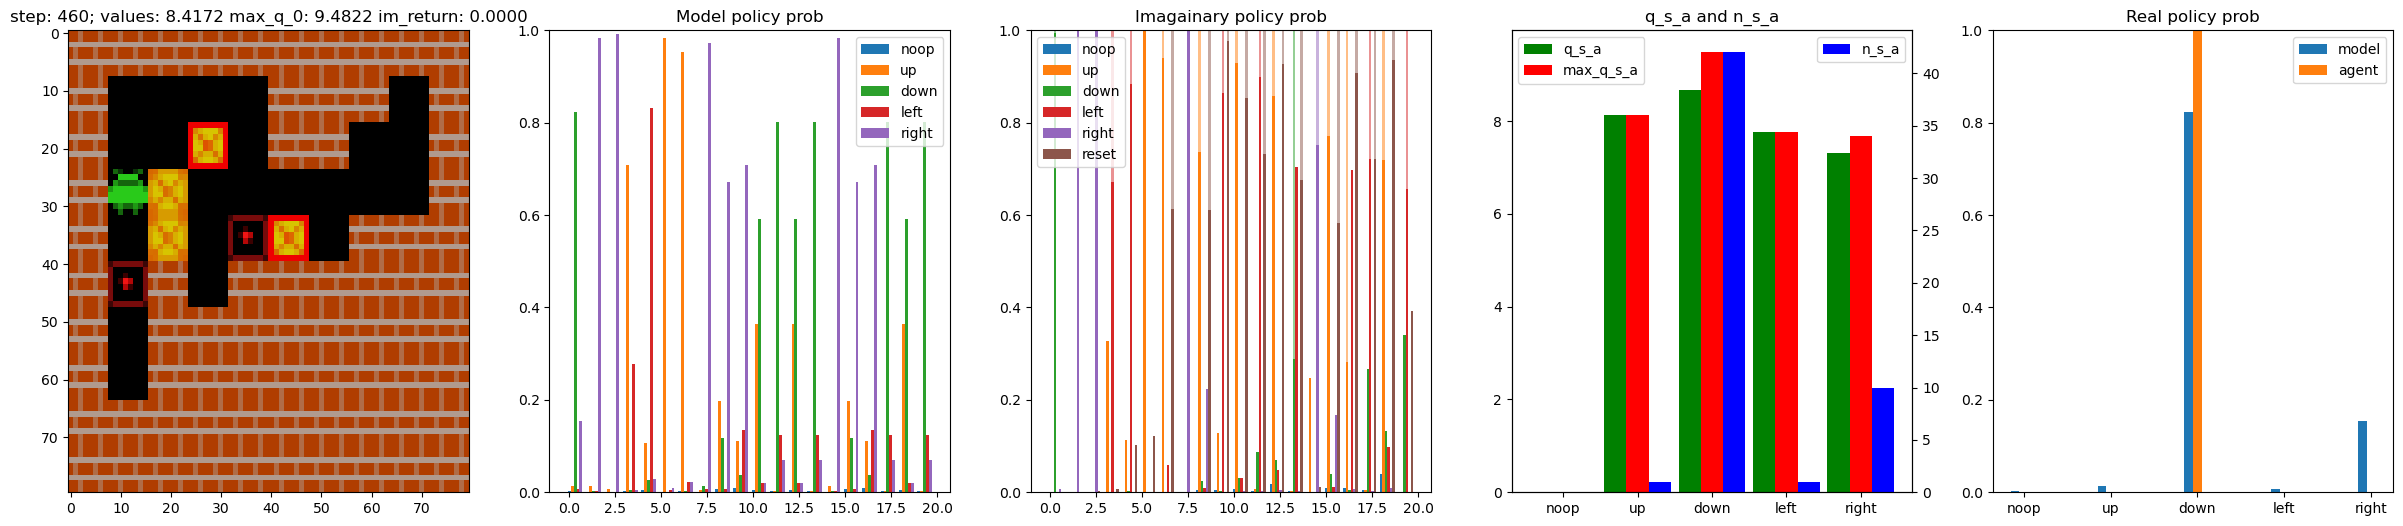

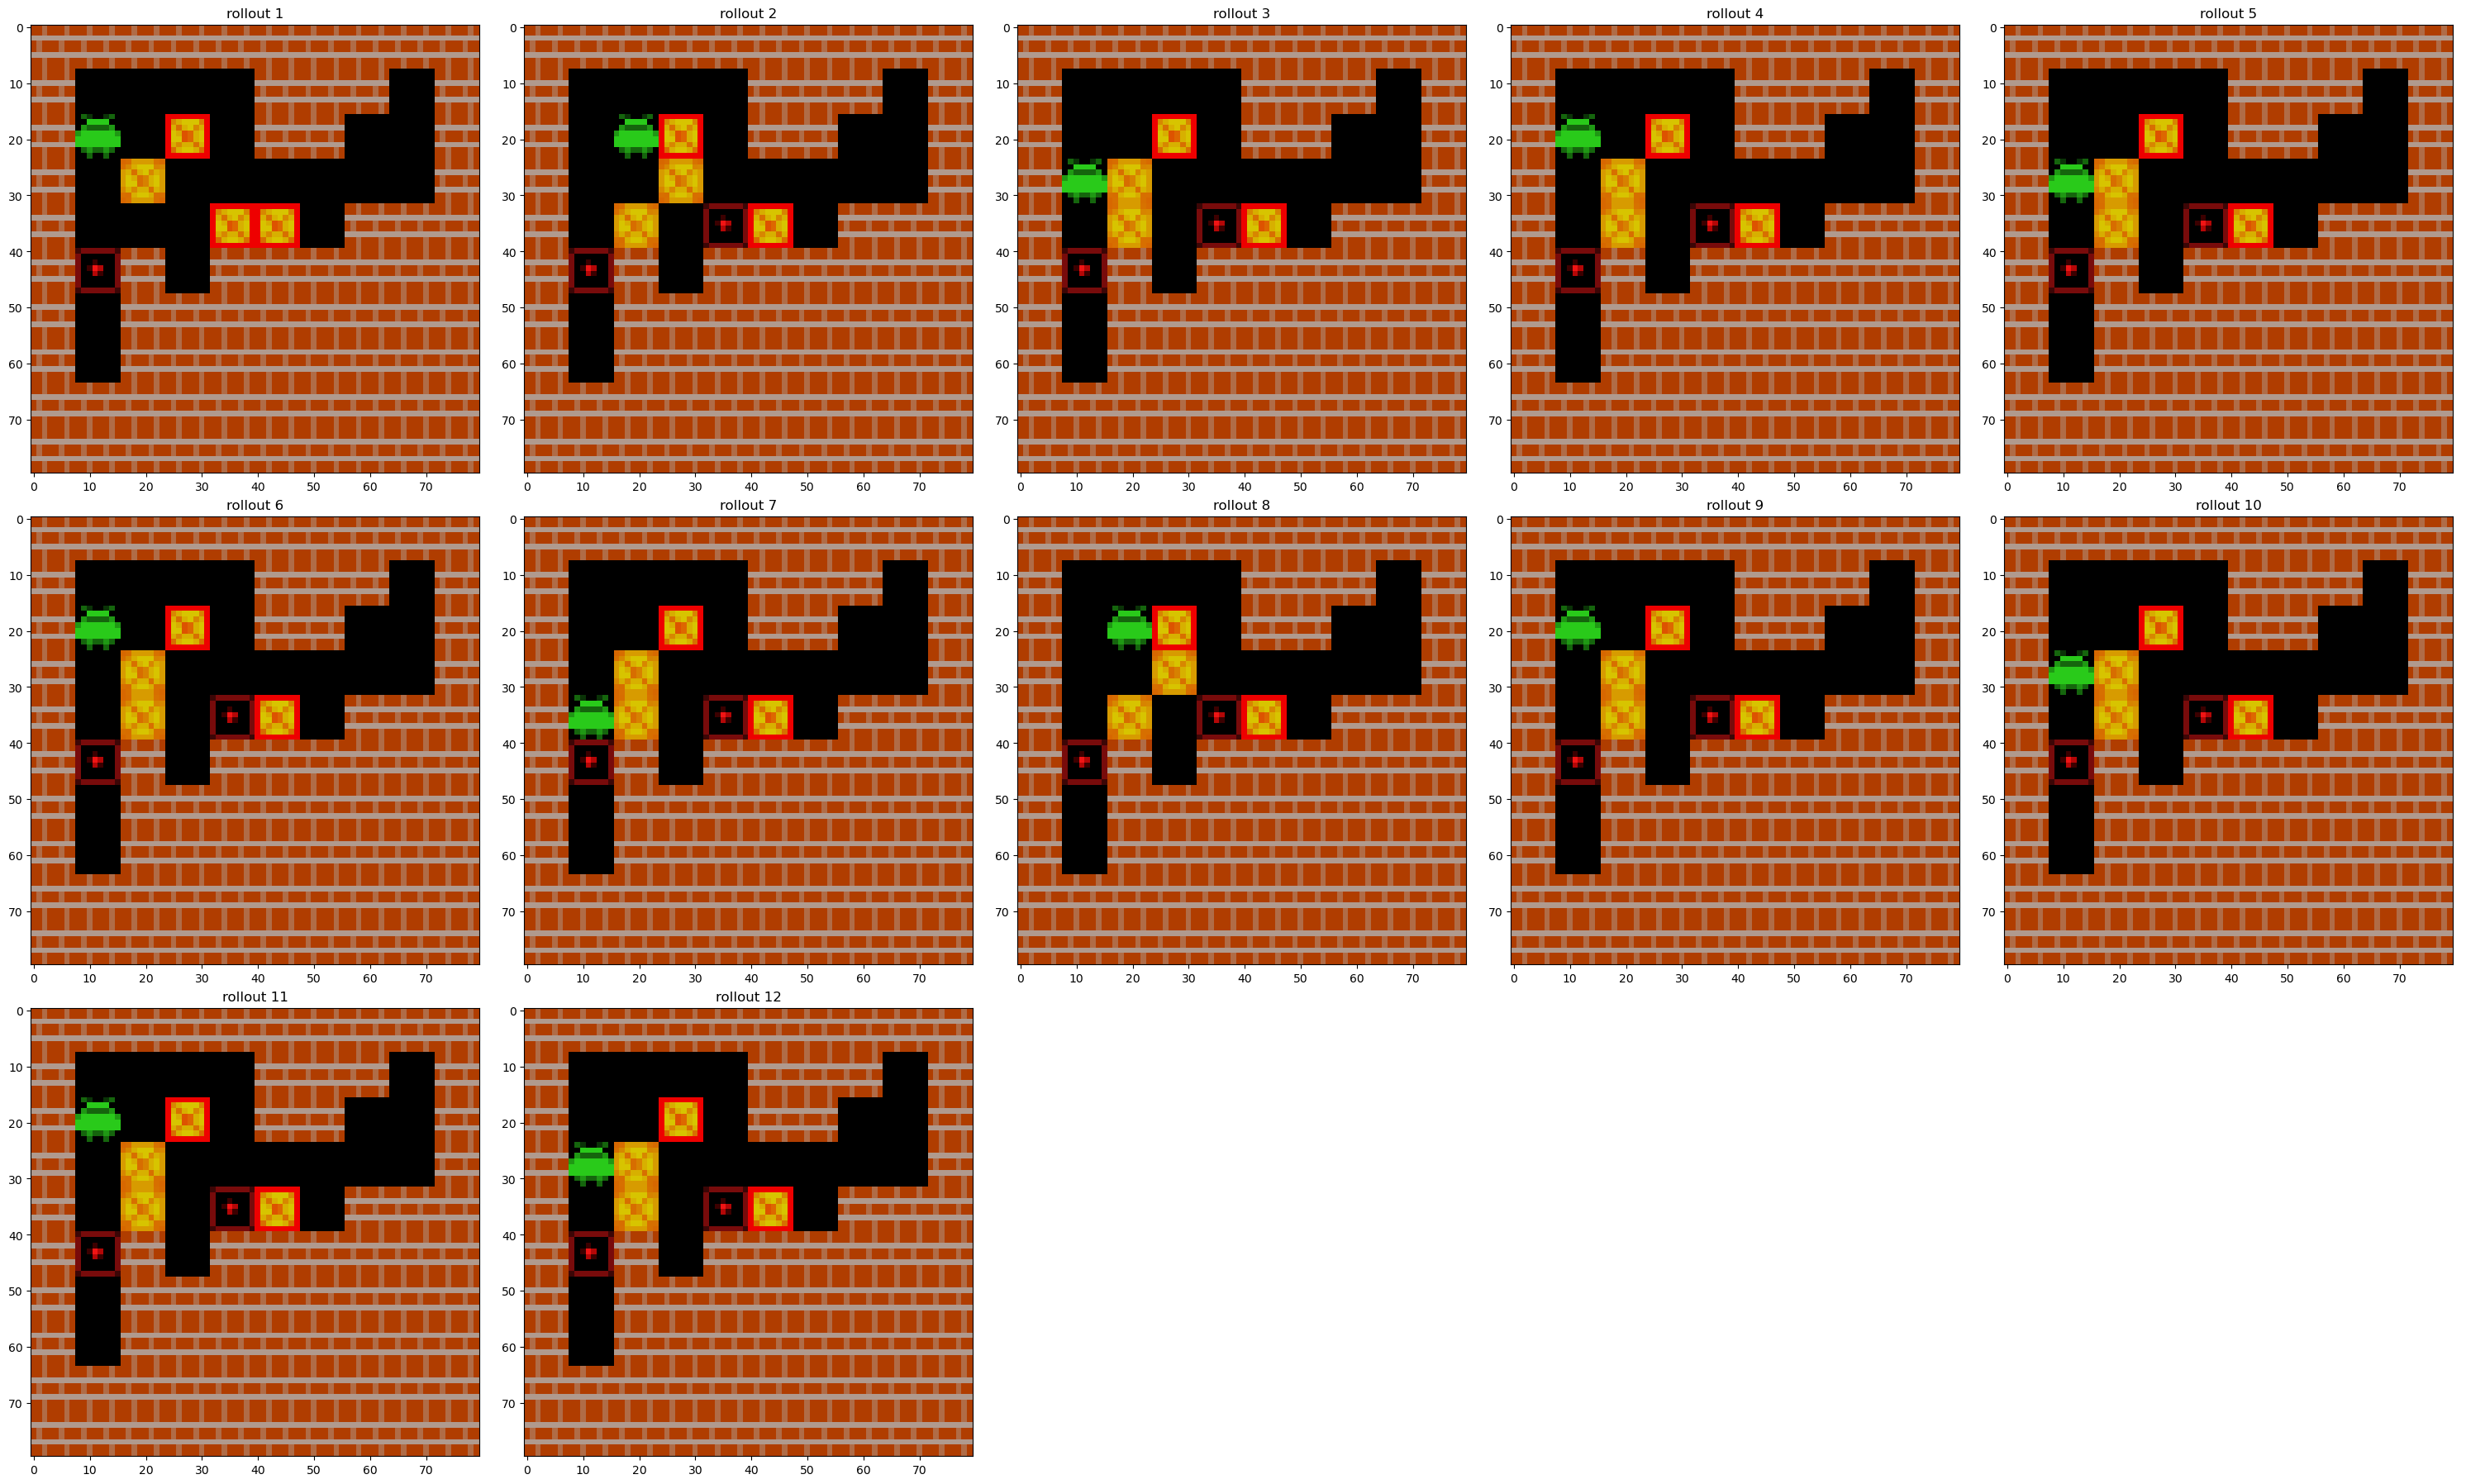

1: Down, Right, Right, Left, Left, Up, Up, Reset
2: Right, Up, Reset
3: Left, Reset
4: Up, Reset
5: Left, Reset
6: Up, Reset
7: Down, Reset
8: Right, Up, Reset
9: Up, Reset
10: Left, Reset
11: Up, Reset


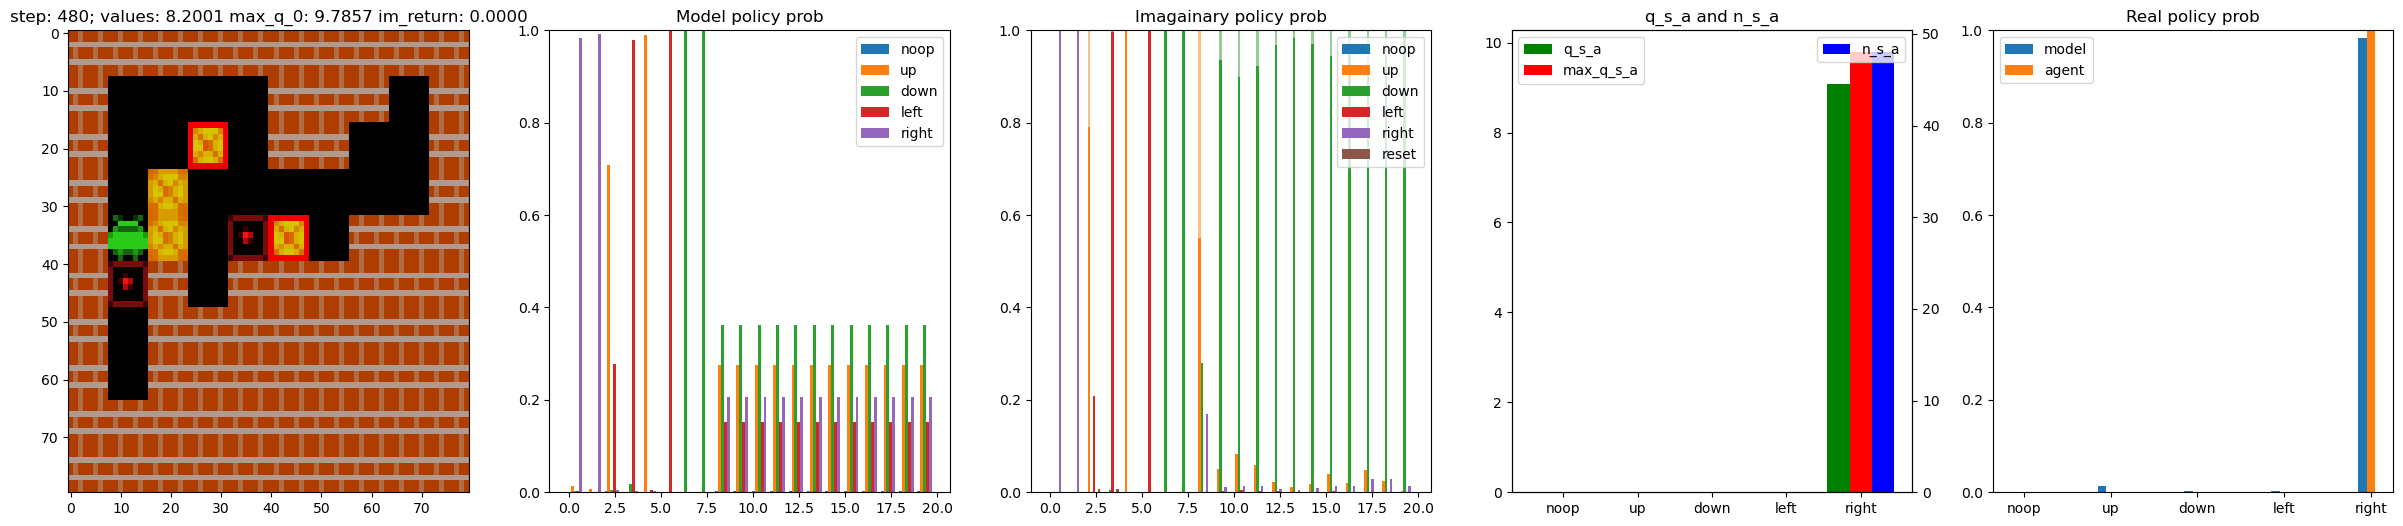

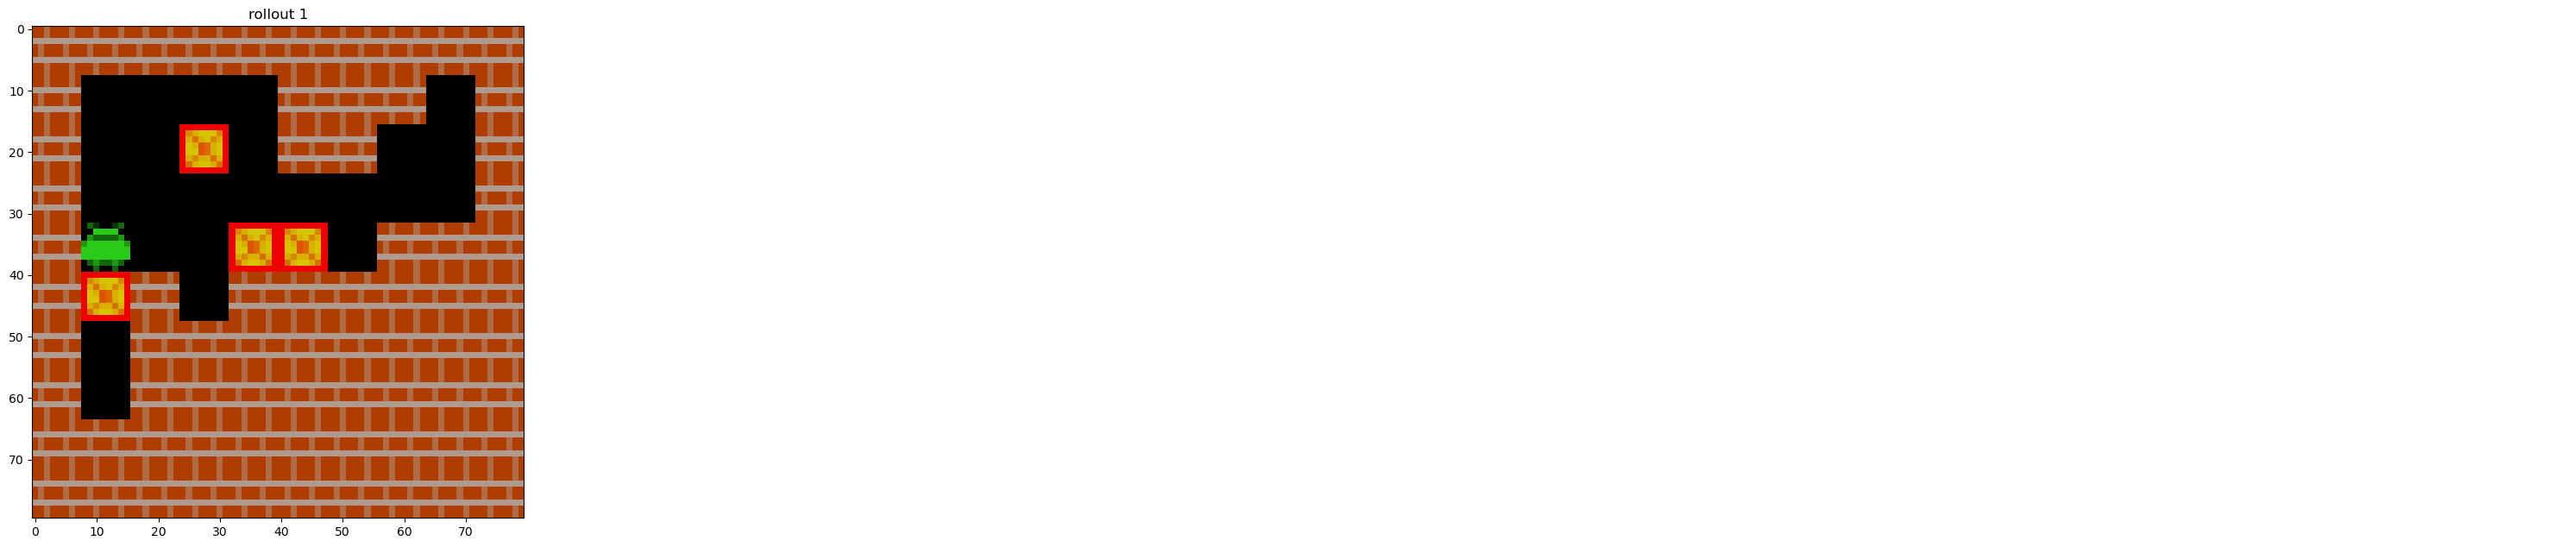

1: Right, Right, Up, Left, Up, Left, Down, Down, Up, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down


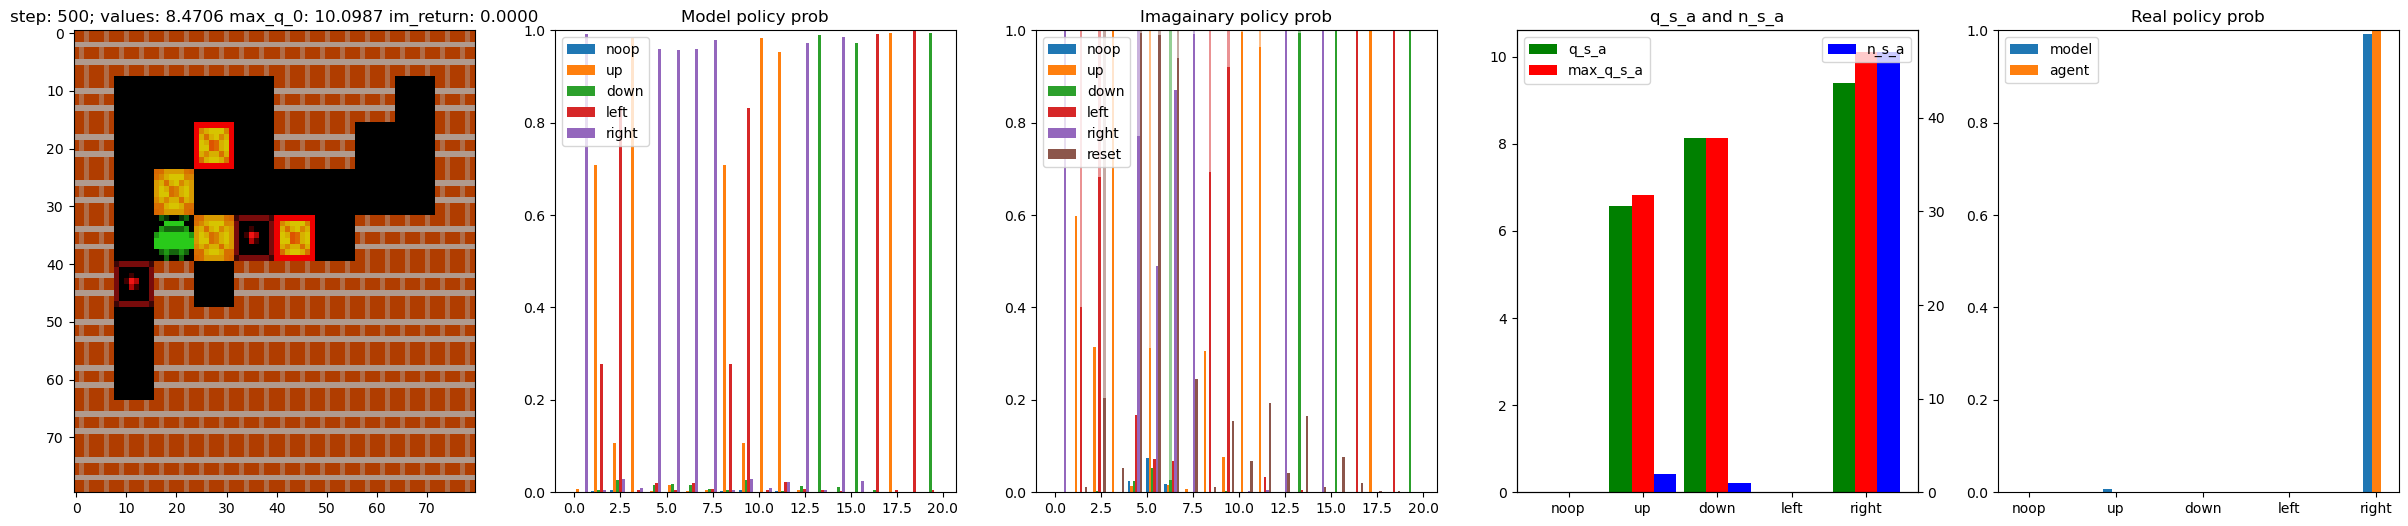

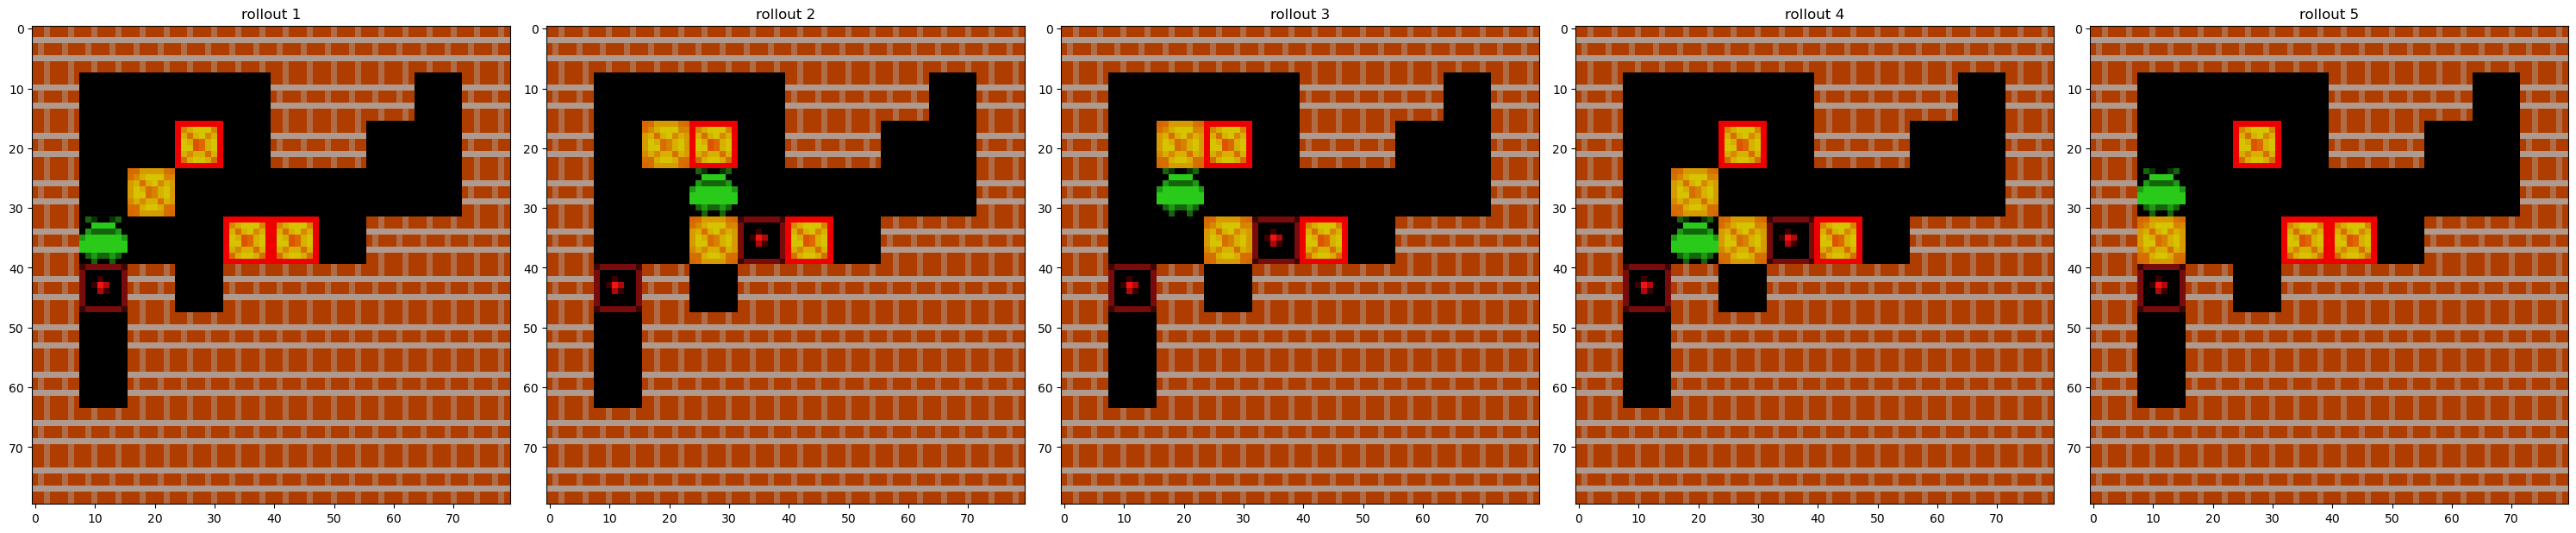

1: Right, Left, Left, Reset
2: Up, Right, Reset
3: Up, Reset
4: Down, Reset
5: Right, Left, Left, Up, Up, Right, Down, Right, Down, Left, Up, Left


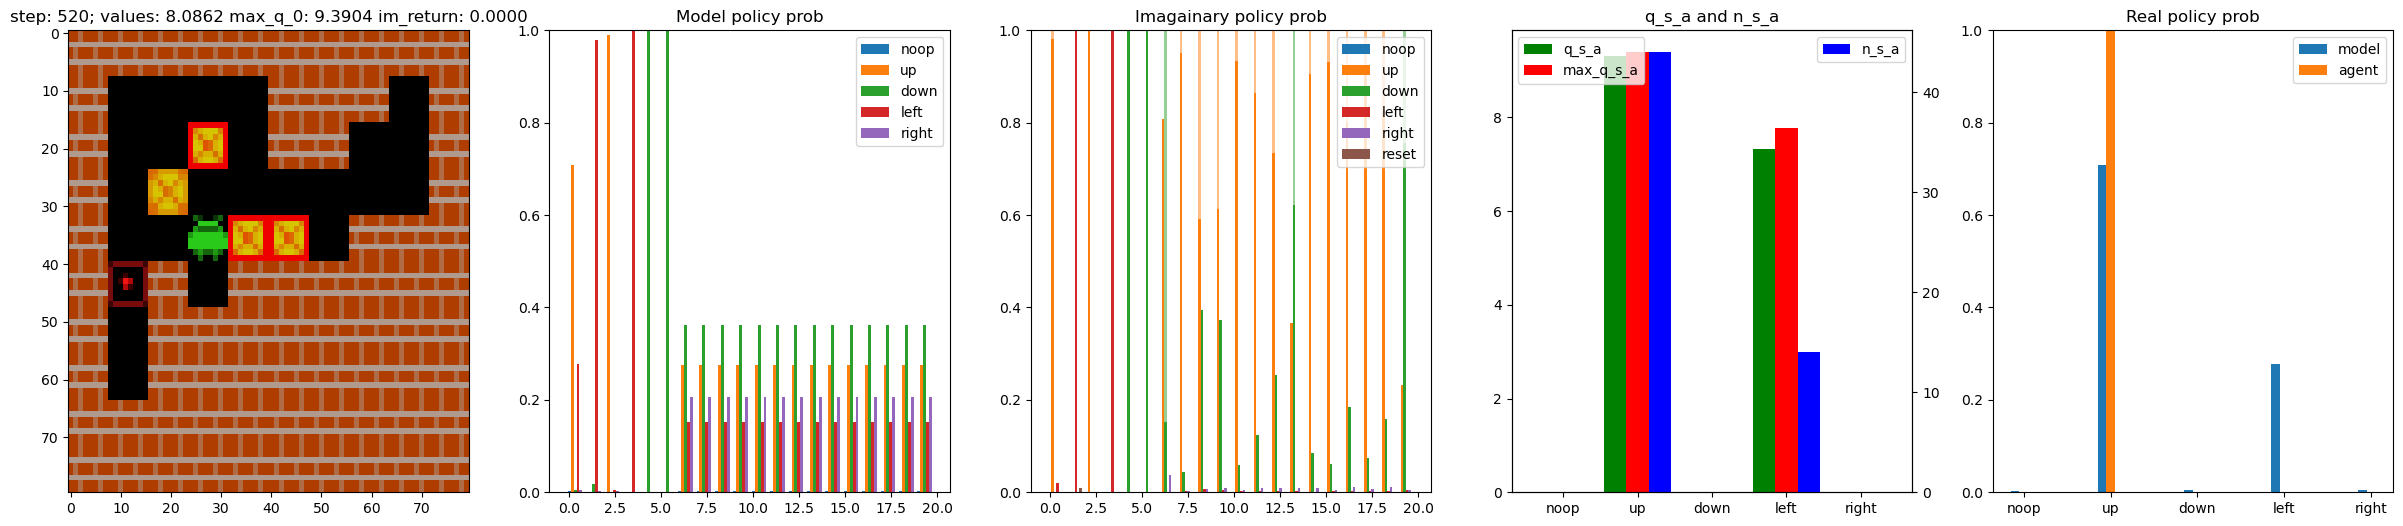

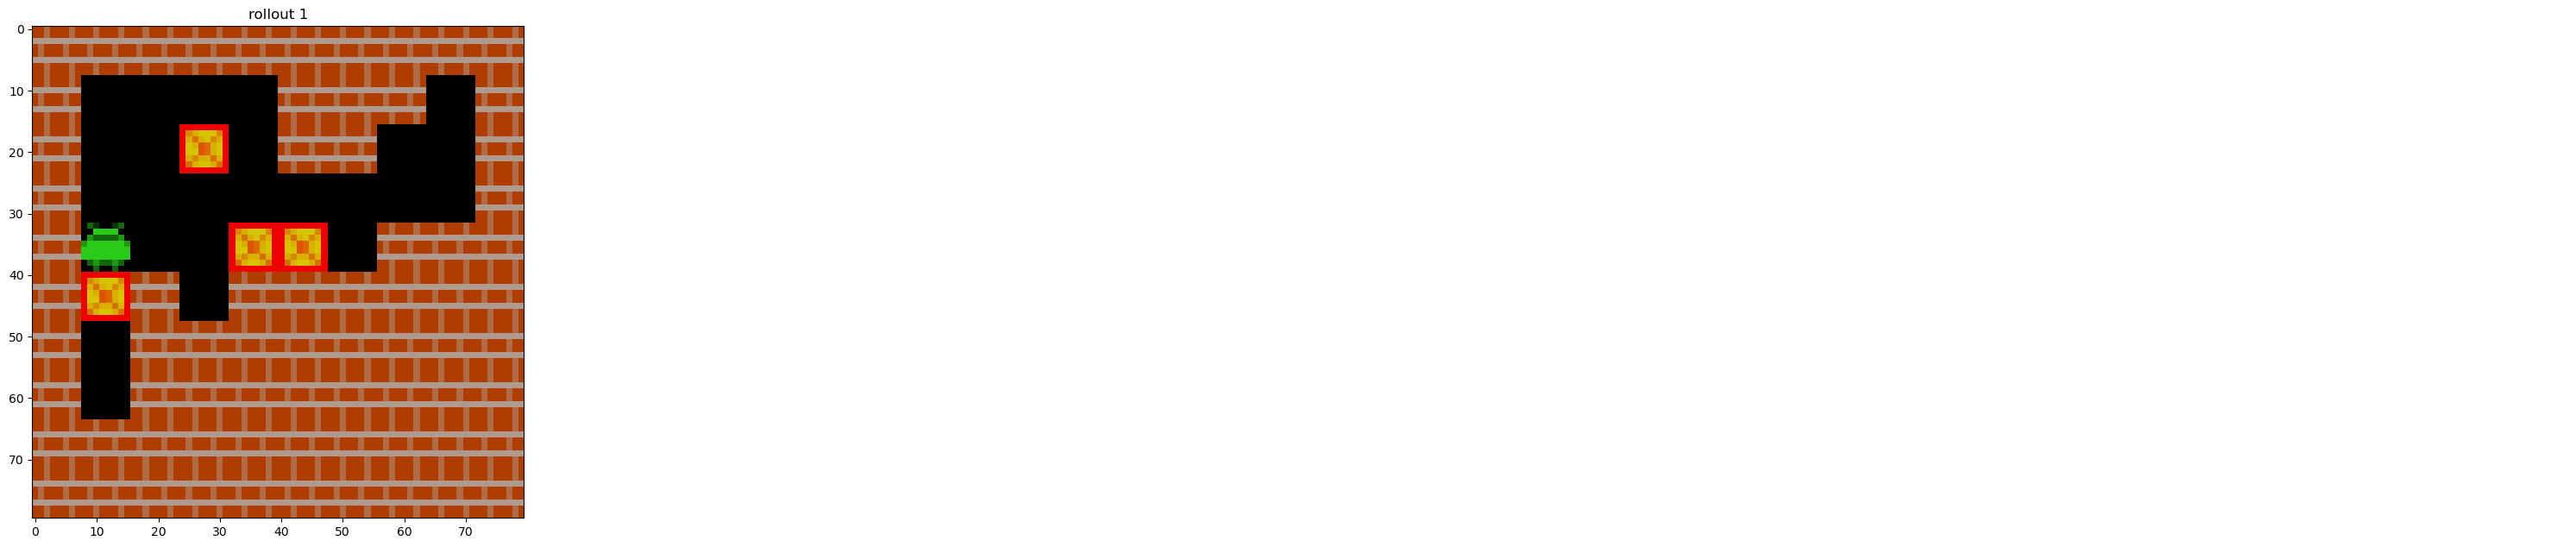

1: Up, Left, Up, Left, Down, Down, Down, Up, Up, Up, Up, Up, Up, Down, Up, Up, Up, Up, Up


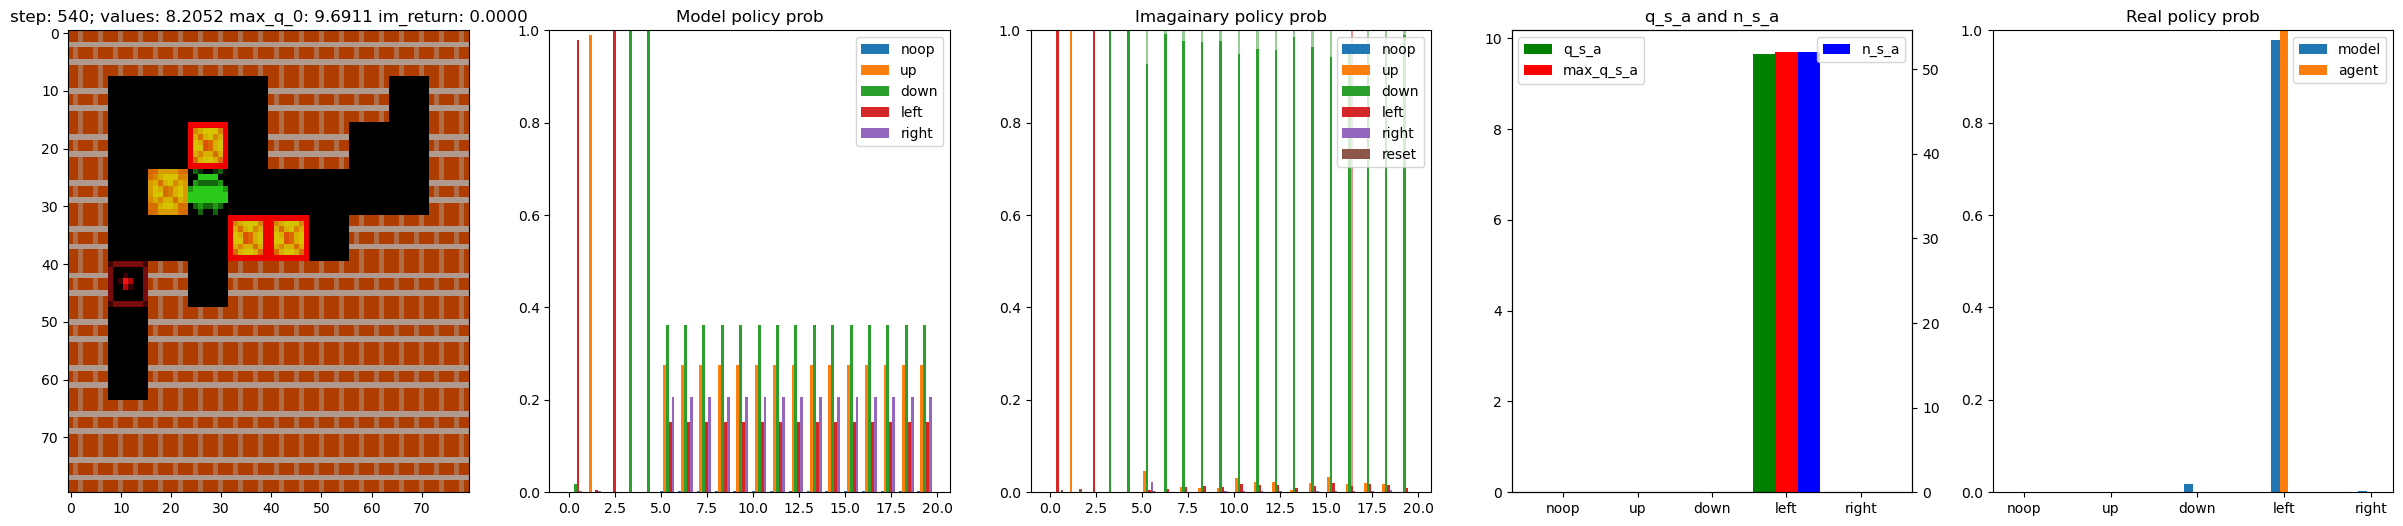

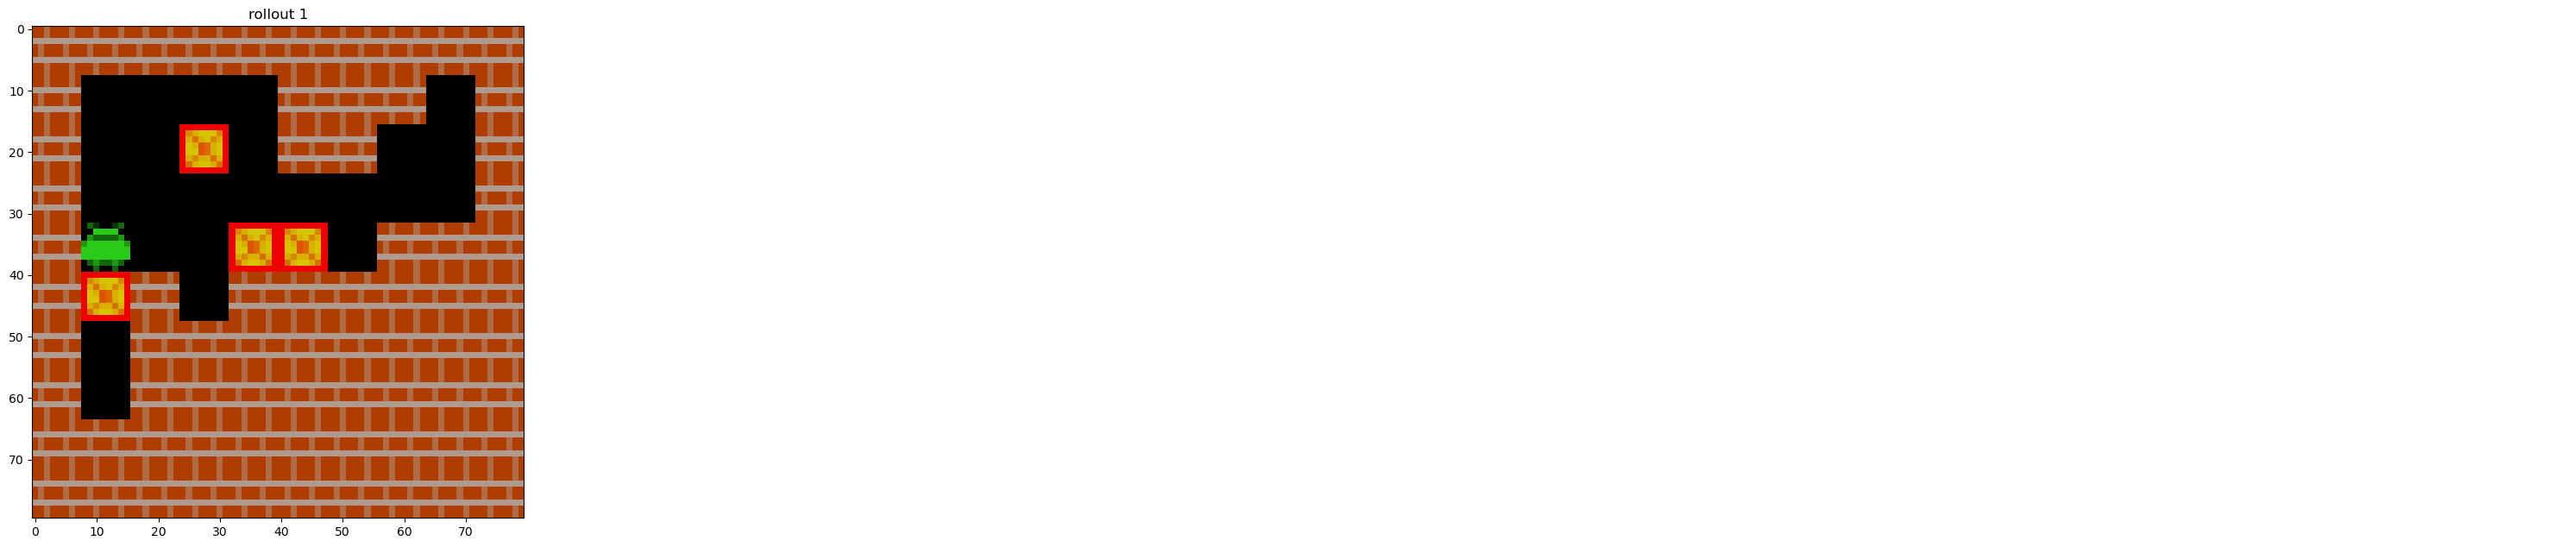

1: Left, Up, Left, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down, Left, Down, Down


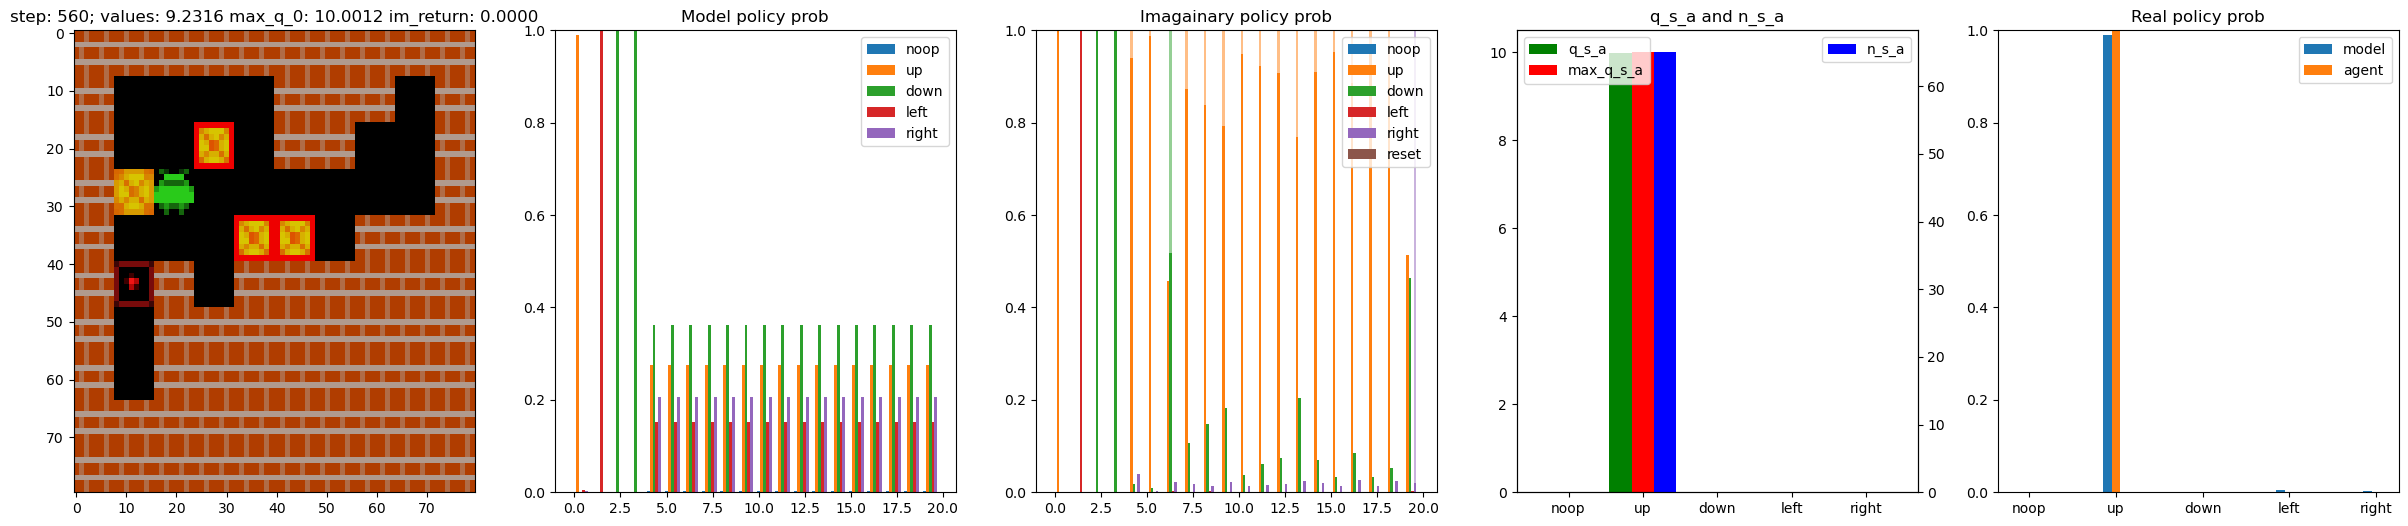

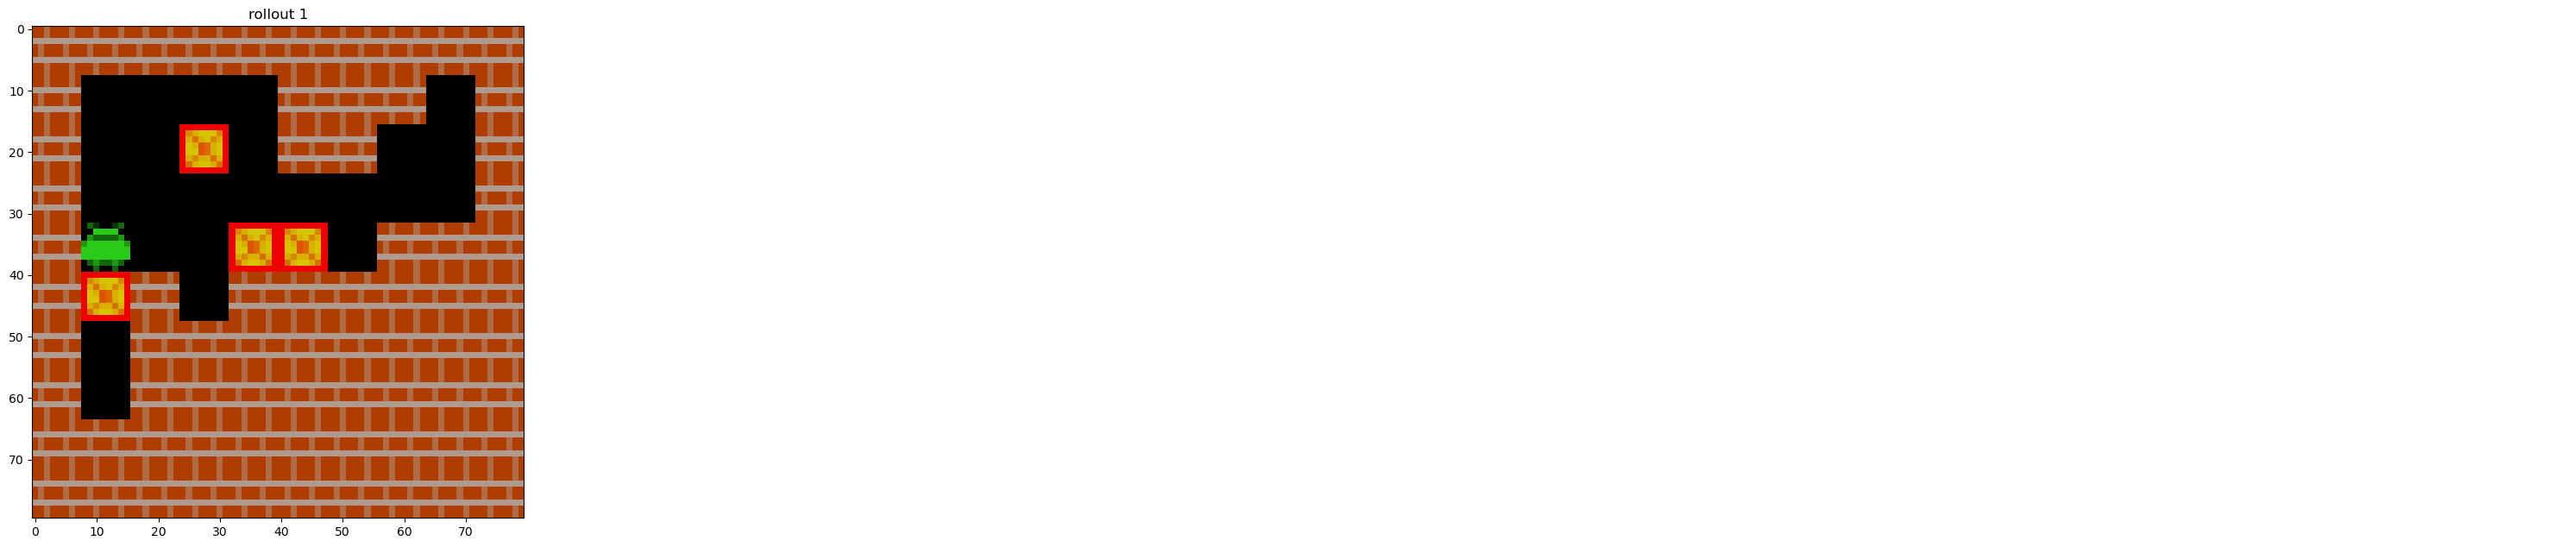

1: Up, Left, Down, Down, Up, Up, Down, Up, Up, Up, Up, Up, Up, Up, Up, Up, Up, Up, Up


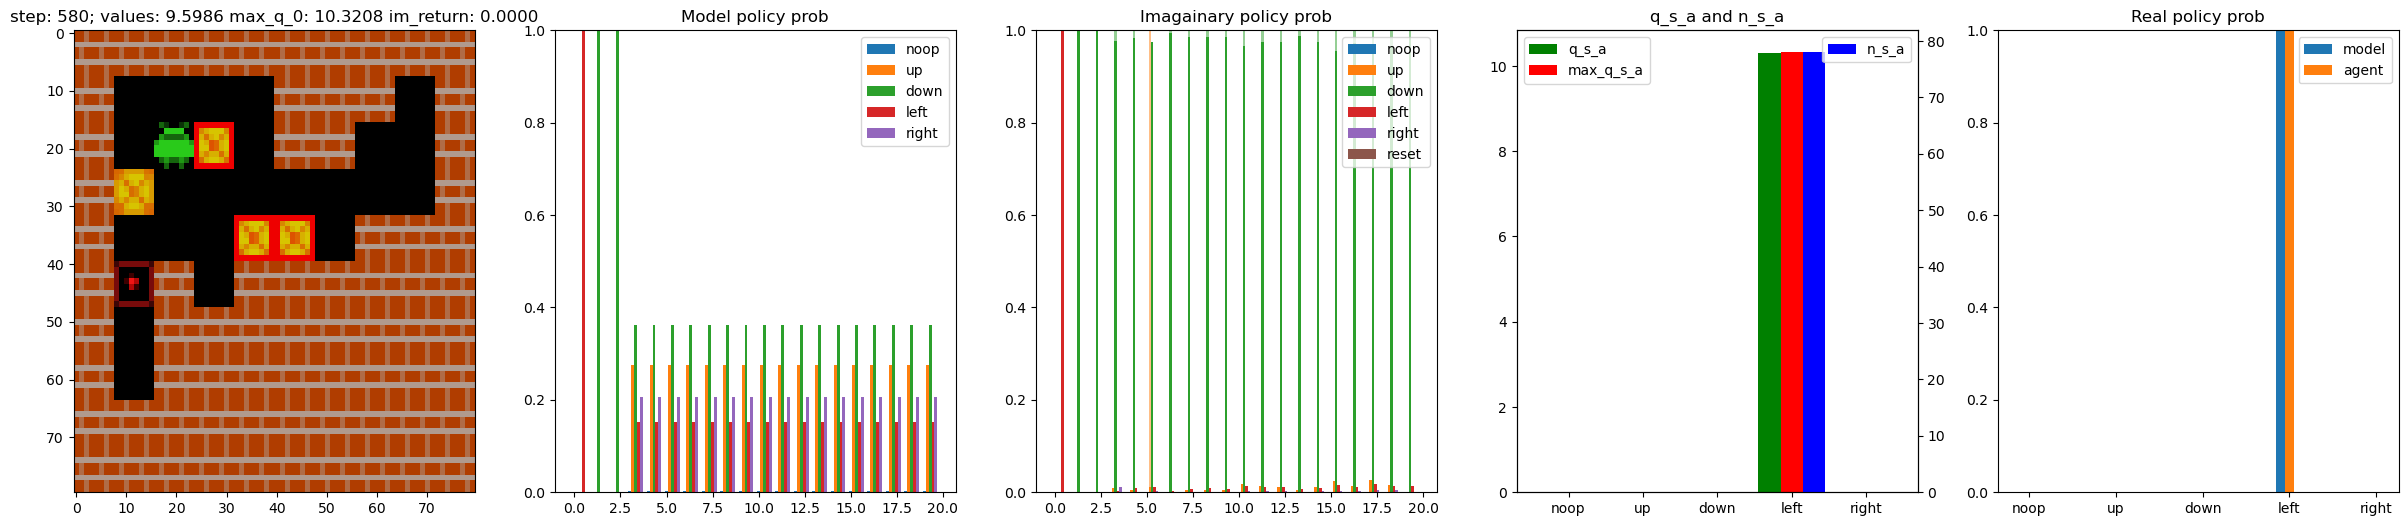

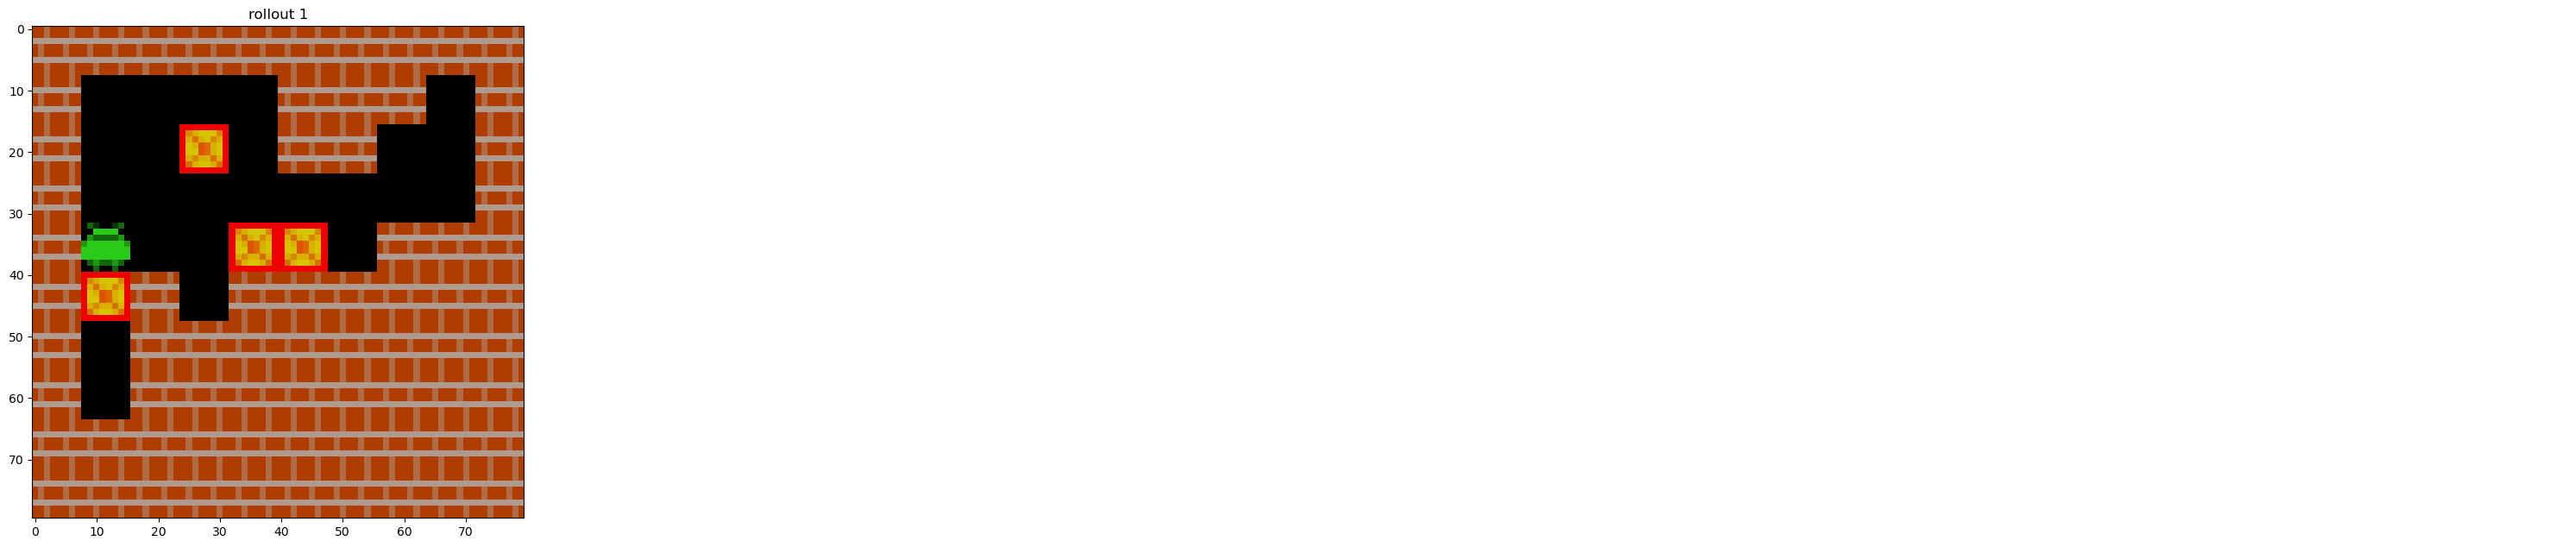

1: Left, Down, Down, Down, Down, Up, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down


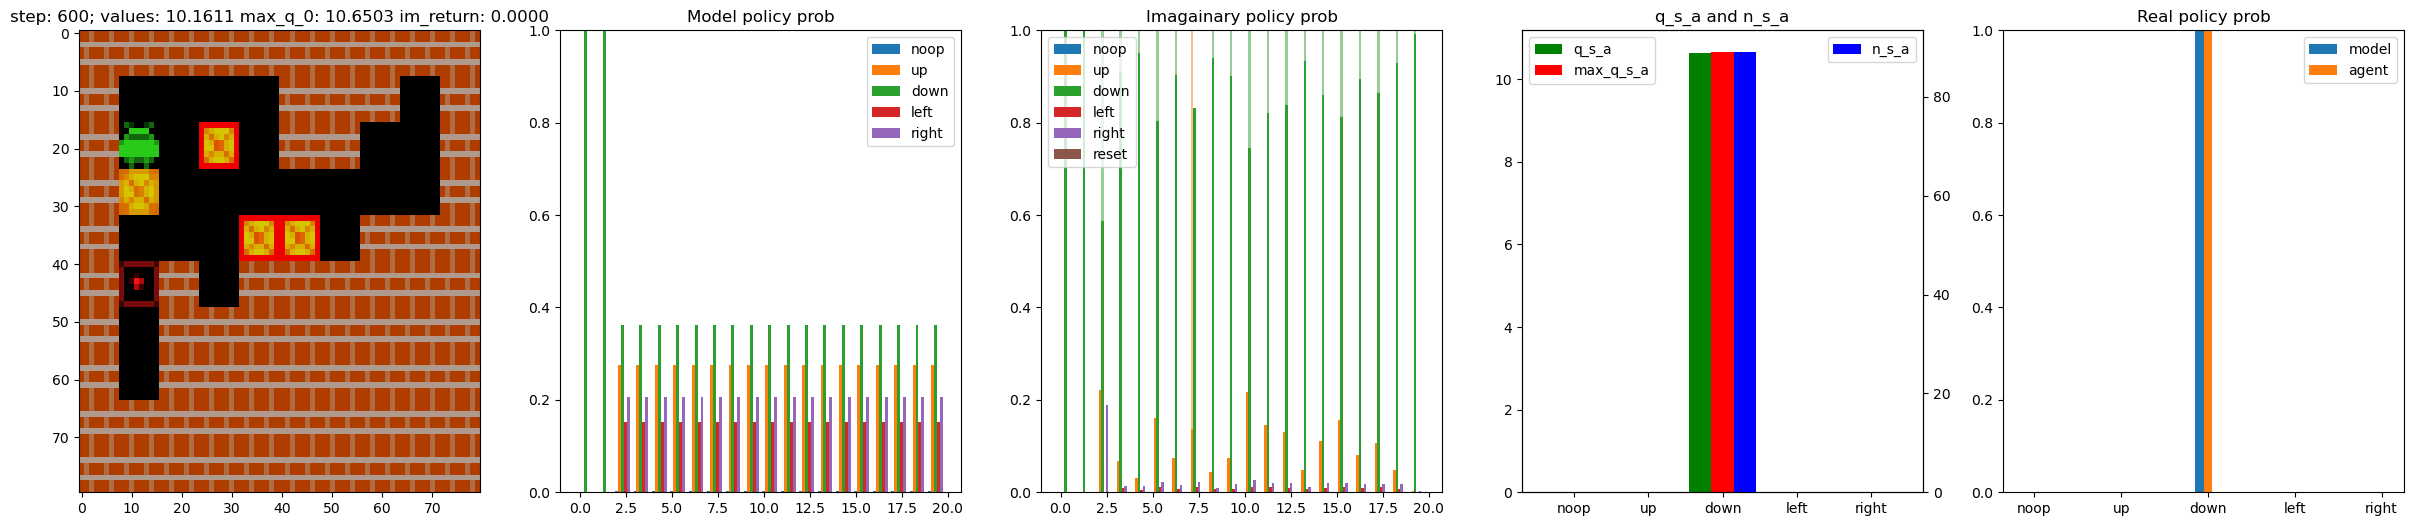

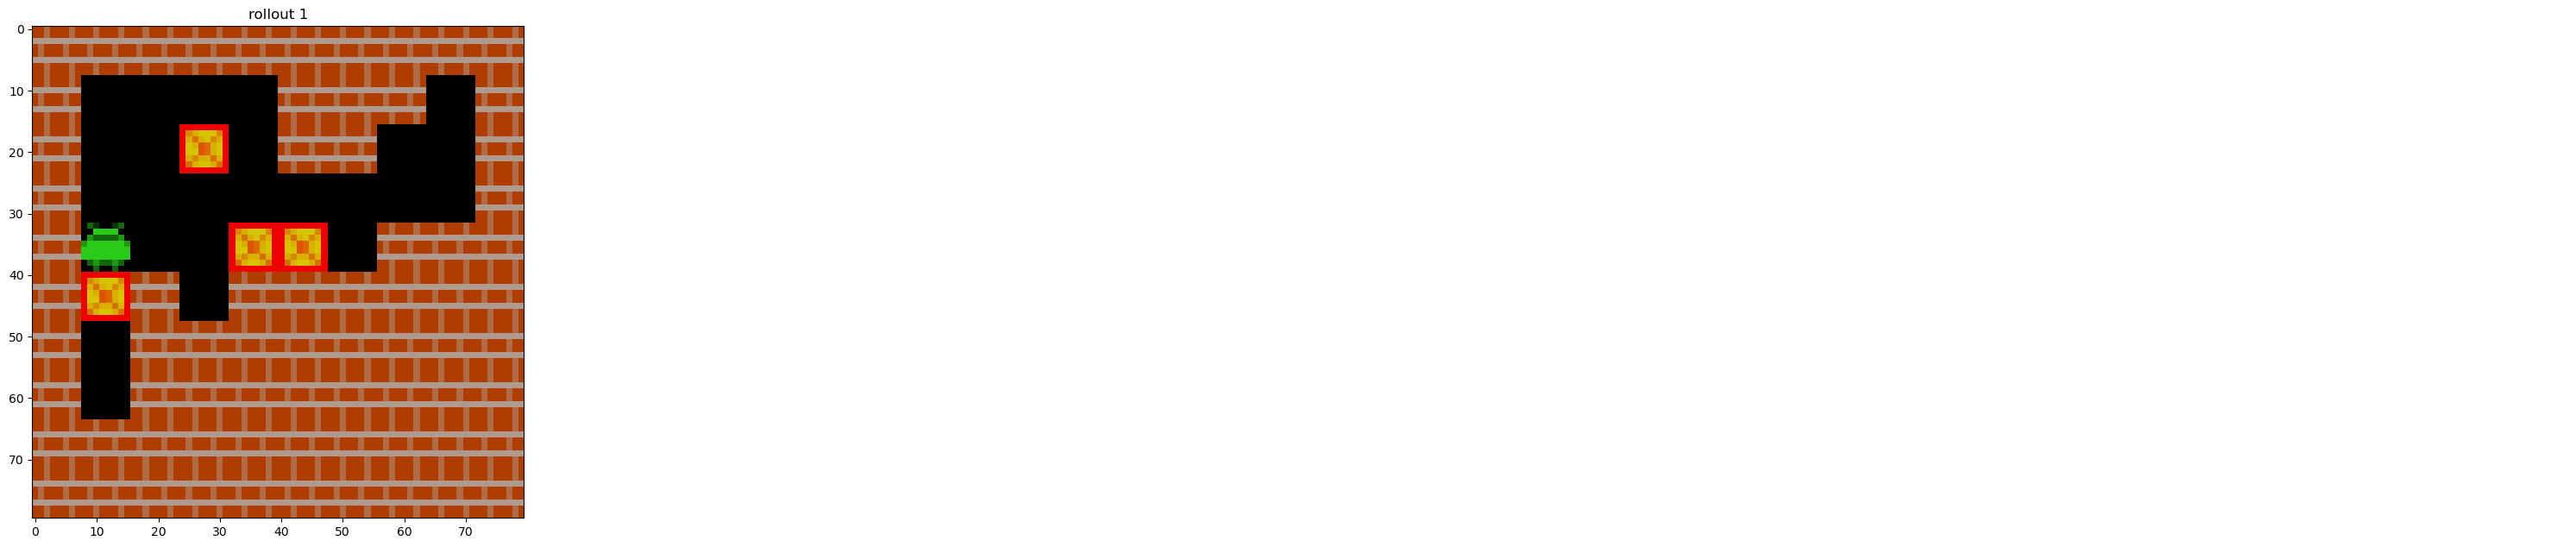

1: Down, Down, Down, Down, Down, Down, Down, Up, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down, Down


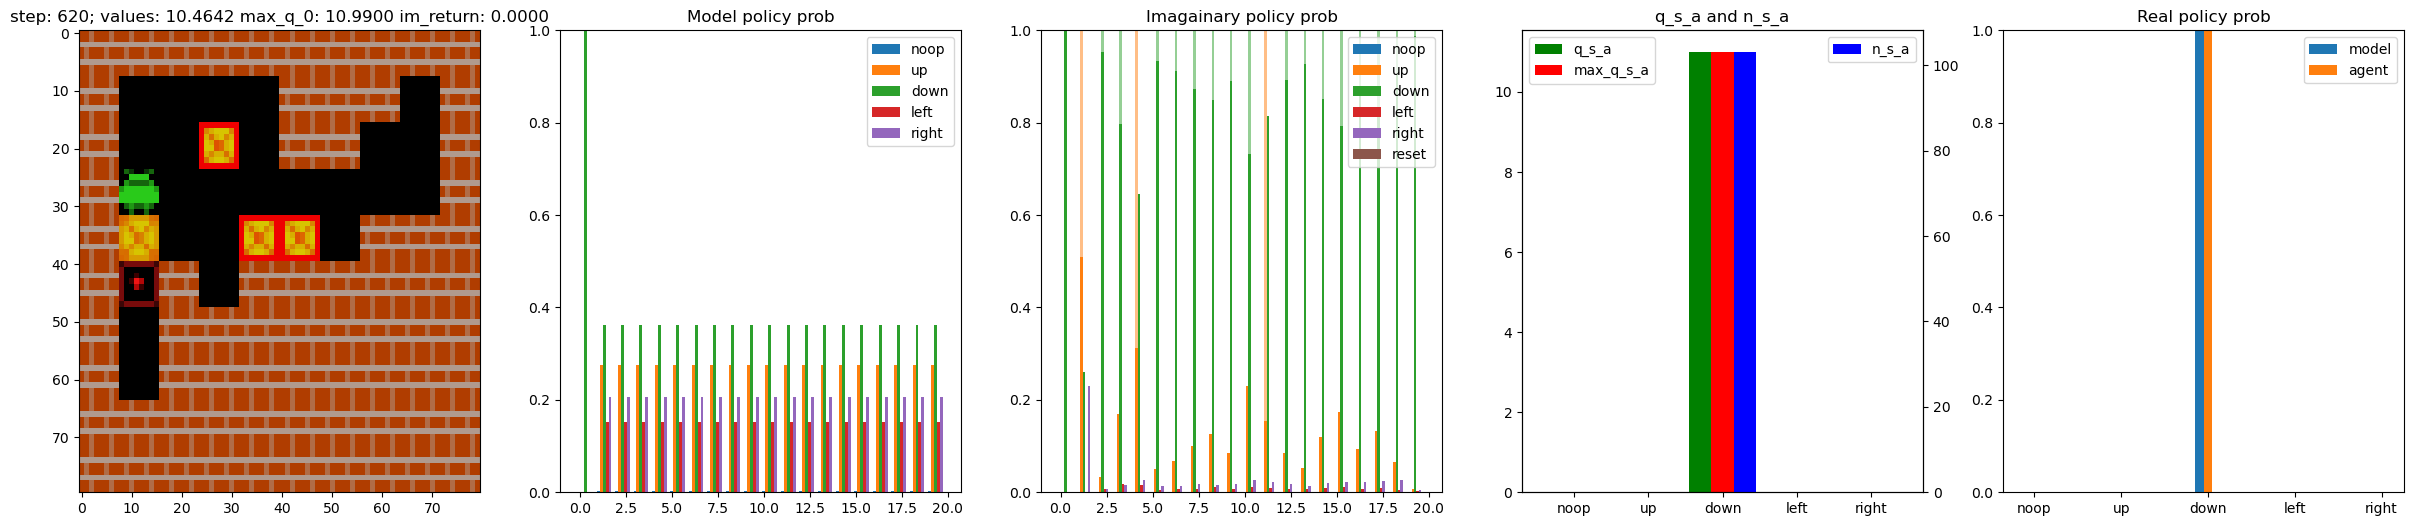

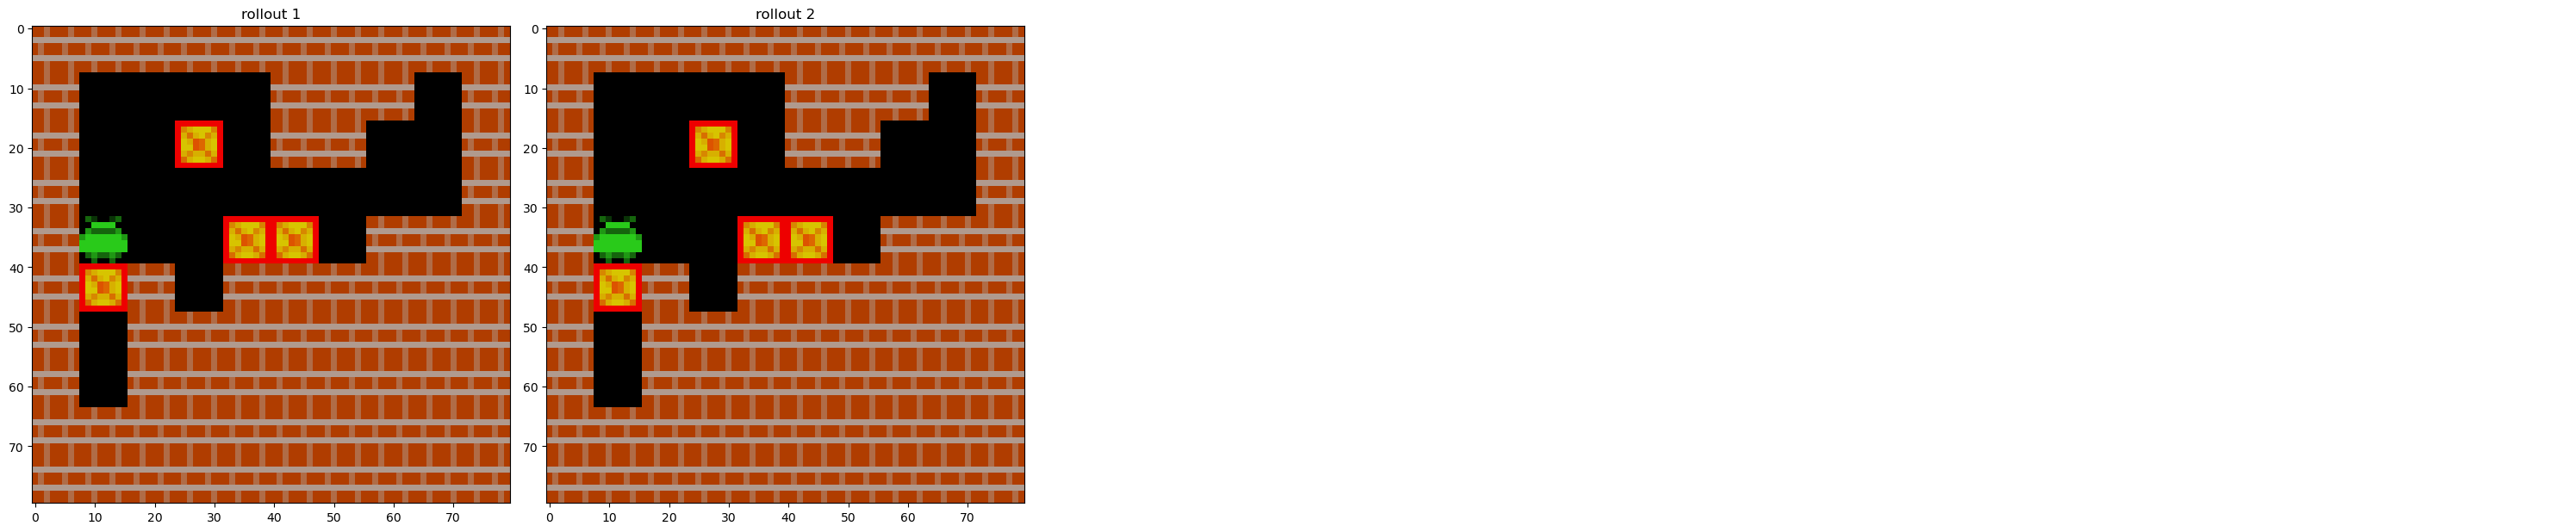

1: Down, Up, Down, Down, Up, Down, Down, Down, Down, Down, Down, Up, Down, Down, Down, Down, Down, Down, Down
Finish 1 episode: avg. return: 13.69 (+-0.00) 


In [12]:
# Visualize learned actor network

check_point_path = '/media/sc/datadisk/data/thinker/logs/planner_logs/thinker_model_0.5policycost_20rec_t_nopreload'
check_point_path = os.path.expanduser(check_point_path)
max_eps_n = 1
visualize = True

flags = util.parse(['--load_checkpoint', check_point_path])
env = Environment(flags, model_wrap=True)
model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
model_net.train(False)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_model.tar'), torch.device("cpu"))
model_net.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  

actor_net = ActorNet(obs_shape=env.model_out_shape, num_actions=env.num_actions, flags=flags)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_actor.tar'), torch.device("cpu"))         
actor_net.set_weights(checkpoint["actor_net_state_dict"])
actor_state = actor_net.initial_state(batch_size=1) 

env.env.debug = True
env_out, employ_model_state = env.initial(model_net)
last_root_max_q = env.env.root_max_q
gym_env_out = env_out.gym_env_out

returns = []
step = 0
im_list = ["im_policy_logits", "reset_policy_logits", "term_policy_logits", "im_action", "reset_action", "term_action"]
im_dict = {k: [] for k in im_list}
model_logits, attn_output = [], []

while len(returns) < max_eps_n:    
    step += 1
    actor_out, actor_state = actor_net(env_out, actor_state)      
    action = [actor_out.action, actor_out.im_action, actor_out.reset_action]
    if actor_out.term_action is not None:
        action.append(actor_out.term_action)
    action = torch.cat(action, dim=-1).unsqueeze(0)

    # additional stat record
    if len(im_dict['reset_action']) > 0:
        im_dict['reset_action'][-1] = env.env.ret_dict['reset']
    for k in im_list: 
        im_dict[k].append(getattr(actor_out, k)[0] if k in actor_out._fields and 
            getattr(actor_out, k) is not None else None)    
    model_logits.append(env.env.ret_dict["logit"])
    attn_output.append(torch.cat([x.attn_output_weights.unsqueeze(0).unsqueeze(-2) for x in actor_net.core.layers])[:, :, 0, :])        
    ret_dict = env.env.ret_dict

    env_out, employ_model_state = env.step(action, model_net, employ_model_state)

    if visualize and env_out.cur_t[0,0] == 0:
        fig, axs = plt.subplots(1, 5, figsize=(30,6))      
        title = "step: %d; values: %.4f" % (step, ret_dict["v0"][0].cpu())
        for k in im_list: 
            if im_dict[k][0] is not None:
                im_dict[k] = torch.concat(im_dict[k], dim=0)            
            else:
                im_dict[k] = None
        #if "thres" in ret_dict: title += " thres: %.4f" % ret_dict["thres"][0].cpu()
        if last_root_max_q is not None:  title += " max_q_0: %.4f" % last_root_max_q.cpu()
        if flags.reward_type == 1: title += " im_return: %.4f" % env_out.episode_return[..., 1]                        
        plot_gym_env_out(gym_env_out[0], axs[0], title=title)  
        plot_base_policies(torch.concat(model_logits), ax=axs[1])  
        plot_im_policies(**im_dict, one_hot=False, reset_ind=1, ax=axs[2])   
        max_q_s_a = ret_dict["max_q_s_a"][0] if "max_q_s_a" in ret_dict else None    
        plot_qn_sa(ret_dict["q_s_a"][0], ret_dict["n_s_a"][0], max_q_s_a, ax=axs[3]) 
        plot_policies([ret_dict["logit0"][0], actor_out.policy_logits[0,0]], ["model", "agent"], ax=axs[4])  
        plt.show()
        plot_multi_gym_env_out(env.env.debug_xs)
        print_im_actions(im_dict, print_stat=True)    

        gym_env_out = env_out.gym_env_out
        last_root_max_q = env.env.root_max_q
        im_dict = {k: [] for k in im_list}
        model_logits, attn_output = [], []

    if torch.any(env_out.done):
        step = 0
        new_rets = env_out.episode_return[env_out.done][:,0].numpy()
        returns.extend(new_rets)
        print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))  


In [ ]:
# Visualize learned actor network

check_point_path = '~/RS/thinker/models/test'
check_point_path = os.path.expanduser(check_point_path)
max_eps_n = 1
visualize = True

flags = util.parse(['--load_checkpoint', check_point_path])
env = Environment(flags, model_wrap=True)
model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
model_net.train(False)

checkpoint = torch.load(os.path.join(check_point_path,'ckp_model.tar'), torch.device("cpu"))
model_net.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  


actor_net = ActorNet(obs_shape=env.model_out_shape, num_actions=env.num_actions, flags=flags)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_actor.tar'), torch.device("cpu"))         
actor_net.set_weights(checkpoint["actor_net_state_dict"])
actor_state = actor_net.initial_state(batch_size=1) 

model_net_rnn = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags, rnn=True)
model_net_rnn.train(False)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_model_rnn.tar'), torch.device("cpu"))                    
model_net_rnn.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  
state = model_net_rnn.core.init_state(bsz=1)

env.env.debug = True
env_out = env.initial(model_net)
gym_env_out = env_out.gym_env_out

returns = []
step = 0
im_list = ["im_policy_logits", "reset_policy_logits", "term_policy_logits", "im_action", "reset_action", "term_action"]
im_dict = {k: [] for k in im_list}
model_logits, attn_output = [], []

_, model_rnn_logits, state = model_net_rnn(env_out.gym_env_out, env_out.last_action[:,:,0], env_out.done, state)

while len(returns) < max_eps_n:    
    step += 1
    actor_out, actor_state = actor_net(env_out, actor_state)      
    action = [actor_out.action, actor_out.im_action, actor_out.reset_action]
    if actor_out.term_action is not None:
        action.append(actor_out.term_action)
    action = torch.cat(action, dim=-1).unsqueeze(0)

    # additional stat record
    if len(im_dict['reset_action']) > 0:
        im_dict['reset_action'][-1] = env.env.ret_dict['reset']
    for k in im_list: 
        im_dict[k].append(getattr(actor_out, k)[0] if k in actor_out._fields and 
            getattr(actor_out, k) is not None else None)    
    model_logits.append(env.env.ret_dict["logit"])
    attn_output.append(torch.cat([x.attn_output_weights.unsqueeze(0).unsqueeze(-2) for x in actor_net.core.layers])[:, :, 0, :])        
    ret_dict = env.env.ret_dict

    env_out = env.step(action, model_net)

    if visualize and env_out.cur_t[0,0] == 0:

        fig, axs = plt.subplots(1, 5, figsize=(30,6))      
        title = "step: %d; values: %.4f" % (step, ret_dict["v0"][0].cpu())
        for k in im_list: 
            if im_dict[k][0] is not None:
                im_dict[k] = torch.concat(im_dict[k], dim=0)            
            else:
                im_dict[k] = None
        if "thres" in ret_dict: title += " thres: %.4f" % ret_dict["thres"][0].cpu()
        if flags.reward_type == 1: title += " im_return: %.4f" % env_out.episode_return[..., 1]                        
        plot_gym_env_out(gym_env_out[0], axs[0], title=title)  
        plot_base_policies(torch.concat(model_logits), ax=axs[1])  
        plot_im_policies(**im_dict, one_hot=False, reset_ind=1, ax=axs[2])   
        max_q_s_a = ret_dict["max_q_s_a"][0] if "max_q_s_a" in ret_dict else None    
        plot_qn_sa(ret_dict["q_s_a"][0], ret_dict["n_s_a"][0], max_q_s_a, ax=axs[3]) 
        plot_policies([ret_dict["logit0"][0], actor_out.policy_logits[0,0], model_rnn_logits[0,0]], 
                      ["model", "agent", "model_rnn"], ax=axs[4])  
        plt.show()
        plot_multi_gym_env_out(env.env.debug_xs)
        print_im_actions(im_dict, print_stat=True)    

        gym_env_out = env_out.gym_env_out
        im_dict = {k: [] for k in im_list}
        model_logits, attn_output = [], []
    if env_out.cur_t[0,0] == 0:
        _, model_rnn_logits, state = model_net_rnn(env_out.gym_env_out, env_out.last_action[:,:,0], env_out.done, state)

    if torch.any(env_out.done):
        step = 0
        new_rets = env_out.episode_return[env_out.done][:,0].numpy()
        returns.extend(new_rets)
        print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))  


In [20]:
# Visualize plain model policy

check_point_path = '~/RS/thinker/models/test'
check_point_path = os.path.expanduser(check_point_path)
max_eps_n = 100
visualize = False

flags = util.parse([])
env = Environment(flags, model_wrap=False)
env_out = env.initial()
model_net_rnn = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags, rnn=True)
model_net_rnn.train(False)
checkpoint = torch.load(os.path.join(check_point_path,'ckp_model_rnn.tar'), torch.device("cpu"))                    
model_net_rnn.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  
state = model_net_rnn.core.init_state(bsz=1)

returns = []
step = 0
while len(returns) < max_eps_n:    
    step += 1
    _, model_rnn_logits, state = model_net_rnn(env_out.gym_env_out, env_out.last_action[:,:,0], env_out.done, state)
    action = torch.multinomial(F.softmax(model_rnn_logits[0], dim=1), num_samples=1).unsqueeze(0)
    env_out = env.step(action) 

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(6,3))  
        plot_gym_env_out(env_out.gym_env_out[0], ax=axs[0], title="Step %d:v(s)=%.4f" % (step, vs[0]))
        plot_policies(model_rnn_logits[0,0], None, ax=axs[1])
        plt.show()

    if torch.any(env_out.done):
        step = 0
        new_rets = env_out.episode_return[env_out.done][:,0].numpy()
        returns.extend(new_rets)
        print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))  


Finish 1 episode: avg. return: 0.82 (+-0.00) 
Finish 2 episode: avg. return: 0.33 (+-0.35) 
Finish 3 episode: avg. return: 0.16 (+-0.27) 
Finish 4 episode: avg. return: 0.08 (+-0.21) 
Finish 5 episode: avg. return: 0.03 (+-0.18) 
Finish 6 episode: avg. return: -0.01 (+-0.15) 
Finish 7 episode: avg. return: 0.25 (+-0.27) 
Finish 8 episode: avg. return: 0.33 (+-0.25) 
Finish 9 episode: avg. return: 0.27 (+-0.23) 
Finish 10 episode: avg. return: 0.32 (+-0.21) 
Finish 11 episode: avg. return: 0.28 (+-0.20) 
Finish 12 episode: avg. return: 0.24 (+-0.18) 
Finish 13 episode: avg. return: 0.21 (+-0.17) 
Finish 14 episode: avg. return: 0.18 (+-0.16) 
Finish 15 episode: avg. return: 0.15 (+-0.15) 
Finish 16 episode: avg. return: 0.07 (+-0.17) 
Finish 17 episode: avg. return: 0.11 (+-0.16) 
Finish 18 episode: avg. return: 0.15 (+-0.16) 
Finish 19 episode: avg. return: 0.13 (+-0.15) 
Finish 20 episode: avg. return: 0.12 (+-0.14) 
Finish 21 episode: avg. return: 0.05 (+-0.15) 
Finish 22 episode: av

In [ ]:
# Visualize plain model policy

model_path = '/media/sc/datadisk/data/thinker/logs/planner_logs/thinker_model_no_pri/ckp_model.tar'
max_eps_n = 10
visualize = False

flags = util.parse([])
env = Environment(flags, model_wrap=False)
env_out = env.initial()
model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
model_net.train(False)
checkpoint = torch.load(model_path, torch.device("cpu"))
model_net.set_weights(checkpoint["model_state_dict"] if "model_state_dict" in 
                    checkpoint else checkpoint["model_net_state_dict"])  

returns = []
step = 0
while len(returns) < max_eps_n:    
    step += 1
    _, vs, policy_logits, _ = model_net(env_out.gym_env_out[0], env_out.last_action[:,:,0], one_hot=False)                            
    action = torch.multinomial(F.softmax(policy_logits[0], dim=1), num_samples=1).unsqueeze(0)
    env_out = env.step(action) 

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(6,3))  
        plot_gym_env_out(env_out.gym_env_out[0], ax=axs[0], title="Step %d:v(s)=%.4f" % (step, vs[0]))
        plot_policies(policy_logits[0,0], None, ax=axs[1])
        plt.show()

    if torch.any(env_out.done):
        step = 0
        new_rets = env_out.episode_return[env_out.done][:,0].numpy()
        returns.extend(new_rets)
        print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))  


<h5>Misc.</h5>

In [ ]:
from collections import namedtuple
import sys

import time
import numpy as np
import argparse
import ray
import torch

from thinker.self_play import SelfPlayWorker
from thinker.learn_actor import ActorLearner
from thinker.buffer import *
import thinker.util as util
from thinker.net import *

flags = util.parse([])
flags.model_batch_size = 2
flags.model_unroll_length = 8
flags.model_k_step_return = 5
flags.actor_parallel_n = 4
flags.model_buffer_n = 1000
flags.model_warm_up_n = 500
flags.model_batch_mode = True
flags.priority_alpha = 5

t = flags.model_unroll_length   
k = flags.model_k_step_return
n = flags.actor_parallel_n  

P = namedtuple("P", ["x","y"])
model_buffer = ModelBuffer(flags)

c = 0
for c in range(100):
    data = P(torch.full((t+k, n, 1),2*c), torch.full((t+k, n, 1),2*c+1))    
    model_buffer.write(data)
    r = model_buffer.read(1.)    
    if r is not None:
        data, weights, abs_flat_inds, ps_step = r
        #print(data.x[:,:,0]) 
        #model_buffer.update_priority(abs_flat_inds, np.zeros(flags.model_batch_size))

print("1 read", data.x[:,:,0], weights)
model_buffer.update_priority(abs_flat_inds, np.array([10, 0]))
data, weights, abs_flat_inds, ps_step = model_buffer.read(1.)   
print("2 read", data.x[:,:,0], weights)